# SVM classification results with different parameter values

In [1]:
from libsvm.svm import *
from libsvm.svmutil import *
import os
import sys
import cv2
import json
import numpy as np
from scipy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
from mpl_toolkits.mplot3d import Axes3D
from goto import with_goto
from math import log
import pandas as pd

In [2]:
# training image class
class Ti:
    def __init__(self):
        self.img = [] # pixel values
        self.feature = [] # feature vecter
        self.di = [] # dimensionality reduced feature
        self.id = 0 # -1 belongs to me
        self.trans = [] # data transform to new space
        self.prediction = 0 # predicted label only valid for test data
        

In [3]:
# collect all traning set data 
def alldata():
    # load current directory
    cur_dir = os.path.dirname(os.path.abspath("CA2_Part1.ipynb"))
    # PIE directory
    PIE_dir = cur_dir + '/PIE'
    # load json folder
    json_dir = PIE_dir + '/json'
    # read json files' name
    datanames = os.listdir(json_dir)
    datanames.remove('Me')
    datanames.remove('.DS_Store')

    # load all PIE data
    PIE_img = []
    for person in datanames:
        jsonfile = open(json_dir+'/'+person)
        img = json.load(jsonfile)

        # store the image information in class
        for im in img: 
            sample = Ti()
            sample.img = im
            sample.id = int(person)
            PIE_img.append(sample)
            
    # show the id of the data
    ID = []
    for sample in PIE_img:
        ID.append(sample.id)
    person = list(set(ID))
    person = sorted(person)
    print(person)

    ####
    # load my photo data set
    ####
    me_img = []
    jsonfile = open(json_dir+'/Me')
    img = json.load(jsonfile)

    # store the image information in class
    for im in img: 
        sample = Ti()
        sample.img = im
        sample.id = -1
        me_img.append(sample)
        
    return PIE_img, me_img

In [4]:
# select some dubjects in all data
def dataselect(data,num,ID = None):
    
    # input protect
    allID = []
    for sample in data:
        allID.append(sample.id)
    person = list(set(allID))
    
    if ID != None:
        # check inputs
        if len(ID) != num:
            raise ValueError('Input attributes not match!')
        for i in ID:
            if i not in person:
                raise ValueError('Input ID not exist!')
                
    else:
        ID = sorted(random.sample(person,num))
        print('Random selected id is :',ID)
    
    # select data with certain selected id  
    data_set = []
    for sample in data:
        if sample.id in ID:
            data_set.append(sample)
            
    return data_set, ID

In [5]:
# generate num numbers whose total is summary
# least : min value of every number
def sumran(num,summary,least = 1):
#     print(num,summary,least)
    n = num - 1
    loops = 0
    if summary/num < least:
        raise ValueError("input attributes are not resonable")
        
    elif int(summary/num) * 0.95 <= least:
        output = list(np.ones(num) * int(summary/num))
    
    else:
        while True:
            loops += 1
            points = random.sample(range(least,summary - least),n)
            points = sorted(points)
            points = [0] + points + [summary]

            output = []
            for i in range(1,num+1):
                output.append(points[i] - points[i-1])

            if min(output) > least:
                print(output)
                break
            elif loops > 10e8:
                raise ValueError("input attributes are not resonable")
        
    return output

In [6]:
# get training data set and test data set
# ran_num == None : all data will be taken
def dataset(data,ran_per = None,ran_num = None,train_percent = 0.7,least_sample = 10):
    
    ID = []
    for sample in data:
        ID.append(sample.id)
    strID = [str(i) for i in ID]
    person = list(set(ID))
      
    if ran_num == None or ran_per == None:
        train_set = []
        test_set = []
        for ran_id in person:
            # get samples belongs to this id
            str_id = str(ran_id)
            sample_sum = strID.count(str_id)
            index_start = ID.index(ran_id)
            index_end = index_start + sample_sum
            id_samples = data[index_start:index_end]
            # random samples
            ran_id_samples = random.sample(id_samples,sample_sum)

            # generate data set
            train_num = round(train_percent * sample_sum) 
            train_set = train_set + ran_id_samples[:train_num]
            test_set = test_set + ran_id_samples[train_num:sample_sum]
        
    else:           
        flag = True
        loops = 0
        while flag:
            loops += 1
            print("trying to generate dataset: attempt ",loops)
            flag = False
            sel_id = random.sample(person,ran_per)

            # get number of images of every id 
            distribution = sumran(ran_per,ran_num,least = least_sample)
            
            train_set = []
            test_set = []
            # get the random samples
            for i in range(0,len(sel_id)):
                ran_id = sel_id[i]
                sample_num = distribution[i]
                str_id = str(ran_id)
                sample_sum = strID.count(str_id)
                
                # abnormal address
                if sample_sum < sample_num:
                    print("ab")
                    avalible = distribution[i:]
                    
                    if len(avalible) < 2:
                        flag = True
                        break
                    
                    min_ava = min(avalible)
                    if min_ava > sample_sum:
                        flag = True
                        break
                        
                    else:
                        # interchange the value in distribution
                        min_index = avalible.index(min_ava)
                        current_value = sample_num
                        avalible[0] = min_ava
                        avalible[min_index] = current_value
                        # change the value
                        distribution = distribution[:i] + avalible
                
                # reget sample number
                sample_num = int(distribution[i])        
                # get samples belongs to this id
                index_start = ID.index(ran_id)
                index_end = index_start + sample_sum
                id_samples = data[index_start:index_end]
                # random samples
#                 print(id_samples,sample_num)
                ran_id_samples = random.sample(id_samples,sample_num)
                
                # generate data set
                train_num = round(train_percent * sample_num) 
                train_set = train_set + ran_id_samples[:train_num]
                test_set = test_set + ran_id_samples[train_num:sample_sum]
            
            if loops > 500:
                raise ValueError("input attributes are not resonable")
    
    random.shuffle(train_set)
    random.shuffle(test_set)
    print("Done")
    
    return train_set,test_set

In [7]:
# feature matrix generater
def Gfeature(data,name = 'feature'):

    size = len(data)
    # collect the id of data
    ID = np.zeros(size)
    match name:
        case 'feature':
            fm = np.zeros([size,1024])
            for i in range(size):
                sample = data[i]
                if len(sample.feature) == 0:
                    img = np.array(sample.img)
                    feature = img.reshape(1,-1)
                    sample.feature = feature.tolist()[0]
                    fm[i,:] = feature
                    pid = sample.id
                    ID[i] = pid
                elif len(sample.feature) == 1024:
                    fm[i,:] = np.array(sample.feature)
                    pid = sample.id
                    ID[i] = pid
                else:
                    img = np.array(sample.img)
                    feature = img.reshape(1,-1)
                    sample.feature = feature.tolist()[0]
                    fm[i,:] = feature
                    pid = sample.id
                    ID[i] = pid
        case 'dimension':
            length = len(data[0].di)
            fm = np.zeros([size,length])
            for i in range(size):
                sample = data[i]
                if len(sample.di) == 0:
                    raise ValueError('Input data not has di')
                else:
                    feature = sample.di
                    feature = list(feature)
                    fm[i,:] = np.array(feature)
                    pid = sample.id
                    ID[i] = pid
        case 'transformed':
            length = len(data[0].trans)
            fm = np.zeros([size,length])
            for i in range(size):
                sample = data[i]
                if len(sample.trans) == 0:
                    raise ValueError('Input data not has trans')
                else:
                    feature = sample.trans
                    feature = list(feature)
                    fm[i,:] = np.array(feature)
                    pid = sample.id
                    ID[i] = pid
    
    index = np.argsort(ID)
    fm = fm[index,:]
    ID = ID[index]
    return fm,ID,index

In [8]:
def pca(train, num_feat = None):
    # get data matrix
    data,_,index_train = Gfeature(train)
    # input protect
    [row,col] = data.shape
    if num_feat == None:     
        num_feat = col
    # remove the average
    avg = np.mean(data,axis=0) 
    re_data = data - avg
    # calculate covariance
    cov_data = np.cov(re_data,rowvar=0)  
    # calculate eigenvalue
    eig_val, eig_vect = linalg.eig(np.mat(cov_data)) 
    # sort eigenvalue index form max to min
    eig_sorted = np.argsort(-eig_val)  
    
    # select component with contribution over 0.95
    if num_feat == None:
        sum_eig = np.sum(eig_val)
        ratio = 0
        num_feat = 0
        while(ratio < 0.95):
            num_feat += 1
            ratio = np.sum(eig_val[0:num_feat])/sum_eig
            
    P = eig_vect[:,eig_sorted] 
    # calculate reduced dimentional data
    re_dim = np.dot(re_data,P).real  
    # transform data to new dimentionality
    trans_data = np.dot(re_dim,P.T) + avg  
    # reduced dimentional data
    reduced = re_dim[:,:num_feat]
    
    # store the di and trans
    for i in range(row):
        index = index_train[i]
        sample = train[index]
        sample.di = re_dim[i].tolist()
        sample.trans = trans_data[i].tolist()
    
    return reduced, P, avg, num_feat

In [9]:
# fit test data
def redimension(train, test, feature_dimension = None, fun = 'pca'):
    
    #
    # test data feature generation 
    #
    # get test matrix
    test_m,_,index_test = Gfeature(test,'feature')
    [row,col] = test_m.shape
    
    
    match fun:
        case 'pca':
            # training model
            _,P,avg,feature_dimension = pca(train,feature_dimension)
            print('Training done!')
    
            # remove average value
            re_test = test_m - avg
            # calculate reduced dimentional data
            re_dim = np.dot(re_test,P).real  
            # transform data to new dimentionality
            trans_data = np.dot(re_dim,P.T) + avg

            # store the di and trans
            for i in range(row):
                index = index_test[i]
                sample = test[index]
                sample.di = re_dim[i].tolist()
                sample.trans = trans_data[i].tolist()

            print('Testing done!')
        
        case 'lda':
            # training model
            _,W,feature_dimension = LDA(train,feature_dimension)
            print('Training done!')
    
            # transform data to new dimentionality
            trans_data = np.dot(test_m,W.T)
            # reduced dimentional data
            reduced = trans_data[:,:feature_dimension]

            # store the di and trans
            for i in range(row):
                index = index_test[i]
                sample = test[index]
                sample.di = trans_data[i].tolist()
                sample.trans = reduced[i].tolist()

            print('Testing done!')


In [10]:
# fit training and testing data into libSVM fomat
def fitting(train, test, feature_dimension):
    
    #
    # genterate training data 
    #
    train_fm,train_label,train_index = Gfeature(train,'dimension')
    train_fm = train_fm[:,:feature_dimension]
    train_label = list(train_label.astype(int))
    [row,col] = train_fm.shape
    feature_name = np.arange(1,col+1,1).tolist()
#     feature = [str(i) for i in feature_name]
    feature = feature_name
    train_set = []
    for i in range(row):
        a = dict()
        for j in range(col):
            f = feature[j]
            a[f] = train_fm[i,j]
        train_set.append(a)
    
    
    #
    # genterate test data 
    #
    test_fm,test_label,test_index = Gfeature(test,'dimension')
    test_fm = test_fm[:,:feature_dimension]
    test_label = list(test_label.astype(int))
    [row,col] = test_fm.shape
    test_set = []
    for i in range(row):
        a = dict()
        for j in range(col):
            f = feature[j]
            a[f] = test_fm[i,j]
        test_set.append(a)
        
    return train_set,test_set,train_label,test_label

In [11]:
def Normalize(data):
    [row,col] = data.shape
    avg = np.mean(data,axis = 0)
    mx = np.max(data,axis = 0)
    mn = np.min(data,axis = 0)
    delta = np.dot(np.ones([row,1]),np.mat(mx - mn))
    normalized = (data - avg) / delta
    return normalized,avg,delta

In [12]:
def prelabel(test,p_label):
    _,_,test_index = Gfeature(test)
    # store the di and trans
    for i in range(len(test)):
        index = test_index[i]
        sample = test[index]
        sample.prediction = p_label[i]

In [13]:
# fit training and testing data into libSVM fomat
def fitting_nor(train, test, feature_dimension):
    
    #
    # genterate training data 
    #
    train_fm,train_label,train_index = Gfeature(train,'dimension')
    train_fm = train_fm[:,:feature_dimension]
    train_fm,avg,delta = Normalize(train_fm)
    train_label = list(train_label.astype(int))
    [row,col] = train_fm.shape
    feature_name = np.arange(1,col+1,1).tolist()
#     feature = [str(i) for i in feature_name]
    feature = feature_name
    train_set = []
    for i in range(row):
        a = dict()
        for j in range(col):
            f = feature[j]
            a[f] = train_fm[i,j]
        train_set.append(a)
    
    
    #
    # genterate test data 
    #
    test_fm,test_label,test_index = Gfeature(test,'dimension')
    test_fm = test_fm[:,:feature_dimension]
    delta = np.dot(np.ones([len(test),1]),delta[0])
    test_fm = (test_fm - avg) / delta
    test_label = list(test_label.astype(int))
    [row,col] = test_fm.shape
    test_set = []
    for i in range(row):
        a = dict()
        for j in range(col):
            f = feature[j]
            a[f] = test_fm[i,j]
        test_set.append(a)
        
    return train_set,test_set,train_label,test_label

In [14]:
# plot confusion matrix
def confusion_matrix(test):

    # generate classes
    ID = []
    for sample in test:
        ID.append(sample.id)
    person = list(set(ID))
    
    # generate confusion matrix
    confusion_matrix = np.zeros([len(person),len(person)],dtype = np.int32)
    for sample in test:
        truth = sample.id
        prediction = sample.prediction
        x = person.index(truth)
        y = person.index(prediction)
        confusion_matrix[x,y] += 1
    
    # get proportion of every grid
    proportion=[]
    for i in confusion_matrix:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)

    # generate the percentage
    percentage=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        percentage.append(pt)
        
    proportion=np.array(proportion).reshape(len(person),len(person))  
    percentage=np.array(percentage).reshape(len(person),len(person))
    
    # set the font
    config = {"font.family":'Arial'}
    rcParams.update(config)
    
    #
    # plot the confusion matrix
    #
    fig = plt.figure( figsize=(12,12) )
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Oranges)  
                # ('Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd',
                # 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn')
    plt.title('Confusion Matrix',fontsize='xx-large',fontweight='heavy')
    plt.colorbar()
    tick_marks = np.arange(len(person))
    plt.xticks(tick_marks, person)
    plt.yticks(tick_marks, person)

    # plot the percentage
    thresh = confusion_matrix.max() / 2.
    fs = int( 9 / log(len(person),10)) 
    iters = np.reshape([[[i,j] for j in range(len(person))] for i in range(len(person))],(confusion_matrix.size,2))
    for i, j in iters:
        if(i==j):
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center',color='white',weight=5,fontsize=fs)  
            plt.text(j, i + 0.12, percentage[i, j], va='center', ha='center',color='white',fontsize=fs)
        else:
            plt.text(j, i-0.12, format(confusion_matrix[i, j]),va='center',ha='center',fontsize=fs)   
            plt.text(j, i+0.12, percentage[i, j], va='center', ha='center',fontsize=fs)

    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    plt.show()
 

In [15]:
# show the score of model
def score(test):
    total = len(test)
    
    # generate classes
    ID = []
    for sample in test:
        ID.append(sample.id)
    person = list(set(ID))
    
    # generate confusion matrix
    confusion_matrix = np.zeros([len(person),len(person)],dtype = np.int32)
    for sample in test:
        truth = sample.id
        prediction = sample.prediction
        x = person.index(truth)
        y = person.index(prediction)
        confusion_matrix[x,y] += 1
    
    # calculate accuarcy
    TP_m = np.sum(confusion_matrix * np.eye(len(person)).astype(int),axis = 1)
    TP = np.sum(TP_m)
    accuracy = TP / total 
    print('The accuracy of the model is %.2f%%' % (accuracy * 100))
    
    # calculate recall
    FN = np.sum(np.triu(confusion_matrix, k = 1))
    recall = TP / ( TP + FN )
    print('The recall of the model is %.2f%%' % (recall * 100))
    
    # calculate precision
    FP = np.sum(np.tril(confusion_matrix, k = -1))
    precision = TP / ( TP + FP )
    print('The precision of the model is %.2f%%' % (precision * 100))
    
    # calculate F1
    F1 = 2 * recall * precision / ( recall + precision )
    print('The F1 of the model is %.2f%%' % (F1 * 100))
    
    return accuracy, recall, precision, F1

## Read all the data

In [16]:
PIE,Me = alldata()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


## Select 25 subjects in all 

In [17]:
# randomly select
data,selected = dataselect(PIE,25) 

Random selected id is : [2, 4, 6, 7, 9, 17, 22, 24, 25, 30, 33, 35, 36, 38, 40, 41, 42, 43, 44, 46, 50, 58, 61, 62, 67]


## Generate train dataest and test dataset

In [18]:
train,test = dataset(data + Me,train_percent = 0.7)

Done


## Reduce the dimension to 80

In [19]:
redimension(train, test, feature_dimension = 80, fun = 'pca')

Training done!
Testing done!


## Transform the format of dataset to LibSVM needs

In [20]:
train_set,test_set,train_label,test_label = fitting(train,test,80)

## Set C = 1 and train the model with a SVC or SVR model for probability estimates

In [21]:
options = '-t 0 -c 1 -b 1' 
model = svm_train(train_label,train_set,options)

*
optimization finished, #iter = 29
nu = 0.000000
obj = -0.000000, rho = 1.204591
nSV = 7, nBSV = 0
Total nSV = 7
*
optimization finished, #iter = 18
nu = 0.000000
obj = -0.000000, rho = 1.179552
nSV = 5, nBSV = 0
Total nSV = 5
*
optimization finished, #iter = 67
nu = 0.000000
obj = -0.000000, rho = 1.202709
nSV = 7, nBSV = 0
Total nSV = 7
*
optimization finished, #iter = 35
nu = 0.000000
obj = -0.000000, rho = 1.183080
nSV = 7, nBSV = 0
Total nSV = 7
*
optimization finished, #iter = 33
nu = 0.000000
obj = -0.000000, rho = 1.204776
nSV = 7, nBSV = 0
Total nSV = 7
*
optimization finished, #iter = 24
nu = 0.000000
obj = -0.000000, rho = 1.204604
nSV = 7, nBSV = 0
*
optimization finished, #iter = 59
nu = 0.000000
obj = -0.000000, rho = 0.959711
nSV = 9, nBSV = 0
Total nSV = 9
*
optimization finished, #iter = 52
nu = 0.000000
obj = -0.000000, rho = 0.989555
nSV = 8, nBSV = 0
Total nSV = 8
*
optimization finished, #iter = 42
nu = 0.000000
obj = -0.000000, rho = 1.001017
nSV = 7, nBSV = 0
To

.*.*
optimization finished, #iter = 505
nu = 0.000000
obj = -0.000047, rho = 0.160181
nSV = 23, nBSV = 0
Total nSV = 23
.*.*
optimization finished, #iter = 446
nu = 0.000001
obj = -0.000048, rho = 0.214165
nSV = 20, nBSV = 0
Total nSV = 20
.*..*
optimization finished, #iter = 706
nu = 0.000000
obj = -0.000045, rho = 0.021051
nSV = 20, nBSV = 0
Total nSV = 20
.*.*
optimization finished, #iter = 522
nu = 0.000001
obj = -0.000050, rho = 0.249532
nSV = 21, nBSV = 0
Total nSV = 21
..*...*
optimization finished, #iter = 963
nu = 0.000001
obj = -0.000048, rho = 0.241827
nSV = 23, nBSV = 0
Total nSV = 23
.*
optimization finished, #iter = 393
nu = 0.000000
obj = -0.000051, rho = 0.217641
nSV = 23, nBSV = 0
..*
optimization finished, #iter = 563
nu = 0.000001
obj = -0.000050, rho = 0.553573
nSV = 26, nBSV = 0
Total nSV = 26
.*...*
optimization finished, #iter = 790
nu = 0.000000
obj = -0.000047, rho = 0.243145
nSV = 24, nBSV = 0
Total nSV = 24
.*.*
optimization finished, #iter = 477
nu = 0.00000

...*..*
optimization finished, #iter = 1072
nu = 0.000001
obj = -0.000054, rho = 0.183006
nSV = 30, nBSV = 0
Total nSV = 30
...*.*
optimization finished, #iter = 827
nu = 0.000001
obj = -0.000053, rho = 0.126856
nSV = 25, nBSV = 0
Total nSV = 25
..*..*
optimization finished, #iter = 937
nu = 0.000001
obj = -0.000053, rho = 0.227808
nSV = 28, nBSV = 0
Total nSV = 28
..*..*
optimization finished, #iter = 826
nu = 0.000001
obj = -0.000052, rho = 0.063635
nSV = 30, nBSV = 0
Total nSV = 30
...*..*
optimization finished, #iter = 987
nu = 0.000001
obj = -0.000048, rho = 0.126766
nSV = 29, nBSV = 0
Total nSV = 29
...*.*
optimization finished, #iter = 1079
nu = 0.000000
obj = -0.000054, rho = 0.187907
nSV = 28, nBSV = 0
.*.*
optimization finished, #iter = 468
nu = 0.000000
obj = -0.000034, rho = -1.204028
nSV = 23, nBSV = 0
Total nSV = 23
.*
optimization finished, #iter = 357
nu = 0.000000
obj = -0.000037, rho = -1.174952
nSV = 22, nBSV = 0
Total nSV = 22
.*
optimization finished, #iter = 354
n

.*.*
optimization finished, #iter = 496
nu = 0.000000
obj = -0.000033, rho = 0.127473
nSV = 21, nBSV = 0
Total nSV = 21
..*
optimization finished, #iter = 581
nu = 0.000000
obj = -0.000039, rho = 0.224830
nSV = 24, nBSV = 0
.*.*
optimization finished, #iter = 458
nu = 0.000000
obj = -0.000020, rho = -0.474312
nSV = 25, nBSV = 0
Total nSV = 25
.*
optimization finished, #iter = 286
nu = 0.000000
obj = -0.000020, rho = -0.469672
nSV = 23, nBSV = 0
Total nSV = 23
.*.*
optimization finished, #iter = 384
nu = 0.000000
obj = -0.000020, rho = -0.402705
nSV = 23, nBSV = 0
Total nSV = 23
*.*
optimization finished, #iter = 288
nu = 0.000000
obj = -0.000020, rho = -0.397702
nSV = 22, nBSV = 0
Total nSV = 22
.*
optimization finished, #iter = 315
nu = 0.000000
obj = -0.000021, rho = -0.476096
nSV = 24, nBSV = 0
Total nSV = 24
*.*
optimization finished, #iter = 315
nu = 0.000000
obj = -0.000022, rho = -0.465722
nSV = 23, nBSV = 0
*.*
optimization finished, #iter = 256
nu = 0.000000
obj = -0.000043, r

...*.*
optimization finished, #iter = 832
nu = 0.000001
obj = -0.000064, rho = -0.123434
nSV = 27, nBSV = 0
Total nSV = 27
..*..*
optimization finished, #iter = 773
nu = 0.000001
obj = -0.000057, rho = -0.003820
nSV = 30, nBSV = 0
Total nSV = 30
..*
optimization finished, #iter = 565
nu = 0.000001
obj = -0.000056, rho = -0.135184
nSV = 27, nBSV = 0
Total nSV = 27
..*.*
optimization finished, #iter = 787
nu = 0.000001
obj = -0.000067, rho = -0.054299
nSV = 26, nBSV = 0
.*.*
optimization finished, #iter = 561
nu = 0.000000
obj = -0.000043, rho = 0.107493
nSV = 27, nBSV = 0
Total nSV = 27
.*
optimization finished, #iter = 372
nu = 0.000000
obj = -0.000044, rho = 0.126463
nSV = 25, nBSV = 0
Total nSV = 25
.*.*
optimization finished, #iter = 478
nu = 0.000000
obj = -0.000040, rho = 0.108166
nSV = 27, nBSV = 0
Total nSV = 27
..*.*
optimization finished, #iter = 633
nu = 0.000000
obj = -0.000043, rho = -0.015727
nSV = 29, nBSV = 0
Total nSV = 29
.*.*
optimization finished, #iter = 436
nu = 0.

*
optimization finished, #iter = 162
nu = 0.000000
obj = -0.000011, rho = 1.332017
nSV = 15, nBSV = 0
Total nSV = 15
*
optimization finished, #iter = 92
nu = 0.000000
obj = -0.000011, rho = 1.435648
nSV = 13, nBSV = 0
Total nSV = 13
*
optimization finished, #iter = 157
nu = 0.000000
obj = -0.000011, rho = 1.445867
nSV = 14, nBSV = 0
Total nSV = 14
*
optimization finished, #iter = 157
nu = 0.000000
obj = -0.000012, rho = 1.501529
nSV = 15, nBSV = 0
*.*
optimization finished, #iter = 232
nu = 0.000000
obj = -0.000028, rho = 0.934657
nSV = 21, nBSV = 0
Total nSV = 21
*.*
optimization finished, #iter = 212
nu = 0.000000
obj = -0.000037, rho = 1.400037
nSV = 20, nBSV = 0
Total nSV = 20
*
optimization finished, #iter = 177
nu = 0.000000
obj = -0.000036, rho = 1.326863
nSV = 19, nBSV = 0
Total nSV = 19
*.*
optimization finished, #iter = 297
nu = 0.000000
obj = -0.000037, rho = 1.347538
nSV = 20, nBSV = 0
Total nSV = 20
.*.*
optimization finished, #iter = 458
nu = 0.000000
obj = -0.000031, rho

*.*
optimization finished, #iter = 284
nu = 0.000000
obj = -0.000024, rho = 0.698804
nSV = 19, nBSV = 0
Total nSV = 19
.*
optimization finished, #iter = 349
nu = 0.000000
obj = -0.000024, rho = 0.868538
nSV = 17, nBSV = 0
Total nSV = 17
*.*
optimization finished, #iter = 255
nu = 0.000000
obj = -0.000019, rho = 0.381721
nSV = 17, nBSV = 0
Total nSV = 17
.*
optimization finished, #iter = 292
nu = 0.000000
obj = -0.000024, rho = 0.976515
nSV = 17, nBSV = 0
Total nSV = 17
.*
optimization finished, #iter = 343
nu = 0.000000
obj = -0.000024, rho = 0.845985
nSV = 18, nBSV = 0
Total nSV = 18
.*
optimization finished, #iter = 438
nu = 0.000000
obj = -0.000025, rho = 0.819351
nSV = 19, nBSV = 0
..*
optimization finished, #iter = 565
nu = 0.000002
obj = -0.000213, rho = 0.980808
nSV = 24, nBSV = 0
Total nSV = 24
....*..*
optimization finished, #iter = 1171
nu = 0.000002
obj = -0.000237, rho = 1.126700
nSV = 32, nBSV = 0
Total nSV = 32
..*.*
optimization finished, #iter = 689
nu = 0.000002
obj = 

## Get the predicted label

In [22]:
p_label, p_acc, p_val = svm_predict(test_label, test_set, model,'-b 1')

Accuracy = 98.2017% (1256/1279) (classification)


## Store the predicted label and get the confusion matrix + score of the model

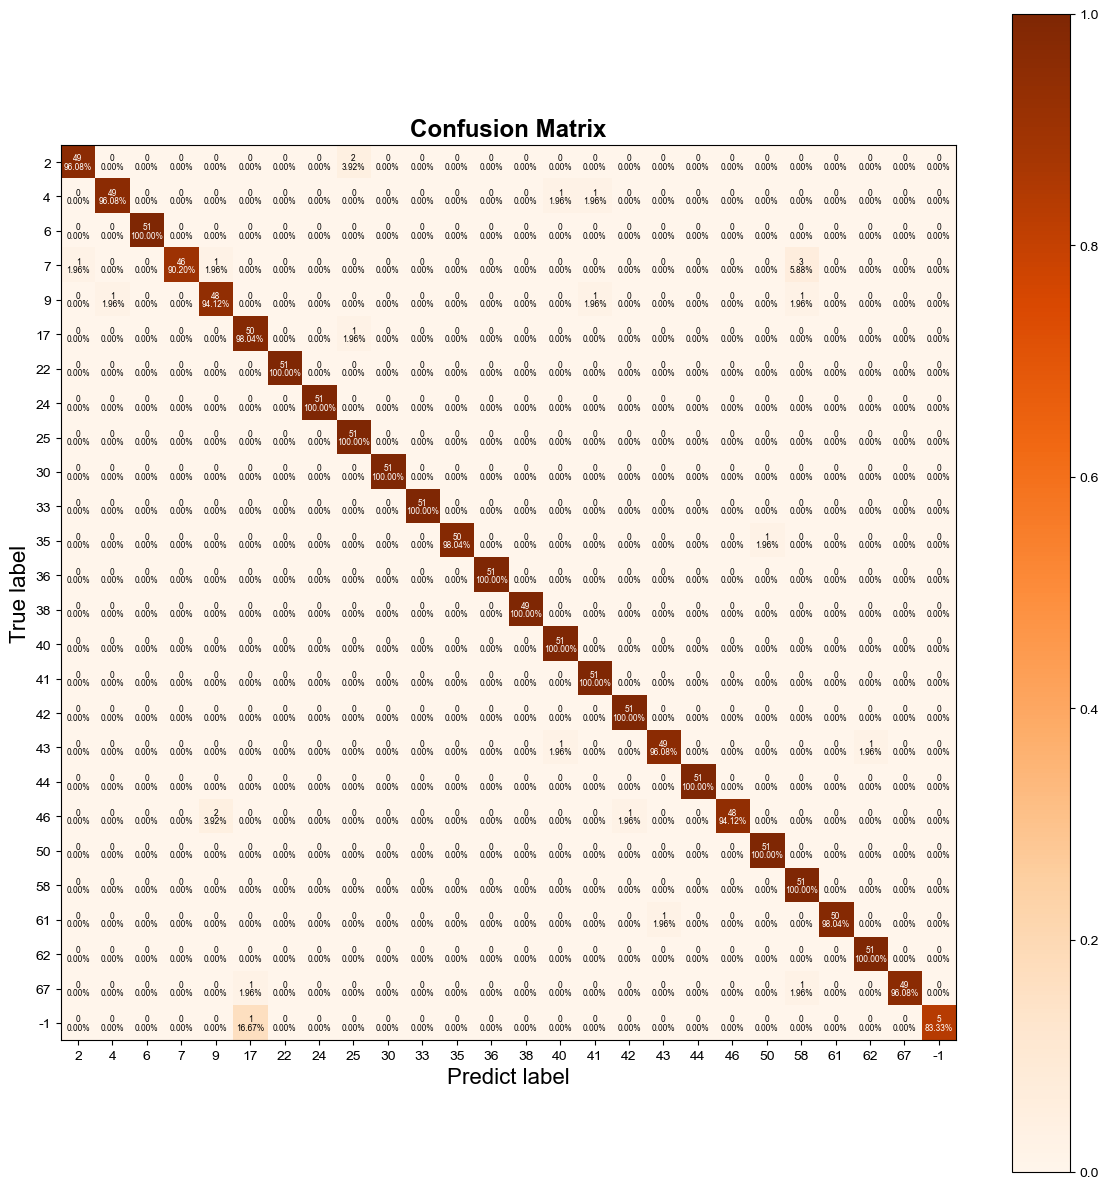

The accuracy of the model is 98.20%
The recall of the model is 98.98%
The precision of the model is 99.21%
The F1 of the model is 99.09%


In [23]:
prelabel(test,p_label)

confusion_matrix(test)

_,_,_,_ = score(test)

## Set C = 0.1

*
optimization finished, #iter = 68
nu = 0.154222
obj = -0.849402, rho = 0.916526
nSV = 29, nBSV = 4
Total nSV = 29
*
optimization finished, #iter = 77
nu = 0.164170
obj = -0.888808, rho = 0.907198
nSV = 29, nBSV = 6
Total nSV = 29
*
optimization finished, #iter = 63
nu = 0.165990
obj = -0.896759, rho = 0.921059
nSV = 28, nBSV = 4
Total nSV = 28
*
optimization finished, #iter = 63
nu = 0.156808
obj = -0.864407, rho = 0.904794
nSV = 27, nBSV = 6
Total nSV = 27
*
optimization finished, #iter = 94
nu = 0.180156
obj = -0.955971, rho = 0.899225
nSV = 33, nBSV = 3
Total nSV = 33
*
optimization finished, #iter = 113
nu = 0.144006
obj = -0.957993, rho = 0.903034
nSV = 33, nBSV = 2
*.*
optimization finished, #iter = 137
nu = 0.165781
obj = -0.888286, rho = 0.875824
nSV = 40, nBSV = 2
Total nSV = 40
*.*
optimization finished, #iter = 109
nu = 0.166756
obj = -0.916709, rho = 0.903276
nSV = 37, nBSV = 5
Total nSV = 37
*
optimization finished, #iter = 100
nu = 0.151980
obj = -0.831951, rho = 0.8861

*
optimization finished, #iter = 98
nu = 0.664336
obj = -8.403466, rho = -0.109080
nSV = 136, nBSV = 120
Total nSV = 136
*
optimization finished, #iter = 91
nu = 0.663665
obj = -8.287179, rho = 0.045685
nSV = 134, nBSV = 117
Total nSV = 134
*
optimization finished, #iter = 137
nu = 0.669647
obj = -8.501561, rho = -0.016821
nSV = 141, nBSV = 118
Total nSV = 141
*
optimization finished, #iter = 95
nu = 0.698006
obj = -8.857503, rho = -0.021609
nSV = 140, nBSV = 126
Total nSV = 140
*
optimization finished, #iter = 113
nu = 0.672313
obj = -8.556431, rho = 0.009016
nSV = 138, nBSV = 122
Total nSV = 138
*
optimization finished, #iter = 112
nu = 0.614593
obj = -9.613841, rho = -0.018324
nSV = 157, nBSV = 139
*
optimization finished, #iter = 120
nu = 0.619035
obj = -7.621324, rho = -0.097281
nSV = 131, nBSV = 107
Total nSV = 131
*
optimization finished, #iter = 108
nu = 0.590999
obj = -7.124565, rho = -0.142917
nSV = 122, nBSV = 102
Total nSV = 122
*
optimization finished, #iter = 124
nu = 0.6

*
optimization finished, #iter = 107
nu = 0.618169
obj = -7.544969, rho = -0.098189
nSV = 130, nBSV = 110
Total nSV = 130
*
optimization finished, #iter = 121
nu = 0.596051
obj = -7.221565, rho = -0.053634
nSV = 124, nBSV = 104
Total nSV = 124
*
optimization finished, #iter = 84
nu = 0.614194
obj = -7.479637, rho = -0.130098
nSV = 124, nBSV = 109
Total nSV = 124
*
optimization finished, #iter = 123
nu = 0.553466
obj = -8.230178, rho = -0.086819
nSV = 143, nBSV = 122
*
optimization finished, #iter = 102
nu = 0.579217
obj = -6.950425, rho = -0.151513
nSV = 119, nBSV = 99
Total nSV = 119
*
optimization finished, #iter = 85
nu = 0.585185
obj = -6.957403, rho = -0.108348
nSV = 119, nBSV = 102
Total nSV = 119
*
optimization finished, #iter = 93
nu = 0.576965
obj = -6.939482, rho = -0.210969
nSV = 116, nBSV = 100
Total nSV = 116
*
optimization finished, #iter = 96
nu = 0.578973
obj = -6.926638, rho = -0.203254
nSV = 120, nBSV = 100
Total nSV = 120
*
optimization finished, #iter = 86
nu = 0.57

*
optimization finished, #iter = 119
nu = 0.485526
obj = -5.547726, rho = -0.062683
nSV = 105, nBSV = 78
Total nSV = 105
*
optimization finished, #iter = 126
nu = 0.501202
obj = -5.665535, rho = -0.005946
nSV = 112, nBSV = 81
Total nSV = 112
*
optimization finished, #iter = 162
nu = 0.495828
obj = -5.672420, rho = -0.000582
nSV = 111, nBSV = 79
Total nSV = 111
*
optimization finished, #iter = 110
nu = 0.505820
obj = -5.723620, rho = -0.081827
nSV = 109, nBSV = 82
Total nSV = 109
*
optimization finished, #iter = 101
nu = 0.440624
obj = -6.208701, rho = -0.043111
nSV = 119, nBSV = 92
*
optimization finished, #iter = 102
nu = 0.557801
obj = -6.634679, rho = 0.104102
nSV = 116, nBSV = 96
Total nSV = 116
*
optimization finished, #iter = 104
nu = 0.550782
obj = -6.429392, rho = 0.119888
nSV = 114, nBSV = 93
Total nSV = 114
*
optimization finished, #iter = 100
nu = 0.548783
obj = -6.404183, rho = 0.122715
nSV = 114, nBSV = 92
Total nSV = 114
*
optimization finished, #iter = 100
nu = 0.562047


*
optimization finished, #iter = 137
nu = 0.560893
obj = -6.776571, rho = 0.091531
nSV = 121, nBSV = 92
Total nSV = 121
*
optimization finished, #iter = 137
nu = 0.501543
obj = -7.485131, rho = 0.013121
nSV = 134, nBSV = 104
*
optimization finished, #iter = 178
nu = 0.482833
obj = -5.569206, rho = -0.137948
nSV = 111, nBSV = 74
Total nSV = 111
*
optimization finished, #iter = 125
nu = 0.512475
obj = -6.039715, rho = -0.083371
nSV = 114, nBSV = 85
Total nSV = 114
*
optimization finished, #iter = 174
nu = 0.500314
obj = -5.899257, rho = -0.083362
nSV = 112, nBSV = 79
Total nSV = 112
*
optimization finished, #iter = 172
nu = 0.498934
obj = -5.711126, rho = -0.156331
nSV = 112, nBSV = 75
Total nSV = 112
*
optimization finished, #iter = 137
nu = 0.494118
obj = -5.710404, rho = -0.153935
nSV = 110, nBSV = 79
Total nSV = 110
*
optimization finished, #iter = 165
nu = 0.436422
obj = -6.355529, rho = -0.136485
nSV = 122, nBSV = 87
*
optimization finished, #iter = 153
nu = 0.534832
obj = -6.31344

*
optimization finished, #iter = 107
nu = 0.646348
obj = -8.089898, rho = -0.029595
nSV = 136, nBSV = 114
Total nSV = 136
*
optimization finished, #iter = 100
nu = 0.648389
obj = -8.064138, rho = -0.011514
nSV = 136, nBSV = 114
Total nSV = 136
*
optimization finished, #iter = 114
nu = 0.594666
obj = -9.129219, rho = -0.016325
nSV = 153, nBSV = 132
*
optimization finished, #iter = 108
nu = 0.593269
obj = -6.944725, rho = -0.101745
nSV = 124, nBSV = 101
Total nSV = 124
*
optimization finished, #iter = 118
nu = 0.602577
obj = -7.114239, rho = 0.056776
nSV = 128, nBSV = 102
Total nSV = 128
*
optimization finished, #iter = 119
nu = 0.618435
obj = -7.375655, rho = 0.005706
nSV = 131, nBSV = 105
Total nSV = 131
*
optimization finished, #iter = 123
nu = 0.609308
obj = -7.148933, rho = -0.069105
nSV = 125, nBSV = 103
Total nSV = 125
*
optimization finished, #iter = 126
nu = 0.608610
obj = -7.031336, rho = -0.027620
nSV = 129, nBSV = 101
Total nSV = 129
*
optimization finished, #iter = 134
nu = 

*
optimization finished, #iter = 103
nu = 0.535442
obj = -6.310611, rho = -0.137484
nSV = 111, nBSV = 88
Total nSV = 111
*
optimization finished, #iter = 114
nu = 0.543671
obj = -6.490287, rho = -0.116310
nSV = 115, nBSV = 92
Total nSV = 115
*
optimization finished, #iter = 109
nu = 0.537515
obj = -6.272668, rho = -0.215191
nSV = 114, nBSV = 92
Total nSV = 114
*
optimization finished, #iter = 130
nu = 0.556239
obj = -6.540741, rho = -0.105517
nSV = 115, nBSV = 89
Total nSV = 115
*
optimization finished, #iter = 138
nu = 0.482674
obj = -7.127939, rho = -0.154859
nSV = 125, nBSV = 101
*
optimization finished, #iter = 92
nu = 0.582961
obj = -7.135221, rho = -0.080957
nSV = 118, nBSV = 102
Total nSV = 118
*
optimization finished, #iter = 112
nu = 0.619933
obj = -7.587140, rho = -0.064636
nSV = 131, nBSV = 109
Total nSV = 131
*
optimization finished, #iter = 100
nu = 0.584407
obj = -6.892727, rho = -0.089098
nSV = 121, nBSV = 98
Total nSV = 121
*
optimization finished, #iter = 100
nu = 0.59

*
optimization finished, #iter = 108
nu = 0.496323
obj = -7.153691, rho = -0.197033
nSV = 128, nBSV = 105
*
optimization finished, #iter = 106
nu = 0.617230
obj = -7.648126, rho = -0.001425
nSV = 130, nBSV = 108
Total nSV = 130
*
optimization finished, #iter = 82
nu = 0.625931
obj = -7.735147, rho = -0.075718
nSV = 125, nBSV = 111
Total nSV = 125
*
optimization finished, #iter = 104
nu = 0.611758
obj = -7.725375, rho = -0.094074
nSV = 128, nBSV = 106
Total nSV = 128
*
optimization finished, #iter = 107
nu = 0.622837
obj = -7.707842, rho = -0.072172
nSV = 126, nBSV = 107
Total nSV = 126
*
optimization finished, #iter = 105
nu = 0.597712
obj = -7.342345, rho = -0.095445
nSV = 123, nBSV = 105
Total nSV = 123
*
optimization finished, #iter = 106
nu = 0.555439
obj = -8.568346, rho = -0.064501
nSV = 141, nBSV = 123
*
optimization finished, #iter = 99
nu = 0.628622
obj = -7.757921, rho = -0.015707
nSV = 129, nBSV = 110
Total nSV = 129
*
optimization finished, #iter = 117
nu = 0.635573
obj = -

*
optimization finished, #iter = 88
nu = 0.571477
obj = -6.986656, rho = -0.007088
nSV = 116, nBSV = 99
Total nSV = 116
*
optimization finished, #iter = 87
nu = 0.545960
obj = -6.642909, rho = 0.054106
nSV = 110, nBSV = 93
Total nSV = 110
*
optimization finished, #iter = 78
nu = 0.562838
obj = -6.926652, rho = 0.077457
nSV = 114, nBSV = 102
Total nSV = 114
*
optimization finished, #iter = 100
nu = 0.504258
obj = -7.643500, rho = 0.018963
nSV = 130, nBSV = 110
*
optimization finished, #iter = 81
nu = 0.531941
obj = -6.280499, rho = -0.123109
nSV = 108, nBSV = 93
Total nSV = 108
*
optimization finished, #iter = 90
nu = 0.532875
obj = -6.295019, rho = -0.003920
nSV = 111, nBSV = 90
Total nSV = 111
*
optimization finished, #iter = 113
nu = 0.532854
obj = -6.435841, rho = -0.175366
nSV = 114, nBSV = 89
Total nSV = 114
*
optimization finished, #iter = 111
nu = 0.539153
obj = -6.252603, rho = -0.134114
nSV = 113, nBSV = 89
Total nSV = 113
*
optimization finished, #iter = 98
nu = 0.538248
obj 

*
optimization finished, #iter = 129
nu = 0.533632
obj = -8.328374, rho = -0.070274
nSV = 142, nBSV = 115
*
optimization finished, #iter = 129
nu = 0.503103
obj = -5.863533, rho = -0.099043
nSV = 116, nBSV = 83
Total nSV = 116
*
optimization finished, #iter = 152
nu = 0.531531
obj = -6.253098, rho = -0.152193
nSV = 116, nBSV = 83
Total nSV = 116
*
optimization finished, #iter = 136
nu = 0.508304
obj = -5.947098, rho = -0.226609
nSV = 110, nBSV = 81
Total nSV = 110
*.*
optimization finished, #iter = 190
nu = 0.511258
obj = -5.925169, rho = -0.198572
nSV = 115, nBSV = 80
Total nSV = 115
*
optimization finished, #iter = 142
nu = 0.517803
obj = -6.007130, rho = -0.198258
nSV = 112, nBSV = 81
Total nSV = 112
*
optimization finished, #iter = 165
nu = 0.451786
obj = -6.608540, rho = -0.177803
nSV = 126, nBSV = 92
*
optimization finished, #iter = 125
nu = 0.577145
obj = -6.918127, rho = 0.052819
nSV = 126, nBSV = 98
Total nSV = 126
*
optimization finished, #iter = 113
nu = 0.558887
obj = -6.79

*
optimization finished, #iter = 152
nu = 0.457602
obj = -6.527143, rho = 0.006033
nSV = 124, nBSV = 93
*
optimization finished, #iter = 92
nu = 0.530173
obj = -6.171885, rho = 0.068066
nSV = 110, nBSV = 90
Total nSV = 110
*
optimization finished, #iter = 118
nu = 0.536338
obj = -6.088606, rho = -0.011988
nSV = 112, nBSV = 85
Total nSV = 112
*
optimization finished, #iter = 122
nu = 0.557475
obj = -6.372894, rho = 0.014547
nSV = 118, nBSV = 89
Total nSV = 118
*
optimization finished, #iter = 150
nu = 0.549294
obj = -6.288698, rho = 0.027259
nSV = 118, nBSV = 89
Total nSV = 118
*
optimization finished, #iter = 116
nu = 0.541579
obj = -6.268039, rho = 0.012395
nSV = 113, nBSV = 89
Total nSV = 113
*
optimization finished, #iter = 117
nu = 0.481176
obj = -6.890660, rho = 0.021206
nSV = 124, nBSV = 100
*
optimization finished, #iter = 112
nu = 0.553877
obj = -6.680548, rho = 0.173846
nSV = 120, nBSV = 96
Total nSV = 120
*
optimization finished, #iter = 86
nu = 0.555172
obj = -6.654857, rho 

*
optimization finished, #iter = 114
nu = 0.547075
obj = -6.453355, rho = -0.076194
nSV = 114, nBSV = 93
Total nSV = 114
*
optimization finished, #iter = 89
nu = 0.540609
obj = -6.452788, rho = -0.174067
nSV = 113, nBSV = 96
Total nSV = 113
*
optimization finished, #iter = 82
nu = 0.536506
obj = -6.482900, rho = -0.209784
nSV = 111, nBSV = 96
Total nSV = 111
*
optimization finished, #iter = 111
nu = 0.490906
obj = -7.280898, rho = -0.130683
nSV = 125, nBSV = 107
*
optimization finished, #iter = 99
nu = 0.542306
obj = -6.298029, rho = -0.058209
nSV = 115, nBSV = 92
Total nSV = 115
*
optimization finished, #iter = 146
nu = 0.532550
obj = -6.065067, rho = -0.120904
nSV = 116, nBSV = 87
Total nSV = 116
*
optimization finished, #iter = 124
nu = 0.537766
obj = -6.255219, rho = -0.102228
nSV = 120, nBSV = 91
Total nSV = 120
*
optimization finished, #iter = 131
nu = 0.536680
obj = -6.178885, rho = -0.130746
nSV = 114, nBSV = 87
Total nSV = 114
*
optimization finished, #iter = 107
nu = 0.523233

*
optimization finished, #iter = 103
nu = 0.484784
obj = -5.668602, rho = -0.029183
nSV = 105, nBSV = 83
Total nSV = 105
*
optimization finished, #iter = 115
nu = 0.505201
obj = -5.764997, rho = 0.044439
nSV = 110, nBSV = 84
Total nSV = 110
*
optimization finished, #iter = 111
nu = 0.494703
obj = -5.752103, rho = 0.060930
nSV = 108, nBSV = 81
Total nSV = 108
*
optimization finished, #iter = 114
nu = 0.436654
obj = -6.226878, rho = -0.006608
nSV = 117, nBSV = 93
*
optimization finished, #iter = 80
nu = 0.616383
obj = -7.712710, rho = 0.095632
nSV = 126, nBSV = 112
Total nSV = 126
*
optimization finished, #iter = 90
nu = 0.599065
obj = -7.427867, rho = 0.183613
nSV = 125, nBSV = 105
Total nSV = 125
*
optimization finished, #iter = 96
nu = 0.593359
obj = -7.355481, rho = 0.144682
nSV = 123, nBSV = 103
Total nSV = 123
*
optimization finished, #iter = 105
nu = 0.591247
obj = -7.296233, rho = 0.118309
nSV = 124, nBSV = 100
Total nSV = 124
*
optimization finished, #iter = 98
nu = 0.579594
obj

*
optimization finished, #iter = 118
nu = 0.556214
obj = -6.604072, rho = 0.064589
nSV = 121, nBSV = 93
Total nSV = 121
*
optimization finished, #iter = 100
nu = 0.570545
obj = -6.720094, rho = 0.055647
nSV = 119, nBSV = 97
Total nSV = 119
*
optimization finished, #iter = 102
nu = 0.543702
obj = -6.343327, rho = 0.136472
nSV = 118, nBSV = 89
Total nSV = 118
*
optimization finished, #iter = 99
nu = 0.535269
obj = -6.376468, rho = 0.004169
nSV = 113, nBSV = 92
Total nSV = 113
*
optimization finished, #iter = 147
nu = 0.495729
obj = -7.209114, rho = 0.082478
nSV = 129, nBSV = 101
*
optimization finished, #iter = 113
nu = 0.516935
obj = -6.124712, rho = -0.047238
nSV = 110, nBSV = 87
Total nSV = 110
*
optimization finished, #iter = 116
nu = 0.513281
obj = -5.897042, rho = -0.045507
nSV = 109, nBSV = 82
Total nSV = 109
*
optimization finished, #iter = 111
nu = 0.501242
obj = -5.858711, rho = -0.134044
nSV = 108, nBSV = 83
Total nSV = 108
*
optimization finished, #iter = 98
nu = 0.490166
obj

*
optimization finished, #iter = 127
nu = 0.504056
obj = -6.003279, rho = -0.041934
nSV = 113, nBSV = 82
Total nSV = 113
*
optimization finished, #iter = 121
nu = 0.511269
obj = -6.019349, rho = 0.047105
nSV = 110, nBSV = 81
Total nSV = 110
*
optimization finished, #iter = 149
nu = 0.519889
obj = -6.181974, rho = 0.049812
nSV = 115, nBSV = 84
Total nSV = 115
*.*
optimization finished, #iter = 214
nu = 0.519485
obj = -6.187529, rho = 0.017697
nSV = 115, nBSV = 82
Total nSV = 115
*
optimization finished, #iter = 101
nu = 0.526451
obj = -6.367210, rho = 0.045004
nSV = 113, nBSV = 90
Total nSV = 113
*
optimization finished, #iter = 131
nu = 0.460436
obj = -6.860119, rho = 0.041660
nSV = 125, nBSV = 95
*
optimization finished, #iter = 144
nu = 0.508953
obj = -5.972497, rho = -0.122953
nSV = 112, nBSV = 83
Total nSV = 112
*
optimization finished, #iter = 128
nu = 0.525288
obj = -6.162581, rho = -0.147667
nSV = 114, nBSV = 87
Total nSV = 114
*
optimization finished, #iter = 149
nu = 0.524757


*
optimization finished, #iter = 134
nu = 0.590483
obj = -7.194891, rho = -0.033753
nSV = 128, nBSV = 98
Total nSV = 128
*
optimization finished, #iter = 108
nu = 0.581667
obj = -7.087102, rho = 0.053239
nSV = 122, nBSV = 101
Total nSV = 122
*
optimization finished, #iter = 108
nu = 0.591545
obj = -7.190067, rho = -0.026723
nSV = 124, nBSV = 102
Total nSV = 124
*
optimization finished, #iter = 148
nu = 0.571562
obj = -6.879850, rho = -0.160874
nSV = 122, nBSV = 92
Total nSV = 122
*
optimization finished, #iter = 109
nu = 0.599098
obj = -7.253083, rho = 0.002754
nSV = 125, nBSV = 103
Total nSV = 125
*
optimization finished, #iter = 120
nu = 0.531049
obj = -7.994177, rho = -0.043107
nSV = 143, nBSV = 115
*
optimization finished, #iter = 132
nu = 0.569339
obj = -6.919724, rho = -0.198562
nSV = 122, nBSV = 95
Total nSV = 122
*
optimization finished, #iter = 124
nu = 0.562804
obj = -6.729748, rho = -0.105404
nSV = 119, nBSV = 97
Total nSV = 119
*
optimization finished, #iter = 118
nu = 0.56

*
optimization finished, #iter = 117
nu = 0.595436
obj = -7.133871, rho = -0.152806
nSV = 123, nBSV = 98
Total nSV = 123
*
optimization finished, #iter = 142
nu = 0.577061
obj = -6.782128, rho = -0.181456
nSV = 123, nBSV = 94
Total nSV = 123
*
optimization finished, #iter = 138
nu = 0.537481
obj = -7.886735, rho = -0.121802
nSV = 140, nBSV = 114
*
optimization finished, #iter = 94
nu = 0.581095
obj = -6.830857, rho = 0.026346
nSV = 122, nBSV = 102
Total nSV = 122
*
optimization finished, #iter = 99
nu = 0.585075
obj = -6.978246, rho = -0.077766
nSV = 122, nBSV = 101
Total nSV = 122
*
optimization finished, #iter = 122
nu = 0.595264
obj = -7.239455, rho = 0.077101
nSV = 126, nBSV = 104
Total nSV = 126
*
optimization finished, #iter = 109
nu = 0.575384
obj = -6.799357, rho = 0.004520
nSV = 119, nBSV = 98
Total nSV = 119
*
optimization finished, #iter = 107
nu = 0.585924
obj = -7.021943, rho = -0.053031
nSV = 121, nBSV = 100
Total nSV = 121
*
optimization finished, #iter = 125
nu = 0.5266

*
optimization finished, #iter = 211
nu = 0.481128
obj = -6.633487, rho = -0.038500
nSV = 136, nBSV = 94
*
optimization finished, #iter = 141
nu = 0.552833
obj = -6.333044, rho = -0.075149
nSV = 118, nBSV = 89
Total nSV = 118
*
optimization finished, #iter = 142
nu = 0.547935
obj = -6.225324, rho = -0.106106
nSV = 117, nBSV = 87
Total nSV = 117
*
optimization finished, #iter = 129
nu = 0.562943
obj = -6.320615, rho = -0.092466
nSV = 115, nBSV = 90
Total nSV = 115
*
optimization finished, #iter = 140
nu = 0.562990
obj = -6.384685, rho = -0.030672
nSV = 118, nBSV = 93
Total nSV = 118
*
optimization finished, #iter = 144
nu = 0.563870
obj = -6.355434, rho = -0.029960
nSV = 123, nBSV = 90
Total nSV = 123
*
optimization finished, #iter = 194
nu = 0.495235
obj = -6.918443, rho = -0.050730
nSV = 135, nBSV = 99
*
optimization finished, #iter = 119
nu = 0.551927
obj = -6.728491, rho = 0.009947
nSV = 121, nBSV = 95
Total nSV = 121
*
optimization finished, #iter = 104
nu = 0.572352
obj = -6.84167

*
optimization finished, #iter = 138
nu = 0.577289
obj = -6.611266, rho = 0.043090
nSV = 124, nBSV = 93
Total nSV = 124
*
optimization finished, #iter = 173
nu = 0.500797
obj = -7.222452, rho = 0.029501
nSV = 137, nBSV = 99
*
optimization finished, #iter = 136
nu = 0.524277
obj = -5.882934, rho = -0.047310
nSV = 114, nBSV = 85
Total nSV = 114
*
optimization finished, #iter = 104
nu = 0.560921
obj = -6.357867, rho = -0.041144
nSV = 117, nBSV = 97
Total nSV = 117
*
optimization finished, #iter = 115
nu = 0.552165
obj = -6.187155, rho = -0.010432
nSV = 114, nBSV = 91
Total nSV = 114
*
optimization finished, #iter = 127
nu = 0.531908
obj = -5.920293, rho = -0.004412
nSV = 114, nBSV = 84
Total nSV = 114
*
optimization finished, #iter = 109
nu = 0.521532
obj = -5.915497, rho = -0.073244
nSV = 110, nBSV = 85
Total nSV = 110
*
optimization finished, #iter = 113
nu = 0.480689
obj = -6.619936, rho = -0.005099
nSV = 122, nBSV = 99
*
optimization finished, #iter = 107
nu = 0.528196
obj = -6.197297

*
optimization finished, #iter = 89
nu = 0.575622
obj = -6.837371, rho = 0.173189
nSV = 118, nBSV = 99
Total nSV = 118
*
optimization finished, #iter = 99
nu = 0.592132
obj = -7.014668, rho = 0.220998
nSV = 119, nBSV = 99
Total nSV = 119
*
optimization finished, #iter = 82
nu = 0.582156
obj = -7.000203, rho = 0.067853
nSV = 117, nBSV = 103
Total nSV = 117
*
optimization finished, #iter = 101
nu = 0.517370
obj = -7.686576, rho = 0.176235
nSV = 131, nBSV = 111
*
optimization finished, #iter = 106
nu = 0.567630
obj = -6.754663, rho = 0.090990
nSV = 116, nBSV = 99
Total nSV = 116
*
optimization finished, #iter = 129
nu = 0.575964
obj = -6.745879, rho = 0.146509
nSV = 123, nBSV = 97
Total nSV = 123
*
optimization finished, #iter = 110
nu = 0.549153
obj = -6.308281, rho = 0.237447
nSV = 116, nBSV = 91
Total nSV = 116
*
optimization finished, #iter = 120
nu = 0.565126
obj = -6.657620, rho = 0.062377
nSV = 117, nBSV = 93
Total nSV = 117
*
optimization finished, #iter = 105
nu = 0.571935
obj = 

*
optimization finished, #iter = 91
nu = 0.540638
obj = -6.660750, rho = 0.042569
nSV = 112, nBSV = 94
Total nSV = 112
*
optimization finished, #iter = 91
nu = 0.507953
obj = -7.865368, rho = 0.008137
nSV = 128, nBSV = 115
*
optimization finished, #iter = 106
nu = 0.579106
obj = -7.157486, rho = -0.192602
nSV = 122, nBSV = 100
Total nSV = 122
*
optimization finished, #iter = 129
nu = 0.556281
obj = -6.951488, rho = -0.213196
nSV = 117, nBSV = 92
Total nSV = 117
*
optimization finished, #iter = 112
nu = 0.579269
obj = -7.213780, rho = -0.091279
nSV = 120, nBSV = 100
Total nSV = 120
*
optimization finished, #iter = 94
nu = 0.582143
obj = -7.139552, rho = -0.017024
nSV = 118, nBSV = 99
Total nSV = 118
*
optimization finished, #iter = 104
nu = 0.593775
obj = -7.297681, rho = -0.164811
nSV = 123, nBSV = 104
Total nSV = 123
*
optimization finished, #iter = 130
nu = 0.523855
obj = -8.044065, rho = -0.137166
nSV = 134, nBSV = 111
*
optimization finished, #iter = 111
nu = 0.502786
obj = -5.8940

*
optimization finished, #iter = 125
nu = 0.599939
obj = -7.176895, rho = -0.024587
nSV = 131, nBSV = 105
Total nSV = 131
*
optimization finished, #iter = 129
nu = 0.591595
obj = -7.122509, rho = -0.011029
nSV = 125, nBSV = 98
Total nSV = 125
*
optimization finished, #iter = 187
nu = 0.523249
obj = -7.784026, rho = -0.001541
nSV = 147, nBSV = 108
*
optimization finished, #iter = 117
nu = 0.539034
obj = -6.501318, rho = -0.144143
nSV = 118, nBSV = 92
Total nSV = 118
*
optimization finished, #iter = 141
nu = 0.537412
obj = -6.356126, rho = -0.115212
nSV = 118, nBSV = 88
Total nSV = 118
*
optimization finished, #iter = 115
nu = 0.525268
obj = -6.175332, rho = -0.120169
nSV = 115, nBSV = 88
Total nSV = 115
*
optimization finished, #iter = 145
nu = 0.524478
obj = -6.098538, rho = -0.115834
nSV = 117, nBSV = 86
Total nSV = 117
*
optimization finished, #iter = 150
nu = 0.537908
obj = -6.331660, rho = -0.132016
nSV = 113, nBSV = 85
Total nSV = 113
*
optimization finished, #iter = 135
nu = 0.46

*
optimization finished, #iter = 98
nu = 0.579731
obj = -6.964284, rho = -0.116502
nSV = 119, nBSV = 102
Total nSV = 119
*
optimization finished, #iter = 96
nu = 0.576474
obj = -7.080769, rho = -0.043185
nSV = 120, nBSV = 99
Total nSV = 120
*
optimization finished, #iter = 129
nu = 0.499075
obj = -7.523364, rho = -0.081149
nSV = 133, nBSV = 108
*
optimization finished, #iter = 121
nu = 0.467963
obj = -5.399476, rho = -0.220347
nSV = 104, nBSV = 74
Total nSV = 104
*
optimization finished, #iter = 109
nu = 0.481566
obj = -5.567836, rho = -0.203870
nSV = 104, nBSV = 79
Total nSV = 104
*
optimization finished, #iter = 112
nu = 0.480005
obj = -5.608394, rho = -0.141101
nSV = 108, nBSV = 82
Total nSV = 108
*
optimization finished, #iter = 110
nu = 0.487278
obj = -5.768094, rho = -0.183402
nSV = 106, nBSV = 82
Total nSV = 106
*
optimization finished, #iter = 107
nu = 0.477618
obj = -5.584627, rho = -0.159751
nSV = 103, nBSV = 79
Total nSV = 103
*
optimization finished, #iter = 174
nu = 0.4218

*
optimization finished, #iter = 135
nu = 0.489265
obj = -5.686201, rho = 0.151880
nSV = 108, nBSV = 80
Total nSV = 108
*
optimization finished, #iter = 123
nu = 0.494114
obj = -5.773569, rho = 0.152922
nSV = 111, nBSV = 83
Total nSV = 111
*
optimization finished, #iter = 145
nu = 0.493646
obj = -5.657346, rho = 0.189096
nSV = 108, nBSV = 83
Total nSV = 108
*
optimization finished, #iter = 183
nu = 0.437325
obj = -6.374716, rho = 0.145952
nSV = 122, nBSV = 88
*
optimization finished, #iter = 161
nu = 0.551642
obj = -6.612623, rho = 0.154961
nSV = 121, nBSV = 88
Total nSV = 121
*
optimization finished, #iter = 130
nu = 0.531642
obj = -6.264928, rho = 0.247489
nSV = 116, nBSV = 86
Total nSV = 116
*
optimization finished, #iter = 134
nu = 0.544117
obj = -6.466799, rho = 0.199007
nSV = 118, nBSV = 84
Total nSV = 118
*
optimization finished, #iter = 102
nu = 0.548818
obj = -6.485428, rho = 0.231800
nSV = 115, nBSV = 88
Total nSV = 115
*
optimization finished, #iter = 125
nu = 0.537087
obj =

*
optimization finished, #iter = 110
nu = 0.579607
obj = -7.140483, rho = 0.103007
nSV = 125, nBSV = 100
Total nSV = 125
*
optimization finished, #iter = 140
nu = 0.560094
obj = -6.870518, rho = 0.123768
nSV = 120, nBSV = 93
Total nSV = 120
*
optimization finished, #iter = 133
nu = 0.561584
obj = -6.767818, rho = 0.199582
nSV = 122, nBSV = 96
Total nSV = 122
*
optimization finished, #iter = 140
nu = 0.564700
obj = -6.862485, rho = 0.104710
nSV = 121, nBSV = 91
Total nSV = 121
*
optimization finished, #iter = 150
nu = 0.502807
obj = -7.590766, rho = 0.161964
nSV = 140, nBSV = 105
*
optimization finished, #iter = 108
nu = 0.557686
obj = -6.857244, rho = 0.015050
nSV = 116, nBSV = 95
Total nSV = 116
*
optimization finished, #iter = 113
nu = 0.527864
obj = -6.326073, rho = -0.013714
nSV = 116, nBSV = 90
Total nSV = 116
*
optimization finished, #iter = 134
nu = 0.552457
obj = -6.720717, rho = 0.023273
nSV = 120, nBSV = 93
Total nSV = 120
*
optimization finished, #iter = 116
nu = 0.540539
ob

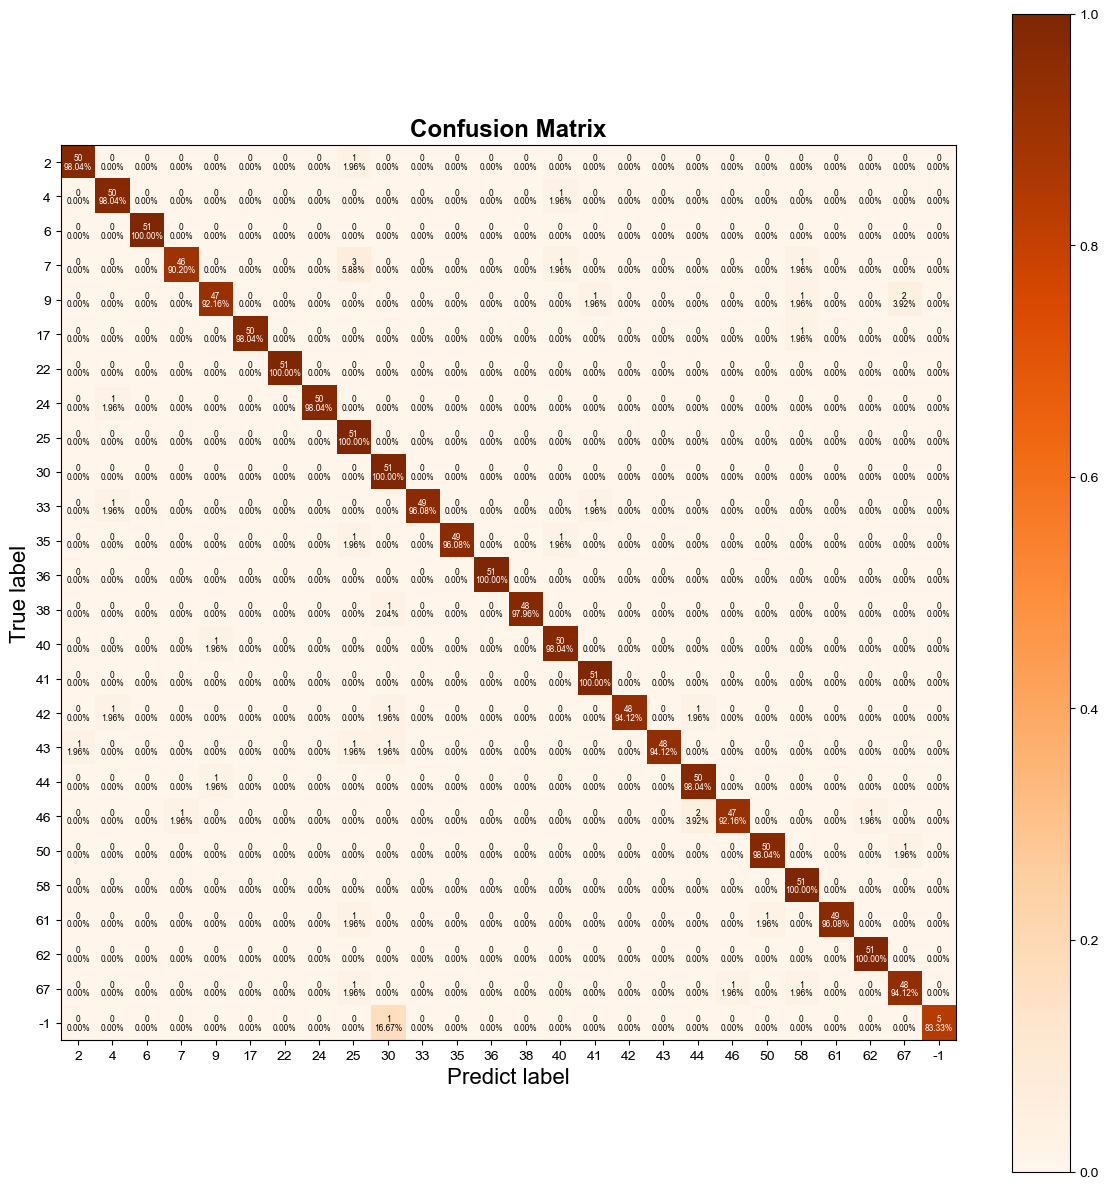

The accuracy of the model is 97.11%
The recall of the model is 98.65%
The precision of the model is 98.42%
The F1 of the model is 98.53%


In [29]:
options = '-t 0 -c 0.1 -b 1' 
model = svm_train(train_label,train_set,options)

p_label, p_acc, p_val = svm_predict(test_label, test_set, model,'-b 1')

prelabel(test,p_label)

confusion_matrix(test)

_,_,_,_ = score(test)

In [30]:
options = '-t 0 -c 0.01 -b 1' 
model = svm_train(train_label,train_set,options)

*
optimization finished, #iter = 35
nu = 0.168224
obj = -0.169847, rho = 0.991168
nSV = 28, nBSV = 10
Total nSV = 28
*
optimization finished, #iter = 34
nu = 0.188679
obj = -0.187278, rho = 0.987410
nSV = 31, nBSV = 15
Total nSV = 31
*
optimization finished, #iter = 31
nu = 0.186916
obj = -0.187371, rho = 0.989696
nSV = 29, nBSV = 15
Total nSV = 29
*
optimization finished, #iter = 42
nu = 0.245283
obj = -0.241216, rho = 0.986376
nSV = 36, nBSV = 18
Total nSV = 36
*
optimization finished, #iter = 41
nu = 0.264151
obj = -0.258730, rho = 0.982123
nSV = 37, nBSV = 22
Total nSV = 37
*
optimization finished, #iter = 42
nu = 0.210526
obj = -0.259091, rho = 0.984311
nSV = 36, nBSV = 23
*
optimization finished, #iter = 38
nu = 0.205607
obj = -0.206212, rho = 0.985644
nSV = 31, nBSV = 13
Total nSV = 31
*
optimization finished, #iter = 43
nu = 0.207547
obj = -0.205386, rho = 0.984939
nSV = 31, nBSV = 15
Total nSV = 31
*
optimization finished, #iter = 47
nu = 0.186916
obj = -0.187004, rho = 0.9901

*
optimization finished, #iter = 92
nu = 0.957895
obj = -1.653098, rho = -0.701780
nSV = 183, nBSV = 181
Total nSV = 183
*
optimization finished, #iter = 96
nu = 0.963351
obj = -1.683309, rho = -0.719651
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 101
nu = 0.915789
obj = -1.589478, rho = 0.762548
nSV = 178, nBSV = 171
Total nSV = 178
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.699670, rho = 0.613286
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.082138, rho = 0.030713
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.900524
obj = -1.599643, rho = -0.817901
nSV = 176, nBSV = 170
Total nSV = 176
*
optimization finished, #iter = 97
nu = 0.968421
obj = -1.698517, rho = 0.734189
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 99
nu = 0.963351
obj = -1.707561, rho = 0.759028
nSV = 186, nBSV = 183
Total nSV = 186
*
optimization finished, #iter = 96
nu = 0.989474
o

*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.677750, rho = -0.018616
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 94
nu = 0.973822
obj = -1.681363, rho = -0.698396
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.702453, rho = -0.000825
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.989474
obj = -1.699254, rho = 0.575926
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.072867, rho = -0.022098
nSV = 238, nBSV = 238
*
optimization finished, #iter = 97
nu = 0.952880
obj = -1.637183, rho = -0.753319
nSV = 184, nBSV = 181
Total nSV = 184
*
optimization finished, #iter = 99
nu = 0.989474
obj = -1.680601, rho = 0.602897
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.705878, rho = -0.671758
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 99
nu = 0.968421

*
optimization finished, #iter = 98
nu = 0.978947
obj = -1.631546, rho = 0.646332
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 102
nu = 0.963351
obj = -1.615473, rho = 0.625190
nSV = 186, nBSV = 182
Total nSV = 186
*
optimization finished, #iter = 95
nu = 0.947368
obj = -1.585170, rho = -0.697344
nSV = 183, nBSV = 178
Total nSV = 183
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.645764, rho = -0.621240
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -1.998387, rho = -0.033907
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.963351
obj = -1.638245, rho = 0.731730
nSV = 186, nBSV = 183
Total nSV = 186
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.687532, rho = 0.029739
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.973822
obj = -1.660285, rho = 0.664571
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 88
nu = 0.884211
o

*
optimization finished, #iter = 95
nu = 0.984293
obj = -1.681081, rho = -0.679770
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 101
nu = 0.947368
obj = -1.635175, rho = -0.771706
nSV = 184, nBSV = 177
Total nSV = 184
*
optimization finished, #iter = 95
nu = 0.984293
obj = -1.678065, rho = -0.687359
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 99
nu = 0.957895
obj = -1.640129, rho = 0.679110
nSV = 184, nBSV = 179
Total nSV = 184
*
optimization finished, #iter = 100
nu = 0.957895
obj = -1.624137, rho = 0.659757
nSV = 184, nBSV = 180
Total nSV = 184
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.057615, rho = -0.047009
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.984293
obj = -1.653130, rho = 0.587614
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 99
nu = 0.978947
obj = -1.642688, rho = 0.623348
nSV = 188, nBSV = 183
Total nSV = 188
*
optimization finished, #iter = 96
nu = 0.994764

*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.036144, rho = 0.001736
nSV = 238, nBSV = 238
*
optimization finished, #iter = 101
nu = 0.973822
obj = -1.697564, rho = 0.684590
nSV = 188, nBSV = 184
Total nSV = 188
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.736016, rho = 0.012201
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 95
nu = 0.952880
obj = -1.674711, rho = -0.762277
nSV = 184, nBSV = 180
Total nSV = 184
*
optimization finished, #iter = 99
nu = 0.989474
obj = -1.717396, rho = 0.661018
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 98
nu = 0.989474
obj = -1.715853, rho = 0.680969
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.117792, rho = 0.017869
nSV = 238, nBSV = 238
*
optimization finished, #iter = 101
nu = 0.984293
obj = -1.699632, rho = 0.676156
nSV = 190, nBSV = 185
Total nSV = 190
*
optimization finished, #iter = 98
nu = 0.989474
obj = -1.697672, 

*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.050482, rho = -0.041056
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.672891, rho = 0.490330
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 100
nu = 0.968421
obj = -1.648843, rho = 0.655414
nSV = 186, nBSV = 181
Total nSV = 186
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.670149, rho = -0.588596
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 97
nu = 0.957895
obj = -1.614358, rho = -0.703295
nSV = 186, nBSV = 180
Total nSV = 186
*
optimization finished, #iter = 97
nu = 0.989474
obj = -1.660924, rho = 0.573432
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.029674, rho = -0.048693
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.984293
obj = -1.693525, rho = 0.658847
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 97
nu = 0.968421
obj = -1.659298

*
optimization finished, #iter = 120
nu = 0.982906
obj = -1.987757, rho = -0.605887
nSV = 232, nBSV = 229
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.713710, rho = 0.552342
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.689143, rho = -0.050606
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 94
nu = 0.963351
obj = -1.674831, rho = 0.686896
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 96
nu = 0.947368
obj = -1.646785, rho = -0.739403
nSV = 181, nBSV = 178
Total nSV = 181
*
optimization finished, #iter = 96
nu = 0.989474
obj = -1.688974, rho = 0.565241
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.078428, rho = -0.035498
nSV = 238, nBSV = 238
*
optimization finished, #iter = 101
nu = 0.973822
obj = -1.682280, rho = 0.656304
nSV = 189, nBSV = 184
Total nSV = 189
*
optimization finished, #iter = 93
nu = 0.968421
obj = -1.674790

*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.037170, rho = 0.033476
nSV = 238, nBSV = 238
*
optimization finished, #iter = 99
nu = 0.942408
obj = -1.595083, rho = 0.678906
nSV = 182, nBSV = 178
Total nSV = 182
*
optimization finished, #iter = 97
nu = 0.915789
obj = -1.557535, rho = -0.769853
nSV = 178, nBSV = 170
Total nSV = 178
*
optimization finished, #iter = 97
nu = 0.973822
obj = -1.654841, rho = 0.645895
nSV = 188, nBSV = 184
Total nSV = 188
*
optimization finished, #iter = 96
nu = 0.989474
obj = -1.676970, rho = 0.639129
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.652685, rho = -0.649340
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.027171, rho = -0.018771
nSV = 238, nBSV = 238
*
optimization finished, #iter = 97
nu = 0.984293
obj = -1.683075, rho = -0.681482
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 103
nu = 0.978947
obj = -1.666252

*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.661741, rho = -0.048739
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.022624, rho = -0.037208
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.684211, rho = -0.584709
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 95
nu = 0.978947
obj = -1.663897, rho = 0.650524
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 100
nu = 0.973822
obj = -1.659827, rho = 0.617301
nSV = 189, nBSV = 185
Total nSV = 189
*
optimization finished, #iter = 94
nu = 0.978947
obj = -1.662386, rho = -0.652650
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 94
nu = 0.978947
obj = -1.658837, rho = -0.626681
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.046943, rho = 0.004636
nSV = 238, nBSV = 238
*
optimization finished, #iter = 102
nu = 0.952880
obj = -1.6464

*
optimization finished, #iter = 97
nu = 0.919786
obj = -1.535935, rho = -0.718580
nSV = 177, nBSV = 166
Total nSV = 177
*
optimization finished, #iter = 121
nu = 0.982906
obj = -1.973163, rho = -0.539551
nSV = 232, nBSV = 227
*
optimization finished, #iter = 96
nu = 0.984293
obj = -1.655185, rho = 0.610395
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 99
nu = 0.989474
obj = -1.667404, rho = -0.600709
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.673262, rho = 0.550765
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 98
nu = 0.989474
obj = -1.655837, rho = -0.568853
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.676236, rho = -0.032056
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.027417, rho = -0.006407
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.66571

*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.666720, rho = -0.689195
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.029283, rho = -0.048092
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.707374, rho = -0.622507
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 101
nu = 0.978947
obj = -1.689793, rho = 0.647118
nSV = 188, nBSV = 185
Total nSV = 188
*
optimization finished, #iter = 95
nu = 0.984293
obj = -1.711115, rho = -0.661677
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 97
nu = 0.968421
obj = -1.678226, rho = 0.661178
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 94
nu = 0.968421
obj = -1.662495, rho = -0.716130
nSV = 185, nBSV = 182
Total nSV = 185
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.089363, rho = -0.027916
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.973822
obj = -1.6713

*
optimization finished, #iter = 99
nu = 0.947368
obj = -1.632022, rho = 0.692652
nSV = 183, nBSV = 176
Total nSV = 183
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.056156, rho = -0.112305
nSV = 238, nBSV = 238
*
optimization finished, #iter = 100
nu = 0.931937
obj = -1.587874, rho = -0.746465
nSV = 182, nBSV = 176
Total nSV = 182
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.652143, rho = -0.042356
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.952880
obj = -1.603948, rho = 0.590365
nSV = 184, nBSV = 179
Total nSV = 184
*
optimization finished, #iter = 99
nu = 0.926316
obj = -1.579762, rho = 0.666464
nSV = 180, nBSV = 171
Total nSV = 180
*
optimization finished, #iter = 94
nu = 0.947368
obj = -1.586896, rho = -0.707868
nSV = 181, nBSV = 179
Total nSV = 181
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.002770, rho = -0.061712
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.70611

*
optimization finished, #iter = 96
nu = 0.978947
obj = -1.648148, rho = 0.657960
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.659720, rho = -0.543496
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.035350, rho = 0.054287
nSV = 238, nBSV = 238
*
optimization finished, #iter = 97
nu = 0.994764
obj = -1.670005, rho = 0.575593
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.672465, rho = -0.031402
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 100
nu = 0.963351
obj = -1.638767, rho = 0.688235
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.668512, rho = -0.040511
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 93
nu = 0.957895
obj = -1.619990, rho = -0.679414
nSV = 184, nBSV = 180
Total nSV = 184
*
optimization finished, #iter = 119
nu = 1.000000

*
optimization finished, #iter = 95
nu = 0.978947
obj = -1.647152, rho = 0.623839
nSV = 188, nBSV = 185
Total nSV = 188
*
optimization finished, #iter = 97
nu = 0.968421
obj = -1.636947, rho = -0.625293
nSV = 187, nBSV = 181
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.027992, rho = 0.006863
nSV = 238, nBSV = 238
*
optimization finished, #iter = 98
nu = 0.973822
obj = -1.665017, rho = 0.639614
nSV = 188, nBSV = 185
Total nSV = 188
*
optimization finished, #iter = 96
nu = 0.947368
obj = -1.606032, rho = 0.706374
nSV = 181, nBSV = 177
Total nSV = 181
*
optimization finished, #iter = 100
nu = 0.921466
obj = -1.587997, rho = -0.715136
nSV = 182, nBSV = 172
Total nSV = 182
*
optimization finished, #iter = 97
nu = 0.936842
obj = -1.599187, rho = -0.709501
nSV = 180, nBSV = 175
Total nSV = 180
*
optimization finished, #iter = 100
nu = 0.936842
obj = -1.606044, rho = 0.733050
nSV = 181, nBSV = 175
Total nSV = 181
*
optimization finished, #iter = 119
nu = 1.000000

*
optimization finished, #iter = 95
nu = 0.968421
obj = -1.662146, rho = -0.705921
nSV = 186, nBSV = 182
Total nSV = 186
*
optimization finished, #iter = 96
nu = 0.957895
obj = -1.654222, rho = -0.727029
nSV = 184, nBSV = 179
Total nSV = 184
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.073977, rho = 0.010707
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 0.893617
obj = -1.529997, rho = -0.795640
nSV = 172, nBSV = 164
Total nSV = 172
*
optimization finished, #iter = 94
nu = 0.994652
obj = -1.660898, rho = 0.602904
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 94
nu = 0.994652
obj = -1.658496, rho = 0.575608
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 92
nu = 0.941176
obj = -1.593735, rho = -0.745385
nSV = 179, nBSV = 173
Total nSV = 179
*
optimization finished, #iter = 100
nu = 0.930481
obj = -1.565565, rho = 0.719440
nSV = 177, nBSV = 170
Total nSV = 177
*
optimization finished, #iter = 121
nu = 0.982906

*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.676687, rho = -0.607254
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 101
nu = 0.957895
obj = -1.641234, rho = 0.698971
nSV = 185, nBSV = 180
Total nSV = 185
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.054669, rho = 0.024060
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.984293
obj = -1.694394, rho = 0.667547
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 96
nu = 0.978947
obj = -1.673924, rho = -0.686688
nSV = 187, nBSV = 183
Total nSV = 187
*
optimization finished, #iter = 97
nu = 0.952880
obj = -1.649239, rho = 0.720193
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.713901, rho = -0.057648
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 102
nu = 0.957895
obj = -1.655252, rho = -0.732361
nSV = 184, nBSV = 178
Total nSV = 184
*
optimization finished, #iter = 119
nu = 1.00000

*
optimization finished, #iter = 97
nu = 0.984293
obj = -1.694852, rho = -0.686850
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 95
nu = 0.968421
obj = -1.647601, rho = -0.711874
nSV = 186, nBSV = 182
Total nSV = 186
*
optimization finished, #iter = 95
nu = 0.973822
obj = -1.675298, rho = 0.620453
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.687167, rho = 0.588676
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 97
nu = 0.989474
obj = -1.692912, rho = 0.595990
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.073382, rho = -0.071934
nSV = 238, nBSV = 238
*
optimization finished, #iter = 101
nu = 0.984293
obj = -1.682353, rho = -0.664364
nSV = 191, nBSV = 186
Total nSV = 191
*
optimization finished, #iter = 100
nu = 0.957895
obj = -1.635087, rho = -0.723850
nSV = 184, nBSV = 177
Total nSV = 184
*
optimization finished, #iter = 102
nu = 0.9528

*
optimization finished, #iter = 98
nu = 0.957895
obj = -1.625871, rho = 0.670707
nSV = 183, nBSV = 180
Total nSV = 183
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.045069, rho = -0.014261
nSV = 238, nBSV = 238
*
optimization finished, #iter = 98
nu = 0.963351
obj = -1.634624, rho = -0.690025
nSV = 187, nBSV = 182
Total nSV = 187
*
optimization finished, #iter = 97
nu = 0.989474
obj = -1.674221, rho = 0.613980
nSV = 190, nBSV = 187
Total nSV = 190
*
optimization finished, #iter = 99
nu = 0.984293
obj = -1.663537, rho = -0.687764
nSV = 191, nBSV = 185
Total nSV = 191
*
optimization finished, #iter = 96
nu = 0.957895
obj = -1.634267, rho = 0.670714
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.679454, rho = -0.068603
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.042344, rho = -0.087890
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 0.989362
obj = -1.645108

*
optimization finished, #iter = 98
nu = 0.989474
obj = -1.656840, rho = 0.563605
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.027682, rho = -0.051601
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 1.000000
obj = -1.662555, rho = 0.033360
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 93
nu = 0.973262
obj = -1.629960, rho = 0.645798
nSV = 182, nBSV = 182
Total nSV = 182
*
optimization finished, #iter = 93
nu = 0.962567
obj = -1.616724, rho = 0.681085
nSV = 180, nBSV = 180
Total nSV = 180
*
optimization finished, #iter = 96
nu = 0.973262
obj = -1.630382, rho = 0.674378
nSV = 184, nBSV = 180
Total nSV = 184
*
optimization finished, #iter = 93
nu = 0.994652
obj = -1.658427, rho = -0.583194
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 117
nu = 0.982906
obj = -1.995847, rho = 0.533133
nSV = 230, nBSV = 230
*
optimization finished, #iter = 92
nu = 0.968085
obj = -1.626591, r

*
optimization finished, #iter = 97
nu = 0.952880
obj = -1.634946, rho = 0.692887
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 93
nu = 0.947368
obj = -1.604410, rho = -0.670880
nSV = 182, nBSV = 179
Total nSV = 182
*
optimization finished, #iter = 100
nu = 0.973822
obj = -1.653199, rho = 0.625482
nSV = 188, nBSV = 185
Total nSV = 188
*
optimization finished, #iter = 91
nu = 0.957895
obj = -1.624834, rho = -0.666155
nSV = 182, nBSV = 182
Total nSV = 182
*
optimization finished, #iter = 98
nu = 0.978947
obj = -1.651751, rho = 0.627891
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.029639, rho = 0.013232
nSV = 238, nBSV = 238
*
optimization finished, #iter = 100
nu = 0.952880
obj = -1.638479, rho = 0.642403
nSV = 184, nBSV = 179
Total nSV = 184
*
optimization finished, #iter = 93
nu = 0.968421
obj = -1.645685, rho = -0.688936
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 95
nu = 0.984293


*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.079528, rho = 0.040477
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.963351
obj = -1.660795, rho = -0.678568
nSV = 186, nBSV = 183
Total nSV = 186
*
optimization finished, #iter = 96
nu = 0.968421
obj = -1.660722, rho = -0.689472
nSV = 187, nBSV = 182
Total nSV = 187
*
optimization finished, #iter = 104
nu = 0.910995
obj = -1.582635, rho = 0.753711
nSV = 178, nBSV = 172
Total nSV = 178
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.681296, rho = 0.603180
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 97
nu = 0.968421
obj = -1.657121, rho = -0.680774
nSV = 187, nBSV = 182
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.065896, rho = -0.047299
nSV = 238, nBSV = 238
*
optimization finished, #iter = 99
nu = 0.973822
obj = -1.655762, rho = 0.657921
nSV = 188, nBSV = 184
Total nSV = 188
*
optimization finished, #iter = 95
nu = 0.968421
obj = -1.642393

*
optimization finished, #iter = 94
nu = 0.978947
obj = -1.645189, rho = -0.648391
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.025180, rho = -0.057846
nSV = 238, nBSV = 238
*
optimization finished, #iter = 101
nu = 0.984293
obj = -1.623184, rho = 0.555375
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 103
nu = 0.968421
obj = -1.607780, rho = 0.576337
nSV = 187, nBSV = 180
Total nSV = 187
*
optimization finished, #iter = 101
nu = 0.963351
obj = -1.601057, rho = 0.612736
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 92
nu = 0.957895
obj = -1.586840, rho = -0.673981
nSV = 183, nBSV = 181
Total nSV = 183
*
optimization finished, #iter = 95
nu = 0.957895
obj = -1.583724, rho = -0.662465
nSV = 183, nBSV = 180
Total nSV = 183
*
optimization finished, #iter = 119
nu = 1.000000
obj = -1.968188, rho = -0.076423
nSV = 238, nBSV = 238
*
optimization finished, #iter = 93
nu = 0.942408
obj = -1.643

*
optimization finished, #iter = 99
nu = 0.989474
obj = -1.631057, rho = 0.610212
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -1.975971, rho = 0.063008
nSV = 238, nBSV = 238
*
optimization finished, #iter = 100
nu = 0.973822
obj = -1.663633, rho = -0.627188
nSV = 190, nBSV = 182
Total nSV = 190
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.650552, rho = 0.587997
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.665164, rho = 0.587869
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.649393, rho = 0.613845
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.674772, rho = 0.025766
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.026359, rho = 0.011353
nSV = 238, nBSV = 238
*
optimization finished, #iter = 100
nu = 0.984293
obj = -1.631349, 

*
optimization finished, #iter = 96
nu = 0.968421
obj = -1.641490, rho = -0.663082
nSV = 186, nBSV = 181
Total nSV = 186
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.687086, rho = 0.001111
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.046401, rho = -0.043580
nSV = 238, nBSV = 238
*
optimization finished, #iter = 99
nu = 0.994764
obj = -1.667467, rho = 0.529264
nSV = 191, nBSV = 188
Total nSV = 191
*
optimization finished, #iter = 100
nu = 0.989474
obj = -1.662413, rho = 0.582767
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 98
nu = 0.921466
obj = -1.583416, rho = -0.740151
nSV = 180, nBSV = 172
Total nSV = 180
*
optimization finished, #iter = 94
nu = 0.978947
obj = -1.639564, rho = -0.673464
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 101
nu = 0.915789
obj = -1.558244, rho = 0.701219
nSV = 180, nBSV = 170
Total nSV = 180
*
optimization finished, #iter = 119
nu = 1.00000

Accuracy = 85.3792% (1092/1279) (classification)


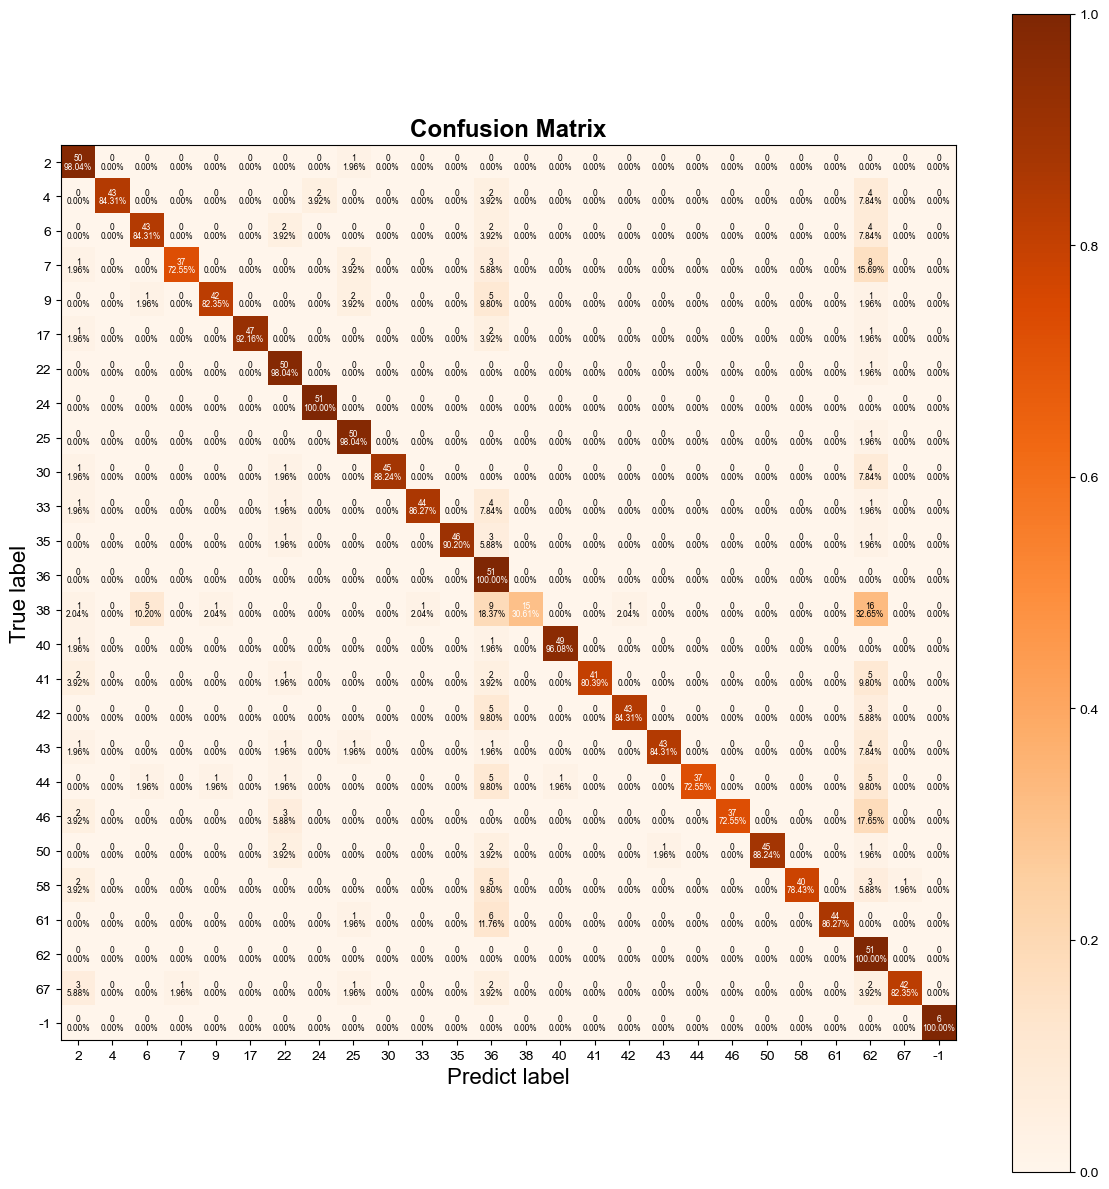

The accuracy of the model is 85.38%
The recall of the model is 91.30%
The precision of the model is 92.94%
The F1 of the model is 92.11%


In [31]:
p_label, p_acc, p_val = svm_predict(test_label, test_set, model,'-b 1')

prelabel(test,p_label)

confusion_matrix(test)

_,_,_,_ = score(test)

## Reduce the dimension to 200

In [32]:
redimension(train, test, feature_dimension = 200, fun = 'pca')

Training done!
Testing done!


## Set C = 1

In [33]:
options = '-t 0 -c 1 -b 1' 
model = svm_train(train_label,train_set,options)

*
optimization finished, #iter = 100
nu = 0.015926
obj = -0.851953, rho = 0.909574
nSV = 29, nBSV = 0
Total nSV = 29
*
optimization finished, #iter = 104
nu = 0.017418
obj = -0.923114, rho = 0.903223
nSV = 32, nBSV = 0
Total nSV = 32
*
optimization finished, #iter = 98
nu = 0.016506
obj = -0.882958, rho = 0.906673
nSV = 31, nBSV = 0
Total nSV = 31
*
optimization finished, #iter = 83
nu = 0.016901
obj = -0.895552, rho = 0.911786
nSV = 27, nBSV = 0
Total nSV = 27
*
optimization finished, #iter = 94
nu = 0.016433
obj = -0.870910, rho = 0.911220
nSV = 29, nBSV = 0
Total nSV = 29
*
optimization finished, #iter = 103
nu = 0.014409
obj = -0.958131, rho = 0.902925
nSV = 31, nBSV = 0
*.*
optimization finished, #iter = 124
nu = 0.017576
obj = -0.940273, rho = 0.896036
nSV = 34, nBSV = 0
Total nSV = 34
*
optimization finished, #iter = 83
nu = 0.017033
obj = -0.902650, rho = 0.898184
nSV = 29, nBSV = 0
Total nSV = 29
*
optimization finished, #iter = 101
nu = 0.016935
obj = -0.905901, rho = 0.89036

*
optimization finished, #iter = 151
nu = 0.145694
obj = -14.450800, rho = 0.049589
nSV = 48, nBSV = 11
Total nSV = 48
*.*
optimization finished, #iter = 229
nu = 0.142717
obj = -14.362718, rho = -0.001054
nSV = 53, nBSV = 9
Total nSV = 53
*
optimization finished, #iter = 179
nu = 0.120088
obj = -15.063784, rho = 0.027133
nSV = 47, nBSV = 9
*.*
optimization finished, #iter = 238
nu = 0.111122
obj = -11.111666, rho = -0.175310
nSV = 48, nBSV = 6
Total nSV = 48
*
optimization finished, #iter = 168
nu = 0.117848
obj = -11.485998, rho = -0.184954
nSV = 45, nBSV = 5
Total nSV = 45
*.*
optimization finished, #iter = 249
nu = 0.117530
obj = -11.480138, rho = -0.127621
nSV = 48, nBSV = 3
Total nSV = 48
*.*
optimization finished, #iter = 249
nu = 0.112286
obj = -11.121449, rho = -0.124672
nSV = 49, nBSV = 6
Total nSV = 49
*.*
optimization finished, #iter = 258
nu = 0.113573
obj = -11.117075, rho = -0.141600
nSV = 52, nBSV = 6
Total nSV = 52
*.*
optimization finished, #iter = 264
nu = 0.098762
o

*.*
optimization finished, #iter = 370
nu = 0.097171
obj = -11.893986, rho = -0.042338
nSV = 57, nBSV = 7
*
optimization finished, #iter = 118
nu = 0.147871
obj = -15.178488, rho = -0.091657
nSV = 46, nBSV = 11
Total nSV = 46
*.*
optimization finished, #iter = 271
nu = 0.153586
obj = -15.518968, rho = -0.070549
nSV = 56, nBSV = 11
Total nSV = 56
*.*
optimization finished, #iter = 259
nu = 0.148421
obj = -15.424684, rho = -0.040472
nSV = 54, nBSV = 10
Total nSV = 54
*
optimization finished, #iter = 180
nu = 0.151004
obj = -15.343451, rho = -0.085955
nSV = 51, nBSV = 14
Total nSV = 51
*.*
optimization finished, #iter = 251
nu = 0.146368
obj = -14.811120, rho = -0.155315
nSV = 55, nBSV = 10
Total nSV = 55
*
optimization finished, #iter = 183
nu = 0.130931
obj = -16.535035, rho = -0.082726
nSV = 55, nBSV = 12
*.*
optimization finished, #iter = 243
nu = 0.123169
obj = -12.288074, rho = 0.030511
nSV = 51, nBSV = 8
Total nSV = 51
*
optimization finished, #iter = 145
nu = 0.127048
obj = -12.74

*
optimization finished, #iter = 208
nu = 0.098096
obj = -11.978941, rho = -0.142865
nSV = 52, nBSV = 8
*.*
optimization finished, #iter = 214
nu = 0.125350
obj = -12.901578, rho = -0.103279
nSV = 49, nBSV = 9
Total nSV = 49
*.*
optimization finished, #iter = 257
nu = 0.137292
obj = -14.092259, rho = 0.041422
nSV = 52, nBSV = 10
Total nSV = 52
*.*
optimization finished, #iter = 201
nu = 0.139415
obj = -14.186329, rho = 0.053162
nSV = 49, nBSV = 9
Total nSV = 49
*.*
optimization finished, #iter = 200
nu = 0.137184
obj = -13.770401, rho = 0.005251
nSV = 48, nBSV = 11
Total nSV = 48
*.*
optimization finished, #iter = 200
nu = 0.133037
obj = -13.202012, rho = 0.001642
nSV = 48, nBSV = 10
Total nSV = 48
*
optimization finished, #iter = 207
nu = 0.119740
obj = -14.813748, rho = -0.016074
nSV = 51, nBSV = 14
*.*
optimization finished, #iter = 265
nu = 0.093504
obj = -9.000414, rho = -0.024745
nSV = 52, nBSV = 4
Total nSV = 52
*.*
optimization finished, #iter = 259
nu = 0.101415
obj = -9.85246

*.*
optimization finished, #iter = 247
nu = 0.090586
obj = -11.574871, rho = -0.012341
nSV = 55, nBSV = 10
*.*
optimization finished, #iter = 219
nu = 0.112345
obj = -11.336477, rho = -0.065262
nSV = 52, nBSV = 8
Total nSV = 52
*
optimization finished, #iter = 179
nu = 0.128632
obj = -13.022337, rho = -0.025433
nSV = 50, nBSV = 10
Total nSV = 50
*
optimization finished, #iter = 172
nu = 0.113400
obj = -11.368249, rho = -0.044702
nSV = 48, nBSV = 6
Total nSV = 48
*.*
optimization finished, #iter = 201
nu = 0.120612
obj = -12.286717, rho = 0.057105
nSV = 52, nBSV = 10
Total nSV = 52
*
optimization finished, #iter = 159
nu = 0.121281
obj = -12.290441, rho = 0.001935
nSV = 49, nBSV = 12
Total nSV = 49
*
optimization finished, #iter = 165
nu = 0.105164
obj = -13.269487, rho = -0.025757
nSV = 55, nBSV = 12
.*
optimization finished, #iter = 282
nu = 0.135512
obj = -13.068710, rho = -0.020598
nSV = 59, nBSV = 6
Total nSV = 59
.*
optimization finished, #iter = 316
nu = 0.137040
obj = -13.190321

*.*
optimization finished, #iter = 245
nu = 0.107193
obj = -12.930120, rho = 0.084907
nSV = 60, nBSV = 6
*
optimization finished, #iter = 187
nu = 0.147571
obj = -15.110183, rho = -0.156600
nSV = 51, nBSV = 11
Total nSV = 51
*
optimization finished, #iter = 168
nu = 0.142011
obj = -14.555938, rho = -0.183045
nSV = 53, nBSV = 10
Total nSV = 53
*.*
optimization finished, #iter = 254
nu = 0.146810
obj = -14.981743, rho = -0.209954
nSV = 57, nBSV = 10
Total nSV = 57
*.*
optimization finished, #iter = 234
nu = 0.143469
obj = -14.843239, rho = -0.261439
nSV = 52, nBSV = 9
Total nSV = 52
*.*
optimization finished, #iter = 219
nu = 0.138119
obj = -14.026869, rho = -0.165118
nSV = 55, nBSV = 10
Total nSV = 55
*.*
optimization finished, #iter = 261
nu = 0.126116
obj = -16.023334, rho = -0.229773
nSV = 56, nBSV = 12
*.*
optimization finished, #iter = 217
nu = 0.118142
obj = -11.813169, rho = -0.146595
nSV = 50, nBSV = 5
Total nSV = 50
*.*
optimization finished, #iter = 203
nu = 0.118965
obj = -11

*.*
optimization finished, #iter = 229
nu = 0.124238
obj = -12.440521, rho = -0.088295
nSV = 50, nBSV = 10
Total nSV = 50
*.*
optimization finished, #iter = 193
nu = 0.125971
obj = -12.518988, rho = -0.084900
nSV = 51, nBSV = 9
Total nSV = 51
*.*
optimization finished, #iter = 288
nu = 0.102729
obj = -12.801762, rho = -0.065357
nSV = 56, nBSV = 9
*.*
optimization finished, #iter = 255
nu = 0.127336
obj = -12.668188, rho = -0.055381
nSV = 55, nBSV = 9
Total nSV = 55
*.*
optimization finished, #iter = 225
nu = 0.131543
obj = -13.230436, rho = -0.128760
nSV = 55, nBSV = 10
Total nSV = 55
*.*
optimization finished, #iter = 220
nu = 0.131407
obj = -13.231725, rho = -0.041995
nSV = 52, nBSV = 8
Total nSV = 52
*.*
optimization finished, #iter = 230
nu = 0.123104
obj = -12.177381, rho = -0.056055
nSV = 54, nBSV = 9
Total nSV = 54
*.*
optimization finished, #iter = 206
nu = 0.135168
obj = -13.464439, rho = -0.078952
nSV = 51, nBSV = 8
Total nSV = 51
*.*
optimization finished, #iter = 258
nu = 0

.*
optimization finished, #iter = 326
nu = 0.130023
obj = -12.904555, rho = -0.079999
nSV = 57, nBSV = 7
Total nSV = 57
*.*
optimization finished, #iter = 269
nu = 0.142011
obj = -14.061990, rho = -0.039613
nSV = 59, nBSV = 8
Total nSV = 59
*.*
optimization finished, #iter = 279
nu = 0.147527
obj = -14.511291, rho = -0.078766
nSV = 54, nBSV = 6
Total nSV = 54
*.*
optimization finished, #iter = 242
nu = 0.147695
obj = -14.467607, rho = -0.050058
nSV = 52, nBSV = 8
Total nSV = 52
*.*
optimization finished, #iter = 283
nu = 0.142436
obj = -14.112747, rho = -0.030695
nSV = 55, nBSV = 7
Total nSV = 55
*.*
optimization finished, #iter = 294
nu = 0.122886
obj = -15.008215, rho = -0.061965
nSV = 58, nBSV = 8
*
optimization finished, #iter = 182
nu = 0.127462
obj = -12.634722, rho = -0.220027
nSV = 45, nBSV = 7
Total nSV = 45
*.*
optimization finished, #iter = 216
nu = 0.124255
obj = -12.388907, rho = -0.160208
nSV = 50, nBSV = 7
Total nSV = 50
*.*
optimization finished, #iter = 275
nu = 0.1358

*.*
optimization finished, #iter = 207
nu = 0.110197
obj = -11.057323, rho = -0.122267
nSV = 49, nBSV = 7
Total nSV = 49
*.*
optimization finished, #iter = 223
nu = 0.111476
obj = -11.486924, rho = -0.107923
nSV = 47, nBSV = 8
Total nSV = 47
*
optimization finished, #iter = 188
nu = 0.097309
obj = -12.274426, rho = -0.120432
nSV = 49, nBSV = 7
*.*
optimization finished, #iter = 211
nu = 0.128480
obj = -13.224475, rho = -0.156860
nSV = 53, nBSV = 11
Total nSV = 53
*.*
optimization finished, #iter = 220
nu = 0.127631
obj = -13.240760, rho = -0.136142
nSV = 52, nBSV = 10
Total nSV = 52
*.*
optimization finished, #iter = 220
nu = 0.130316
obj = -13.465398, rho = -0.106416
nSV = 54, nBSV = 7
Total nSV = 54
.*
optimization finished, #iter = 326
nu = 0.111459
obj = -11.417230, rho = -0.224635
nSV = 57, nBSV = 6
Total nSV = 57
*.*
optimization finished, #iter = 242
nu = 0.132395
obj = -13.588035, rho = -0.058895
nSV = 54, nBSV = 9
Total nSV = 54
*.*
optimization finished, #iter = 246
nu = 0.11

*.*
optimization finished, #iter = 241
nu = 0.102814
obj = -10.081031, rho = -0.166169
nSV = 46, nBSV = 3
Total nSV = 46
*.*
optimization finished, #iter = 244
nu = 0.101042
obj = -10.059405, rho = -0.176146
nSV = 55, nBSV = 4
Total nSV = 55
*.*
optimization finished, #iter = 245
nu = 0.105941
obj = -10.562083, rho = -0.154100
nSV = 51, nBSV = 6
Total nSV = 51
*
optimization finished, #iter = 218
nu = 0.090492
obj = -11.156065, rho = -0.124484
nSV = 54, nBSV = 5
*
optimization finished, #iter = 170
nu = 0.126839
obj = -12.961103, rho = -0.158148
nSV = 49, nBSV = 9
Total nSV = 49
*.*
optimization finished, #iter = 237
nu = 0.124473
obj = -12.626909, rho = -0.104218
nSV = 52, nBSV = 8
Total nSV = 52
*.*
optimization finished, #iter = 205
nu = 0.126265
obj = -13.038209, rho = -0.145022
nSV = 51, nBSV = 8
Total nSV = 51
*.*
optimization finished, #iter = 214
nu = 0.124493
obj = -12.752589, rho = -0.062489
nSV = 53, nBSV = 8
Total nSV = 53
*.*
optimization finished, #iter = 203
nu = 0.13055

*.*
optimization finished, #iter = 327
nu = 0.106902
obj = -10.317130, rho = 0.024767
nSV = 54, nBSV = 3
Total nSV = 54
*.*
optimization finished, #iter = 199
nu = 0.105364
obj = -10.234803, rho = -0.009476
nSV = 49, nBSV = 5
Total nSV = 49
*.*
optimization finished, #iter = 244
nu = 0.101627
obj = -9.611308, rho = 0.047793
nSV = 49, nBSV = 2
Total nSV = 49
*.*
optimization finished, #iter = 299
nu = 0.087888
obj = -10.612252, rho = 0.019420
nSV = 57, nBSV = 4
*
optimization finished, #iter = 188
nu = 0.118667
obj = -11.736577, rho = 0.133015
nSV = 50, nBSV = 7
Total nSV = 50
*.*
optimization finished, #iter = 202
nu = 0.122276
obj = -12.023571, rho = 0.105562
nSV = 49, nBSV = 6
Total nSV = 49
*.*
optimization finished, #iter = 191
nu = 0.117618
obj = -12.088984, rho = 0.142095
nSV = 48, nBSV = 7
Total nSV = 48
*.*
optimization finished, #iter = 199
nu = 0.116189
obj = -11.809159, rho = 0.166213
nSV = 49, nBSV = 8
Total nSV = 49
*.*
optimization finished, #iter = 229
nu = 0.115100
obj 

*
optimization finished, #iter = 177
nu = 0.123524
obj = -12.061106, rho = 0.089208
nSV = 47, nBSV = 9
Total nSV = 47
*.*
optimization finished, #iter = 266
nu = 0.118520
obj = -11.621435, rho = 0.095527
nSV = 50, nBSV = 10
Total nSV = 50
*
optimization finished, #iter = 220
nu = 0.099780
obj = -12.122642, rho = 0.113844
nSV = 52, nBSV = 9
*.*
optimization finished, #iter = 283
nu = 0.106749
obj = -10.806820, rho = 0.076860
nSV = 56, nBSV = 8
Total nSV = 56
*.*
optimization finished, #iter = 255
nu = 0.099768
obj = -10.145186, rho = 0.022018
nSV = 52, nBSV = 7
Total nSV = 52
*.*
optimization finished, #iter = 191
nu = 0.103485
obj = -10.446514, rho = 0.073677
nSV = 50, nBSV = 9
Total nSV = 50
*.*
optimization finished, #iter = 260
nu = 0.102737
obj = -10.061715, rho = 0.095428
nSV = 54, nBSV = 5
Total nSV = 54
*.*
optimization finished, #iter = 215
nu = 0.094951
obj = -9.781653, rho = 0.001634
nSV = 52, nBSV = 6
Total nSV = 52
*
optimization finished, #iter = 228
nu = 0.088340
obj = -1

*.*
optimization finished, #iter = 228
nu = 0.166601
obj = -17.820180, rho = 0.017304
nSV = 55, nBSV = 17
Total nSV = 55
*.*
optimization finished, #iter = 192
nu = 0.183232
obj = -19.249907, rho = 0.129211
nSV = 55, nBSV = 18
Total nSV = 55
*
optimization finished, #iter = 147
nu = 0.171198
obj = -17.878339, rho = 0.071330
nSV = 50, nBSV = 19
Total nSV = 50
*.*
optimization finished, #iter = 207
nu = 0.175866
obj = -18.624355, rho = 0.044123
nSV = 51, nBSV = 17
Total nSV = 51
*
optimization finished, #iter = 235
nu = 0.152941
obj = -20.140724, rho = 0.122447
nSV = 59, nBSV = 19
*.*
optimization finished, #iter = 194
nu = 0.127913
obj = -12.596419, rho = 0.143468
nSV = 51, nBSV = 7
Total nSV = 51
*.*
optimization finished, #iter = 209
nu = 0.132772
obj = -13.118369, rho = 0.190899
nSV = 51, nBSV = 7
Total nSV = 51
*.*
optimization finished, #iter = 211
nu = 0.130920
obj = -13.024683, rho = 0.193642
nSV = 47, nBSV = 7
Total nSV = 47
*.*
optimization finished, #iter = 220
nu = 0.122311
o

*.*
optimization finished, #iter = 195
nu = 0.116809
obj = -12.107111, rho = -0.004194
nSV = 47, nBSV = 9
Total nSV = 47
*
optimization finished, #iter = 151
nu = 0.126296
obj = -13.061416, rho = 0.014825
nSV = 47, nBSV = 10
Total nSV = 47
*.*
optimization finished, #iter = 222
nu = 0.121577
obj = -12.389727, rho = 0.087124
nSV = 51, nBSV = 10
Total nSV = 51
*.*
optimization finished, #iter = 196
nu = 0.119772
obj = -12.068180, rho = 0.037676
nSV = 45, nBSV = 7
Total nSV = 45
*
optimization finished, #iter = 170
nu = 0.130169
obj = -13.365372, rho = 0.000293
nSV = 48, nBSV = 12
Total nSV = 48
*
optimization finished, #iter = 197
nu = 0.107415
obj = -13.713069, rho = 0.022497
nSV = 47, nBSV = 11
*.*
optimization finished, #iter = 211
nu = 0.115972
obj = -11.874466, rho = 0.132083
nSV = 52, nBSV = 8
Total nSV = 52
*
optimization finished, #iter = 159
nu = 0.123113
obj = -12.591896, rho = 0.112641
nSV = 42, nBSV = 10
Total nSV = 42
*.*
optimization finished, #iter = 208
nu = 0.120826
obj 

*.*
optimization finished, #iter = 367
nu = 0.083534
obj = -9.881374, rho = -0.059189
nSV = 56, nBSV = 4
*.*
optimization finished, #iter = 275
nu = 0.123391
obj = -12.223537, rho = 0.054792
nSV = 58, nBSV = 9
Total nSV = 58
*.*
optimization finished, #iter = 246
nu = 0.133666
obj = -13.415464, rho = 0.032581
nSV = 48, nBSV = 8
Total nSV = 48
*.*
optimization finished, #iter = 231
nu = 0.111322
obj = -11.298542, rho = 0.137448
nSV = 50, nBSV = 7
Total nSV = 50
*.*
optimization finished, #iter = 241
nu = 0.132098
obj = -13.299747, rho = 0.025051
nSV = 50, nBSV = 8
Total nSV = 50
*.*
optimization finished, #iter = 210
nu = 0.134153
obj = -13.349144, rho = -0.048089
nSV = 51, nBSV = 6
Total nSV = 51
*.*
optimization finished, #iter = 270
nu = 0.112861
obj = -14.157410, rho = -0.001811
nSV = 52, nBSV = 10
.*
optimization finished, #iter = 350
nu = 0.116976
obj = -11.716514, rho = 0.100168
nSV = 59, nBSV = 6
Total nSV = 59
.*
optimization finished, #iter = 300
nu = 0.121029
obj = -11.982480

*.*
optimization finished, #iter = 297
nu = 0.134726
obj = -13.242923, rho = -0.011166
nSV = 58, nBSV = 5
Total nSV = 58
*.*
optimization finished, #iter = 260
nu = 0.118166
obj = -14.505673, rho = -0.022288
nSV = 60, nBSV = 6
*
optimization finished, #iter = 161
nu = 0.125315
obj = -12.450986, rho = -0.188987
nSV = 52, nBSV = 9
Total nSV = 52
*.*
optimization finished, #iter = 239
nu = 0.122874
obj = -12.107865, rho = -0.259591
nSV = 49, nBSV = 8
Total nSV = 49
*.*
optimization finished, #iter = 235
nu = 0.128437
obj = -12.716729, rho = -0.220114
nSV = 56, nBSV = 10
Total nSV = 56
*.*
optimization finished, #iter = 238
nu = 0.122218
obj = -12.251289, rho = -0.234885
nSV = 56, nBSV = 9
Total nSV = 56
*.*
optimization finished, #iter = 191
nu = 0.118651
obj = -11.660415, rho = -0.233958
nSV = 51, nBSV = 8
Total nSV = 51
*
optimization finished, #iter = 237
nu = 0.107449
obj = -13.168378, rho = -0.253121
nSV = 56, nBSV = 11
*.*
optimization finished, #iter = 246
nu = 0.111015
obj = -11.1

*.*
optimization finished, #iter = 217
nu = 0.115385
obj = -11.289897, rho = -0.134855
nSV = 50, nBSV = 6
Total nSV = 50
*.*
optimization finished, #iter = 317
nu = 0.095655
obj = -11.885306, rho = -0.165793
nSV = 55, nBSV = 5
*.*
optimization finished, #iter = 204
nu = 0.136725
obj = -14.545103, rho = -0.088655
nSV = 54, nBSV = 12
Total nSV = 54
*.*
optimization finished, #iter = 283
nu = 0.149444
obj = -16.169584, rho = -0.095417
nSV = 59, nBSV = 14
Total nSV = 59
*.*
optimization finished, #iter = 261
nu = 0.143678
obj = -15.167084, rho = -0.142905
nSV = 61, nBSV = 13
Total nSV = 61
*.*
optimization finished, #iter = 201
nu = 0.164416
obj = -17.577272, rho = -0.099579
nSV = 60, nBSV = 18
Total nSV = 60
*.*
optimization finished, #iter = 214
nu = 0.147361
obj = -15.875555, rho = -0.163876
nSV = 58, nBSV = 16
Total nSV = 58
*.*
optimization finished, #iter = 309
nu = 0.133483
obj = -17.786246, rho = -0.110527
nSV = 68, nBSV = 19
*.*
optimization finished, #iter = 215
nu = 0.124369
obj

*.*
optimization finished, #iter = 199
nu = 0.128023
obj = -12.846246, rho = -0.070660
nSV = 54, nBSV = 8
Total nSV = 54
*.*
optimization finished, #iter = 195
nu = 0.119196
obj = -12.016254, rho = -0.042212
nSV = 53, nBSV = 8
Total nSV = 53
*.*
optimization finished, #iter = 258
nu = 0.109542
obj = -13.703397, rho = -0.101059
nSV = 57, nBSV = 9
*.*
optimization finished, #iter = 281
nu = 0.118720
obj = -11.579493, rho = -0.010686
nSV = 56, nBSV = 5
Total nSV = 56
.*
optimization finished, #iter = 333
nu = 0.131281
obj = -12.742382, rho = -0.043840
nSV = 57, nBSV = 3
Total nSV = 57
*.*
optimization finished, #iter = 253
nu = 0.120863
obj = -11.875011, rho = -0.006615
nSV = 55, nBSV = 3
Total nSV = 55
*.*
optimization finished, #iter = 218
nu = 0.127944
obj = -12.547326, rho = -0.045469
nSV = 52, nBSV = 5
Total nSV = 52
.*
optimization finished, #iter = 352
nu = 0.120841
obj = -11.606300, rho = -0.034344
nSV = 58, nBSV = 3
Total nSV = 58
*.*
optimization finished, #iter = 292
nu = 0.108

*
optimization finished, #iter = 204
nu = 0.091394
obj = -11.630816, rho = 0.053955
nSV = 52, nBSV = 8
*
optimization finished, #iter = 176
nu = 0.124618
obj = -12.744775, rho = 0.094436
nSV = 50, nBSV = 11
Total nSV = 50
*.*
optimization finished, #iter = 204
nu = 0.123613
obj = -12.477517, rho = -0.030924
nSV = 48, nBSV = 7
Total nSV = 48
*.*
optimization finished, #iter = 197
nu = 0.132021
obj = -13.602295, rho = 0.090373
nSV = 53, nBSV = 10
Total nSV = 53
*
optimization finished, #iter = 168
nu = 0.122690
obj = -12.549767, rho = 0.088347
nSV = 47, nBSV = 8
Total nSV = 47
*
optimization finished, #iter = 145
nu = 0.128694
obj = -12.911898, rho = 0.052832
nSV = 49, nBSV = 10
Total nSV = 49
*
optimization finished, #iter = 233
nu = 0.111048
obj = -14.086501, rho = 0.082220
nSV = 55, nBSV = 12
*.*
optimization finished, #iter = 239
nu = 0.114058
obj = -11.143015, rho = 0.111573
nSV = 54, nBSV = 5
Total nSV = 54
*.*
optimization finished, #iter = 235
nu = 0.118414
obj = -11.808189, rho 

*
optimization finished, #iter = 156
nu = 0.120466
obj = -12.658890, rho = 0.146616
nSV = 45, nBSV = 8
Total nSV = 45
*
optimization finished, #iter = 223
nu = 0.100578
obj = -13.315812, rho = 0.169808
nSV = 52, nBSV = 10
*
optimization finished, #iter = 189
nu = 0.104320
obj = -10.405138, rho = 0.136990
nSV = 46, nBSV = 6
Total nSV = 46
*
optimization finished, #iter = 179
nu = 0.109702
obj = -10.687527, rho = 0.181402
nSV = 45, nBSV = 5
Total nSV = 45
*.*
optimization finished, #iter = 246
nu = 0.114066
obj = -11.421160, rho = 0.173834
nSV = 51, nBSV = 5
Total nSV = 51
*.*
optimization finished, #iter = 219
nu = 0.108532
obj = -10.628406, rho = 0.164121
nSV = 48, nBSV = 4
Total nSV = 48
*.*
optimization finished, #iter = 240
nu = 0.109199
obj = -10.833471, rho = 0.179185
nSV = 50, nBSV = 5
Total nSV = 50
*
optimization finished, #iter = 189
nu = 0.095396
obj = -11.781250, rho = 0.180895
nSV = 51, nBSV = 7
*
optimization finished, #iter = 166
nu = 0.125922
obj = -12.819857, rho = 0.02

*.*
optimization finished, #iter = 220
nu = 0.119847
obj = -11.880265, rho = 0.062919
nSV = 45, nBSV = 8
Total nSV = 45
*
optimization finished, #iter = 176
nu = 0.115496
obj = -11.307571, rho = 0.055253
nSV = 47, nBSV = 5
Total nSV = 47
*.*
optimization finished, #iter = 217
nu = 0.119391
obj = -11.719228, rho = 0.049096
nSV = 53, nBSV = 8
Total nSV = 53
*
optimization finished, #iter = 227
nu = 0.100384
obj = -12.240268, rho = 0.047228
nSV = 52, nBSV = 9
*.*
optimization finished, #iter = 207
nu = 0.103747
obj = -9.894681, rho = 0.156969
nSV = 49, nBSV = 3
Total nSV = 49
*.*
optimization finished, #iter = 296
nu = 0.102395
obj = -9.849687, rho = 0.146418
nSV = 50, nBSV = 2
Total nSV = 50
.*
optimization finished, #iter = 336
nu = 0.108816
obj = -10.225681, rho = 0.166070
nSV = 53, nBSV = 1
Total nSV = 53
*.*
optimization finished, #iter = 314
nu = 0.110312
obj = -10.511046, rho = 0.137263
nSV = 51, nBSV = 2
Total nSV = 51
.*.*
optimization finished, #iter = 377
nu = 0.110834
obj = -1

*.*
optimization finished, #iter = 294
nu = 0.106386
obj = -13.389318, rho = -0.084278
nSV = 59, nBSV = 5
*.*
optimization finished, #iter = 227
nu = 0.128994
obj = -13.103964, rho = -0.073500
nSV = 53, nBSV = 8
Total nSV = 53
*.*
optimization finished, #iter = 235
nu = 0.131575
obj = -13.412763, rho = -0.059081
nSV = 54, nBSV = 11
Total nSV = 54
*.*
optimization finished, #iter = 223
nu = 0.138553
obj = -14.125497, rho = -0.053122
nSV = 54, nBSV = 13
Total nSV = 54
*.*
optimization finished, #iter = 299
nu = 0.134939
obj = -13.563009, rho = -0.048375
nSV = 55, nBSV = 10
Total nSV = 55
*
optimization finished, #iter = 178
nu = 0.127405
obj = -12.921156, rho = 0.013588
nSV = 49, nBSV = 9
Total nSV = 49
*
optimization finished, #iter = 234
nu = 0.115141
obj = -14.495888, rho = -0.054466
nSV = 54, nBSV = 12
*.*
optimization finished, #iter = 300
nu = 0.140030
obj = -13.844103, rho = 0.011511
nSV = 58, nBSV = 10
Total nSV = 58
*.*
optimization finished, #iter = 266
nu = 0.148817
obj = -14.

*.*
optimization finished, #iter = 252
nu = 0.123699
obj = -12.424758, rho = -0.057991
nSV = 52, nBSV = 7
Total nSV = 52
*.*
optimization finished, #iter = 291
nu = 0.108067
obj = -13.826518, rho = -0.047786
nSV = 57, nBSV = 8
*.*
optimization finished, #iter = 280
nu = 0.116781
obj = -11.600798, rho = 0.033325
nSV = 53, nBSV = 4
Total nSV = 53
*.*
optimization finished, #iter = 262
nu = 0.125596
obj = -12.632050, rho = 0.076948
nSV = 54, nBSV = 7
Total nSV = 54
.*
optimization finished, #iter = 301
nu = 0.122333
obj = -12.286327, rho = 0.056715
nSV = 58, nBSV = 5
Total nSV = 58
.*
optimization finished, #iter = 328
nu = 0.125287
obj = -12.487113, rho = 0.063426
nSV = 59, nBSV = 5
Total nSV = 59
.*
optimization finished, #iter = 351
nu = 0.110996
obj = -11.050370, rho = 0.108716
nSV = 56, nBSV = 3
Total nSV = 56
*.*
optimization finished, #iter = 324
nu = 0.104689
obj = -13.073341, rho = 0.061576
nSV = 61, nBSV = 6
*.*
optimization finished, #iter = 258
nu = 0.105048
obj = -10.443251, 

*.*
optimization finished, #iter = 248
nu = 0.126135
obj = -12.657765, rho = -0.104544
nSV = 54, nBSV = 7
Total nSV = 54
*
optimization finished, #iter = 182
nu = 0.120806
obj = -12.397390, rho = -0.153329
nSV = 49, nBSV = 9
Total nSV = 49
*
optimization finished, #iter = 163
nu = 0.126408
obj = -13.029969, rho = -0.115721
nSV = 46, nBSV = 9
Total nSV = 46
*.*
optimization finished, #iter = 220
nu = 0.127550
obj = -12.982522, rho = -0.174309
nSV = 53, nBSV = 9
Total nSV = 53
*
optimization finished, #iter = 226
nu = 0.108412
obj = -13.890733, rho = -0.129045
nSV = 55, nBSV = 10
*.*
optimization finished, #iter = 256
nu = 0.127629
obj = -12.607198, rho = -0.075146
nSV = 53, nBSV = 5
Total nSV = 53
*.*
optimization finished, #iter = 248
nu = 0.125856
obj = -12.415926, rho = -0.080742
nSV = 54, nBSV = 5
Total nSV = 54
*.*
optimization finished, #iter = 233
nu = 0.119209
obj = -11.795933, rho = -0.122245
nSV = 50, nBSV = 4
Total nSV = 50
*.*
optimization finished, #iter = 233
nu = 0.120130

.*
optimization finished, #iter = 317
nu = 0.126963
obj = -12.932163, rho = -0.036437
nSV = 56, nBSV = 9
Total nSV = 56
*.*
optimization finished, #iter = 255
nu = 0.113171
obj = -14.333143, rho = -0.015057
nSV = 56, nBSV = 12
*.*
optimization finished, #iter = 250
nu = 0.125906
obj = -12.913331, rho = 0.183040
nSV = 55, nBSV = 9
Total nSV = 55
*.*
optimization finished, #iter = 278
nu = 0.120273
obj = -12.232242, rho = 0.194648
nSV = 58, nBSV = 7
Total nSV = 58
*.*
optimization finished, #iter = 208
nu = 0.113786
obj = -11.517574, rho = 0.087638
nSV = 60, nBSV = 9
Total nSV = 60
*.*
optimization finished, #iter = 192
nu = 0.122983
obj = -12.642296, rho = 0.116319
nSV = 52, nBSV = 9
Total nSV = 52
*.*
optimization finished, #iter = 190
nu = 0.120333
obj = -12.072789, rho = 0.153062
nSV = 50, nBSV = 8
Total nSV = 50
*
optimization finished, #iter = 211
nu = 0.105139
obj = -13.432506, rho = 0.156369
nSV = 58, nBSV = 11
*
optimization finished, #iter = 167
nu = 0.119400
obj = -11.798498, 

Accuracy = 98.2017% (1256/1279) (classification)


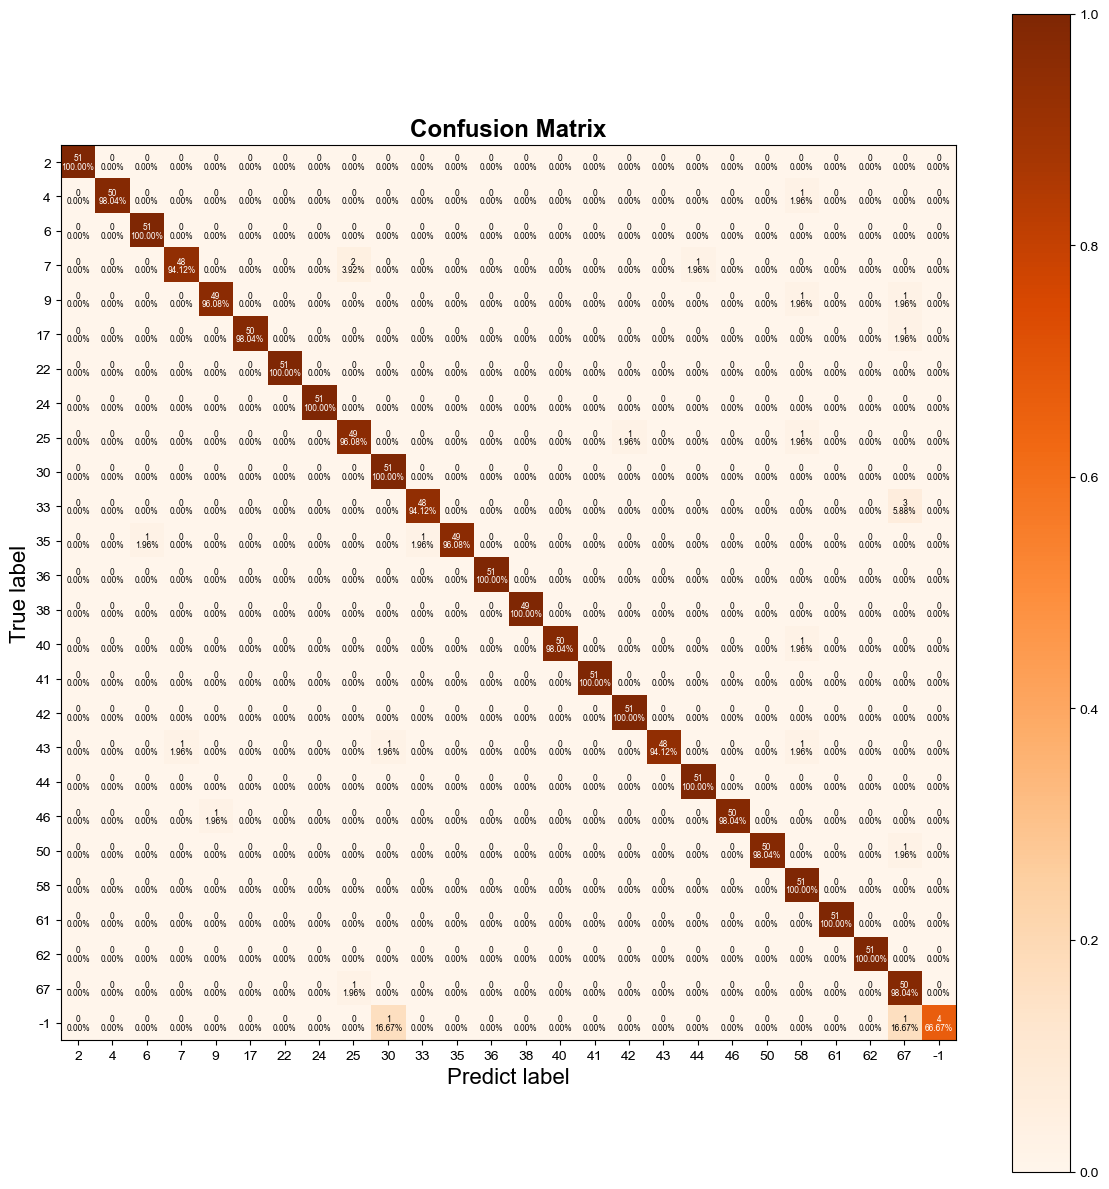

The accuracy of the model is 98.20%
The recall of the model is 98.82%
The precision of the model is 99.37%
The F1 of the model is 99.09%


In [34]:
p_label, p_acc, p_val = svm_predict(test_label, test_set, model,'-b 1')

prelabel(test,p_label)

confusion_matrix(test)

_,_,_,_ = score(test)

## Set C = 0.1

In [35]:
options = '-t 0 -c 0.1 -b 1' 
model = svm_train(train_label,train_set,options)

*
optimization finished, #iter = 91
nu = 0.161562
obj = -0.874078, rho = 0.918464
nSV = 32, nBSV = 3
Total nSV = 32
*
optimization finished, #iter = 76
nu = 0.151989
obj = -0.821729, rho = 0.914169
nSV = 27, nBSV = 3
Total nSV = 27
*
optimization finished, #iter = 88
nu = 0.167823
obj = -0.912366, rho = 0.902056
nSV = 32, nBSV = 3
Total nSV = 32
*
optimization finished, #iter = 70
nu = 0.168462
obj = -0.908037, rho = 0.899336
nSV = 29, nBSV = 5
Total nSV = 29
*
optimization finished, #iter = 76
nu = 0.154674
obj = -0.850377, rho = 0.918986
nSV = 28, nBSV = 4
Total nSV = 28
*
optimization finished, #iter = 113
nu = 0.144006
obj = -0.957993, rho = 0.903034
nSV = 33, nBSV = 2
*.*
optimization finished, #iter = 114
nu = 0.171535
obj = -0.922206, rho = 0.882542
nSV = 37, nBSV = 2
Total nSV = 37
*
optimization finished, #iter = 88
nu = 0.143303
obj = -0.787339, rho = 0.905104
nSV = 32, nBSV = 2
Total nSV = 32
*
optimization finished, #iter = 75
nu = 0.141113
obj = -0.772179, rho = 0.916065
n

*
optimization finished, #iter = 95
nu = 0.563361
obj = -8.425089, rho = -0.042928
nSV = 143, nBSV = 125
*
optimization finished, #iter = 91
nu = 0.674048
obj = -8.417556, rho = -0.009154
nSV = 135, nBSV = 121
Total nSV = 135
*
optimization finished, #iter = 120
nu = 0.678662
obj = -8.658055, rho = -0.016657
nSV = 137, nBSV = 118
Total nSV = 137
*
optimization finished, #iter = 95
nu = 0.668900
obj = -8.412823, rho = 0.118421
nSV = 138, nBSV = 119
Total nSV = 138
*
optimization finished, #iter = 120
nu = 0.671598
obj = -8.486014, rho = -0.116555
nSV = 139, nBSV = 117
Total nSV = 139
*
optimization finished, #iter = 93
nu = 0.676476
obj = -8.519828, rho = -0.034223
nSV = 138, nBSV = 122
Total nSV = 138
*
optimization finished, #iter = 112
nu = 0.614593
obj = -9.613841, rho = -0.018324
nSV = 157, nBSV = 139
*
optimization finished, #iter = 133
nu = 0.597206
obj = -7.195737, rho = -0.178866
nSV = 128, nBSV = 101
Total nSV = 128
*
optimization finished, #iter = 103
nu = 0.624666
obj = -7.6

*
optimization finished, #iter = 90
nu = 0.595019
obj = -7.302648, rho = -0.044268
nSV = 123, nBSV = 104
Total nSV = 123
*
optimization finished, #iter = 95
nu = 0.585865
obj = -7.095314, rho = -0.116898
nSV = 119, nBSV = 105
Total nSV = 119
*
optimization finished, #iter = 97
nu = 0.536473
obj = -8.112288, rho = -0.075035
nSV = 135, nBSV = 121
*
optimization finished, #iter = 109
nu = 0.621442
obj = -7.469727, rho = -0.114415
nSV = 128, nBSV = 109
Total nSV = 128
*
optimization finished, #iter = 109
nu = 0.590775
obj = -7.190075, rho = -0.140331
nSV = 126, nBSV = 101
Total nSV = 126
*
optimization finished, #iter = 95
nu = 0.616827
obj = -7.486799, rho = -0.099447
nSV = 128, nBSV = 111
Total nSV = 128
*
optimization finished, #iter = 119
nu = 0.613120
obj = -7.472973, rho = -0.057196
nSV = 127, nBSV = 104
Total nSV = 127
*
optimization finished, #iter = 93
nu = 0.594038
obj = -7.286632, rho = -0.103858
nSV = 122, nBSV = 107
Total nSV = 122
*
optimization finished, #iter = 123
nu = 0.5

*
optimization finished, #iter = 138
nu = 0.518071
obj = -7.814327, rho = 0.200294
nSV = 138, nBSV = 111
*
optimization finished, #iter = 122
nu = 0.548971
obj = -6.429175, rho = 0.099033
nSV = 120, nBSV = 95
Total nSV = 120
*
optimization finished, #iter = 131
nu = 0.558948
obj = -6.610798, rho = 0.057285
nSV = 118, nBSV = 92
Total nSV = 118
*
optimization finished, #iter = 120
nu = 0.541102
obj = -6.521942, rho = 0.102196
nSV = 117, nBSV = 92
Total nSV = 117
*
optimization finished, #iter = 145
nu = 0.544206
obj = -6.387737, rho = 0.019108
nSV = 118, nBSV = 88
Total nSV = 118
*
optimization finished, #iter = 144
nu = 0.563549
obj = -6.632587, rho = 0.054147
nSV = 122, nBSV = 93
Total nSV = 122
*
optimization finished, #iter = 175
nu = 0.489190
obj = -7.192921, rho = 0.061697
nSV = 133, nBSV = 104
*
optimization finished, #iter = 154
nu = 0.490663
obj = -5.584028, rho = -0.082093
nSV = 116, nBSV = 79
Total nSV = 116
*
optimization finished, #iter = 110
nu = 0.494929
obj = -5.605783, r

*
optimization finished, #iter = 90
nu = 0.534202
obj = -6.224993, rho = 0.052211
nSV = 111, nBSV = 91
Total nSV = 111
*
optimization finished, #iter = 98
nu = 0.555496
obj = -6.329227, rho = 0.019640
nSV = 115, nBSV = 92
Total nSV = 115
*
optimization finished, #iter = 131
nu = 0.480161
obj = -6.848344, rho = 0.020828
nSV = 129, nBSV = 98
*
optimization finished, #iter = 91
nu = 0.556955
obj = -6.559195, rho = 0.076282
nSV = 116, nBSV = 96
Total nSV = 116
*
optimization finished, #iter = 82
nu = 0.552602
obj = -6.497093, rho = 0.114025
nSV = 116, nBSV = 98
Total nSV = 116
*
optimization finished, #iter = 93
nu = 0.561528
obj = -6.658535, rho = 0.094389
nSV = 114, nBSV = 97
Total nSV = 114
*
optimization finished, #iter = 106
nu = 0.545527
obj = -6.430676, rho = 0.122187
nSV = 114, nBSV = 94
Total nSV = 114
*
optimization finished, #iter = 134
nu = 0.570850
obj = -6.706540, rho = 0.074758
nSV = 118, nBSV = 95
Total nSV = 118
*
optimization finished, #iter = 117
nu = 0.496983
obj = -7.2

*
optimization finished, #iter = 115
nu = 0.585928
obj = -7.125474, rho = -0.130904
nSV = 124, nBSV = 100
Total nSV = 124
*
optimization finished, #iter = 93
nu = 0.575443
obj = -6.927834, rho = -0.185163
nSV = 120, nBSV = 100
Total nSV = 120
*
optimization finished, #iter = 109
nu = 0.598214
obj = -7.241060, rho = -0.190107
nSV = 124, nBSV = 104
Total nSV = 124
*
optimization finished, #iter = 124
nu = 0.529121
obj = -7.929818, rho = -0.156506
nSV = 136, nBSV = 114
*
optimization finished, #iter = 117
nu = 0.550855
obj = -6.356211, rho = -0.094560
nSV = 117, nBSV = 89
Total nSV = 117
*
optimization finished, #iter = 131
nu = 0.529601
obj = -6.117278, rho = -0.141076
nSV = 115, nBSV = 88
Total nSV = 115
*
optimization finished, #iter = 119
nu = 0.541015
obj = -6.298223, rho = -0.060503
nSV = 118, nBSV = 90
Total nSV = 118
*
optimization finished, #iter = 145
nu = 0.555301
obj = -6.493942, rho = -0.146951
nSV = 121, nBSV = 92
Total nSV = 121
*
optimization finished, #iter = 131
nu = 0.5

*
optimization finished, #iter = 147
nu = 0.506850
obj = -5.887170, rho = -0.227097
nSV = 111, nBSV = 82
Total nSV = 111
*
optimization finished, #iter = 178
nu = 0.444919
obj = -6.468250, rho = -0.210404
nSV = 122, nBSV = 88
*
optimization finished, #iter = 91
nu = 0.582959
obj = -7.149380, rho = -0.100411
nSV = 122, nBSV = 105
Total nSV = 122
*
optimization finished, #iter = 106
nu = 0.584460
obj = -7.026205, rho = -0.029076
nSV = 121, nBSV = 100
Total nSV = 121
*
optimization finished, #iter = 92
nu = 0.572311
obj = -6.837434, rho = -0.067079
nSV = 119, nBSV = 100
Total nSV = 119
*
optimization finished, #iter = 110
nu = 0.595678
obj = -7.144536, rho = 0.057709
nSV = 125, nBSV = 102
Total nSV = 125
*
optimization finished, #iter = 116
nu = 0.599796
obj = -7.148858, rho = -0.021066
nSV = 124, nBSV = 101
Total nSV = 124
*
optimization finished, #iter = 135
nu = 0.531189
obj = -7.840181, rho = -0.035739
nSV = 138, nBSV = 113
*
optimization finished, #iter = 102
nu = 0.586337
obj = -7.2

*
optimization finished, #iter = 111
nu = 0.564149
obj = -8.415112, rho = -0.103405
nSV = 147, nBSV = 123
*
optimization finished, #iter = 111
nu = 0.595995
obj = -7.211363, rho = -0.137757
nSV = 126, nBSV = 105
Total nSV = 126
*
optimization finished, #iter = 119
nu = 0.617253
obj = -7.341231, rho = -0.092093
nSV = 130, nBSV = 105
Total nSV = 130
*
optimization finished, #iter = 116
nu = 0.607490
obj = -7.254473, rho = -0.123034
nSV = 129, nBSV = 106
Total nSV = 129
*
optimization finished, #iter = 106
nu = 0.600280
obj = -7.080800, rho = -0.165314
nSV = 125, nBSV = 101
Total nSV = 125
*
optimization finished, #iter = 106
nu = 0.604756
obj = -7.230662, rho = -0.082470
nSV = 129, nBSV = 107
Total nSV = 129
*
optimization finished, #iter = 123
nu = 0.542139
obj = -7.996164, rho = -0.131657
nSV = 142, nBSV = 115
*
optimization finished, #iter = 117
nu = 0.585263
obj = -6.856412, rho = -0.172636
nSV = 126, nBSV = 103
Total nSV = 126
*
optimization finished, #iter = 128
nu = 0.572736
obj =

*
optimization finished, #iter = 119
nu = 0.621108
obj = -7.766395, rho = -0.115092
nSV = 126, nBSV = 106
Total nSV = 126
*
optimization finished, #iter = 94
nu = 0.625808
obj = -7.797508, rho = -0.106252
nSV = 127, nBSV = 109
Total nSV = 127
*
optimization finished, #iter = 100
nu = 0.601123
obj = -7.376305, rho = -0.139815
nSV = 125, nBSV = 106
Total nSV = 125
*
optimization finished, #iter = 96
nu = 0.602669
obj = -7.457980, rho = -0.161825
nSV = 127, nBSV = 107
Total nSV = 127
*
optimization finished, #iter = 127
nu = 0.624948
obj = -7.768738, rho = -0.076660
nSV = 129, nBSV = 107
Total nSV = 129
*
optimization finished, #iter = 140
nu = 0.557033
obj = -8.573280, rho = -0.135399
nSV = 146, nBSV = 119
*
optimization finished, #iter = 126
nu = 0.601862
obj = -7.488148, rho = -0.107075
nSV = 128, nBSV = 101
Total nSV = 128
*
optimization finished, #iter = 122
nu = 0.614783
obj = -7.689195, rho = -0.060322
nSV = 130, nBSV = 105
Total nSV = 130
*
optimization finished, #iter = 163
nu = 

*
optimization finished, #iter = 113
nu = 0.591506
obj = -7.075299, rho = 0.007227
nSV = 126, nBSV = 101
Total nSV = 126
*
optimization finished, #iter = 99
nu = 0.590937
obj = -7.102734, rho = 0.085843
nSV = 123, nBSV = 101
Total nSV = 123
*
optimization finished, #iter = 117
nu = 0.532871
obj = -7.990552, rho = 0.035328
nSV = 135, nBSV = 116
*
optimization finished, #iter = 130
nu = 0.544606
obj = -6.508395, rho = -0.056367
nSV = 119, nBSV = 89
Total nSV = 119
*
optimization finished, #iter = 83
nu = 0.548166
obj = -6.513178, rho = -0.055089
nSV = 114, nBSV = 95
Total nSV = 114
*
optimization finished, #iter = 118
nu = 0.549049
obj = -6.582849, rho = -0.118763
nSV = 122, nBSV = 94
Total nSV = 122
*
optimization finished, #iter = 99
nu = 0.538499
obj = -6.406358, rho = 0.077836
nSV = 117, nBSV = 92
Total nSV = 117
*
optimization finished, #iter = 109
nu = 0.555540
obj = -6.631698, rho = -0.064408
nSV = 117, nBSV = 95
Total nSV = 117
*
optimization finished, #iter = 102
nu = 0.490764
o

*
optimization finished, #iter = 116
nu = 0.508188
obj = -6.039332, rho = 0.197459
nSV = 113, nBSV = 83
Total nSV = 113
*
optimization finished, #iter = 126
nu = 0.523176
obj = -5.987585, rho = 0.184429
nSV = 118, nBSV = 85
Total nSV = 118
*
optimization finished, #iter = 148
nu = 0.536972
obj = -6.204377, rho = 0.143749
nSV = 119, nBSV = 85
Total nSV = 119
*
optimization finished, #iter = 146
nu = 0.459439
obj = -6.612526, rho = 0.152364
nSV = 127, nBSV = 93
*
optimization finished, #iter = 130
nu = 0.538809
obj = -6.233823, rho = 0.045824
nSV = 118, nBSV = 86
Total nSV = 118
*
optimization finished, #iter = 143
nu = 0.524113
obj = -6.133071, rho = 0.041187
nSV = 115, nBSV = 85
Total nSV = 115
*
optimization finished, #iter = 141
nu = 0.517009
obj = -6.024220, rho = 0.181051
nSV = 114, nBSV = 82
Total nSV = 114
*
optimization finished, #iter = 137
nu = 0.542350
obj = -6.288502, rho = 0.095591
nSV = 119, nBSV = 88
Total nSV = 119
*
optimization finished, #iter = 114
nu = 0.515597
obj =

*
optimization finished, #iter = 98
nu = 0.524381
obj = -6.076498, rho = -0.154544
nSV = 109, nBSV = 89
Total nSV = 109
*
optimization finished, #iter = 122
nu = 0.502047
obj = -5.729850, rho = -0.023480
nSV = 109, nBSV = 82
Total nSV = 109
*
optimization finished, #iter = 128
nu = 0.517595
obj = -6.020816, rho = -0.007643
nSV = 110, nBSV = 85
Total nSV = 110
*
optimization finished, #iter = 106
nu = 0.508171
obj = -6.021479, rho = -0.025667
nSV = 112, nBSV = 86
Total nSV = 112
*
optimization finished, #iter = 122
nu = 0.459433
obj = -6.593679, rho = -0.061693
nSV = 121, nBSV = 95
*
optimization finished, #iter = 102
nu = 0.510925
obj = -6.002953, rho = 0.034481
nSV = 111, nBSV = 85
Total nSV = 111
*
optimization finished, #iter = 128
nu = 0.503081
obj = -5.901945, rho = 0.076599
nSV = 112, nBSV = 82
Total nSV = 112
*
optimization finished, #iter = 131
nu = 0.493689
obj = -5.708104, rho = 0.040504
nSV = 108, nBSV = 76
Total nSV = 108
*
optimization finished, #iter = 114
nu = 0.480740
o

*
optimization finished, #iter = 87
nu = 0.653296
obj = -8.500096, rho = -0.117313
nSV = 135, nBSV = 120
Total nSV = 135
*
optimization finished, #iter = 102
nu = 0.661757
obj = -8.576572, rho = -0.076630
nSV = 132, nBSV = 118
Total nSV = 132
*
optimization finished, #iter = 94
nu = 0.665263
obj = -8.452820, rho = -0.045490
nSV = 135, nBSV = 119
Total nSV = 135
*
optimization finished, #iter = 90
nu = 0.669640
obj = -8.500086, rho = -0.058852
nSV = 134, nBSV = 121
Total nSV = 134
*
optimization finished, #iter = 90
nu = 0.655464
obj = -8.481885, rho = -0.074756
nSV = 132, nBSV = 119
Total nSV = 132
*
optimization finished, #iter = 98
nu = 0.605785
obj = -9.629861, rho = -0.038288
nSV = 150, nBSV = 137
*
optimization finished, #iter = 147
nu = 0.515826
obj = -6.232283, rho = -0.138406
nSV = 113, nBSV = 84
Total nSV = 113
*
optimization finished, #iter = 100
nu = 0.537721
obj = -6.536785, rho = -0.109751
nSV = 114, nBSV = 89
Total nSV = 114
*
optimization finished, #iter = 112
nu = 0.526

*
optimization finished, #iter = 112
nu = 0.456593
obj = -6.591886, rho = -0.005286
nSV = 122, nBSV = 97
*
optimization finished, #iter = 100
nu = 0.544473
obj = -6.389103, rho = -0.036169
nSV = 115, nBSV = 90
Total nSV = 115
*
optimization finished, #iter = 87
nu = 0.543962
obj = -6.229546, rho = -0.041819
nSV = 111, nBSV = 91
Total nSV = 111
*
optimization finished, #iter = 109
nu = 0.531141
obj = -6.176599, rho = 0.063490
nSV = 108, nBSV = 88
Total nSV = 108
*
optimization finished, #iter = 108
nu = 0.529682
obj = -6.121318, rho = -0.048172
nSV = 115, nBSV = 90
Total nSV = 115
*
optimization finished, #iter = 99
nu = 0.538517
obj = -6.219557, rho = -0.064558
nSV = 111, nBSV = 90
Total nSV = 111
*
optimization finished, #iter = 132
nu = 0.476593
obj = -6.880745, rho = -0.046020
nSV = 125, nBSV = 99
*
optimization finished, #iter = 81
nu = 0.563929
obj = -6.928554, rho = 0.084774
nSV = 114, nBSV = 101
Total nSV = 114
*
optimization finished, #iter = 87
nu = 0.563376
obj = -6.901860, r

*
optimization finished, #iter = 160
nu = 0.529509
obj = -6.161895, rho = 0.117436
nSV = 121, nBSV = 86
Total nSV = 121
*
optimization finished, #iter = 112
nu = 0.529467
obj = -6.139641, rho = 0.099287
nSV = 113, nBSV = 92
Total nSV = 113
*
optimization finished, #iter = 133
nu = 0.524630
obj = -6.150542, rho = 0.215474
nSV = 115, nBSV = 86
Total nSV = 115
*
optimization finished, #iter = 120
nu = 0.472779
obj = -6.832211, rho = 0.136607
nSV = 128, nBSV = 102
*
optimization finished, #iter = 121
nu = 0.553977
obj = -6.619736, rho = 0.021107
nSV = 120, nBSV = 93
Total nSV = 120
*
optimization finished, #iter = 124
nu = 0.558368
obj = -6.590051, rho = 0.139832
nSV = 125, nBSV = 94
Total nSV = 125
*
optimization finished, #iter = 141
nu = 0.565476
obj = -6.634138, rho = 0.083569
nSV = 123, nBSV = 92
Total nSV = 123
*
optimization finished, #iter = 130
nu = 0.548669
obj = -6.452203, rho = 0.078755
nSV = 122, nBSV = 87
Total nSV = 122
*
optimization finished, #iter = 131
nu = 0.557723
obj 

*
optimization finished, #iter = 152
nu = 0.489949
obj = -7.268621, rho = 0.103378
nSV = 134, nBSV = 101
*
optimization finished, #iter = 126
nu = 0.529865
obj = -6.212532, rho = -0.093899
nSV = 116, nBSV = 90
Total nSV = 116
*
optimization finished, #iter = 141
nu = 0.549328
obj = -6.558511, rho = -0.031218
nSV = 119, nBSV = 90
Total nSV = 119
*
optimization finished, #iter = 124
nu = 0.548017
obj = -6.504804, rho = -0.064797
nSV = 114, nBSV = 90
Total nSV = 114
*
optimization finished, #iter = 97
nu = 0.531333
obj = -6.334261, rho = 0.030932
nSV = 115, nBSV = 91
Total nSV = 115
*
optimization finished, #iter = 136
nu = 0.543956
obj = -6.408383, rho = -0.070285
nSV = 117, nBSV = 89
Total nSV = 117
*
optimization finished, #iter = 127
nu = 0.483069
obj = -7.106349, rho = -0.063029
nSV = 131, nBSV = 101
*
optimization finished, #iter = 147
nu = 0.502575
obj = -5.775858, rho = 0.074496
nSV = 115, nBSV = 82
Total nSV = 115
*
optimization finished, #iter = 144
nu = 0.520777
obj = -5.885450

*
optimization finished, #iter = 132
nu = 0.508940
obj = -7.706275, rho = -0.077474
nSV = 136, nBSV = 109
*
optimization finished, #iter = 107
nu = 0.540194
obj = -6.267080, rho = -0.263685
nSV = 115, nBSV = 91
Total nSV = 115
*
optimization finished, #iter = 166
nu = 0.521605
obj = -5.973958, rho = -0.266447
nSV = 115, nBSV = 82
Total nSV = 115
*
optimization finished, #iter = 120
nu = 0.529018
obj = -6.238816, rho = -0.231798
nSV = 114, nBSV = 86
Total nSV = 114
*
optimization finished, #iter = 185
nu = 0.496344
obj = -5.711503, rho = -0.233368
nSV = 116, nBSV = 79
Total nSV = 116
*
optimization finished, #iter = 105
nu = 0.531394
obj = -6.242148, rho = -0.103962
nSV = 115, nBSV = 91
Total nSV = 115
*
optimization finished, #iter = 141
nu = 0.467280
obj = -6.733110, rho = -0.220908
nSV = 125, nBSV = 93
*
optimization finished, #iter = 113
nu = 0.620216
obj = -7.448735, rho = -0.036987
nSV = 128, nBSV = 105
Total nSV = 128
*
optimization finished, #iter = 122
nu = 0.598773
obj = -7.17

*
optimization finished, #iter = 142
nu = 0.522222
obj = -7.849524, rho = -0.108868
nSV = 139, nBSV = 108
*
optimization finished, #iter = 136
nu = 0.586068
obj = -6.939533, rho = -0.048405
nSV = 123, nBSV = 97
Total nSV = 123
*
optimization finished, #iter = 112
nu = 0.591253
obj = -7.005357, rho = -0.037034
nSV = 125, nBSV = 100
Total nSV = 125
*
optimization finished, #iter = 120
nu = 0.580585
obj = -6.923625, rho = 0.035958
nSV = 123, nBSV = 98
Total nSV = 123
*
optimization finished, #iter = 107
nu = 0.600318
obj = -7.069643, rho = 0.006089
nSV = 124, nBSV = 103
Total nSV = 124
*
optimization finished, #iter = 130
nu = 0.580054
obj = -6.902690, rho = 0.002465
nSV = 123, nBSV = 97
Total nSV = 123
*
optimization finished, #iter = 132
nu = 0.525721
obj = -7.737623, rho = -0.004984
nSV = 141, nBSV = 112
*
optimization finished, #iter = 145
nu = 0.582412
obj = -6.948215, rho = -0.117164
nSV = 127, nBSV = 98
Total nSV = 127
*
optimization finished, #iter = 136
nu = 0.564012
obj = -6.825

*
optimization finished, #iter = 122
nu = 0.514766
obj = -5.859773, rho = 0.023875
nSV = 113, nBSV = 86
Total nSV = 113
*
optimization finished, #iter = 123
nu = 0.526935
obj = -5.928034, rho = -0.014916
nSV = 118, nBSV = 86
Total nSV = 118
*
optimization finished, #iter = 130
nu = 0.511192
obj = -5.784576, rho = -0.003656
nSV = 115, nBSV = 83
Total nSV = 115
*
optimization finished, #iter = 162
nu = 0.453195
obj = -6.364095, rho = -0.007193
nSV = 127, nBSV = 93
*
optimization finished, #iter = 140
nu = 0.593043
obj = -7.176321, rho = -0.040184
nSV = 126, nBSV = 98
Total nSV = 126
*
optimization finished, #iter = 115
nu = 0.610960
obj = -7.238192, rho = 0.082846
nSV = 128, nBSV = 105
Total nSV = 128
*
optimization finished, #iter = 128
nu = 0.609329
obj = -7.441032, rho = 0.086100
nSV = 127, nBSV = 102
Total nSV = 127
*
optimization finished, #iter = 115
nu = 0.606349
obj = -7.359863, rho = 0.047438
nSV = 127, nBSV = 103
Total nSV = 127
*
optimization finished, #iter = 100
nu = 0.60299

*
optimization finished, #iter = 103
nu = 0.565692
obj = -6.633602, rho = 0.083373
nSV = 120, nBSV = 95
Total nSV = 120
*
optimization finished, #iter = 110
nu = 0.576561
obj = -6.770789, rho = 0.082159
nSV = 121, nBSV = 100
Total nSV = 121
*
optimization finished, #iter = 129
nu = 0.584012
obj = -6.894177, rho = 0.123430
nSV = 126, nBSV = 101
Total nSV = 126
*
optimization finished, #iter = 121
nu = 0.585321
obj = -6.803097, rho = 0.095415
nSV = 127, nBSV = 94
Total nSV = 127
*
optimization finished, #iter = 129
nu = 0.585367
obj = -6.904625, rho = 0.077776
nSV = 123, nBSV = 99
Total nSV = 123
*
optimization finished, #iter = 142
nu = 0.510197
obj = -7.473529, rho = 0.112854
nSV = 139, nBSV = 109
*
optimization finished, #iter = 114
nu = 0.568618
obj = -6.782248, rho = 0.073642
nSV = 121, nBSV = 97
Total nSV = 121
*
optimization finished, #iter = 144
nu = 0.553194
obj = -6.452712, rho = 0.001414
nSV = 121, nBSV = 94
Total nSV = 121
*
optimization finished, #iter = 117
nu = 0.549709
ob

*
optimization finished, #iter = 123
nu = 0.547085
obj = -6.417861, rho = 0.073226
nSV = 117, nBSV = 91
Total nSV = 117
*
optimization finished, #iter = 114
nu = 0.478565
obj = -6.939889, rho = 0.083765
nSV = 126, nBSV = 104
*
optimization finished, #iter = 149
nu = 0.512325
obj = -5.850454, rho = -0.115112
nSV = 111, nBSV = 79
Total nSV = 111
*
optimization finished, #iter = 138
nu = 0.526787
obj = -5.860193, rho = -0.033968
nSV = 113, nBSV = 78
Total nSV = 113
*.*
optimization finished, #iter = 196
nu = 0.521199
obj = -5.851818, rho = -0.094137
nSV = 116, nBSV = 79
Total nSV = 116
*
optimization finished, #iter = 141
nu = 0.531398
obj = -5.988675, rho = -0.080459
nSV = 112, nBSV = 79
Total nSV = 112
*
optimization finished, #iter = 181
nu = 0.518825
obj = -5.766541, rho = -0.085357
nSV = 118, nBSV = 80
Total nSV = 118
*
optimization finished, #iter = 167
nu = 0.457314
obj = -6.393946, rho = -0.061111
nSV = 126, nBSV = 91
*
optimization finished, #iter = 128
nu = 0.556564
obj = -6.541

*
optimization finished, #iter = 157
nu = 0.533975
obj = -8.094815, rho = -0.021444
nSV = 141, nBSV = 112
*
optimization finished, #iter = 115
nu = 0.544635
obj = -6.345165, rho = -0.158931
nSV = 113, nBSV = 91
Total nSV = 113
*
optimization finished, #iter = 83
nu = 0.560725
obj = -6.704602, rho = -0.110834
nSV = 114, nBSV = 99
Total nSV = 114
*
optimization finished, #iter = 97
nu = 0.541122
obj = -6.421842, rho = -0.202138
nSV = 112, nBSV = 93
Total nSV = 112
*
optimization finished, #iter = 90
nu = 0.539207
obj = -6.380976, rho = -0.129443
nSV = 112, nBSV = 92
Total nSV = 112
*
optimization finished, #iter = 116
nu = 0.545520
obj = -6.361977, rho = -0.161608
nSV = 115, nBSV = 95
Total nSV = 115
*
optimization finished, #iter = 128
nu = 0.486165
obj = -7.110248, rho = -0.153117
nSV = 126, nBSV = 104
*
optimization finished, #iter = 86
nu = 0.554479
obj = -6.754931, rho = -0.050048
nSV = 113, nBSV = 97
Total nSV = 113
*
optimization finished, #iter = 107
nu = 0.549803
obj = -6.743737

*
optimization finished, #iter = 87
nu = 0.551447
obj = -6.512360, rho = 0.051961
nSV = 116, nBSV = 98
Total nSV = 116
*
optimization finished, #iter = 111
nu = 0.566946
obj = -6.754054, rho = 0.053789
nSV = 120, nBSV = 95
Total nSV = 120
*
optimization finished, #iter = 93
nu = 0.552063
obj = -6.570203, rho = 0.049322
nSV = 116, nBSV = 94
Total nSV = 116
*
optimization finished, #iter = 103
nu = 0.547609
obj = -6.464753, rho = 0.143083
nSV = 115, nBSV = 92
Total nSV = 115
*
optimization finished, #iter = 98
nu = 0.545281
obj = -6.422319, rho = 0.125817
nSV = 113, nBSV = 91
Total nSV = 113
*
optimization finished, #iter = 121
nu = 0.492616
obj = -7.243834, rho = 0.083339
nSV = 134, nBSV = 104
*
optimization finished, #iter = 115
nu = 0.549894
obj = -6.478313, rho = 0.058447
nSV = 117, nBSV = 92
Total nSV = 117
*
optimization finished, #iter = 159
nu = 0.544717
obj = -6.449868, rho = -0.042785
nSV = 118, nBSV = 90
Total nSV = 118
*
optimization finished, #iter = 117
nu = 0.533698
obj = 

*
optimization finished, #iter = 94
nu = 0.521350
obj = -6.188113, rho = -0.141471
nSV = 109, nBSV = 89
Total nSV = 109
*
optimization finished, #iter = 111
nu = 0.454846
obj = -6.717810, rho = -0.153464
nSV = 123, nBSV = 97
*
optimization finished, #iter = 122
nu = 0.624961
obj = -7.623681, rho = -0.119315
nSV = 130, nBSV = 106
Total nSV = 130
*
optimization finished, #iter = 92
nu = 0.622896
obj = -7.659581, rho = -0.049710
nSV = 127, nBSV = 110
Total nSV = 127
*
optimization finished, #iter = 110
nu = 0.627229
obj = -7.660848, rho = -0.151164
nSV = 130, nBSV = 108
Total nSV = 130
*
optimization finished, #iter = 89
nu = 0.629030
obj = -7.752600, rho = -0.035075
nSV = 128, nBSV = 112
Total nSV = 128
*
optimization finished, #iter = 91
nu = 0.628233
obj = -7.702936, rho = -0.114827
nSV = 130, nBSV = 109
Total nSV = 130
*
optimization finished, #iter = 117
nu = 0.567764
obj = -8.595577, rho = -0.094699
nSV = 146, nBSV = 123
*
optimization finished, #iter = 110
nu = 0.583432
obj = -7.02

*
optimization finished, #iter = 141
nu = 0.574769
obj = -6.834778, rho = 0.183508
nSV = 123, nBSV = 92
Total nSV = 123
*
optimization finished, #iter = 122
nu = 0.583117
obj = -7.199184, rho = 0.230883
nSV = 129, nBSV = 99
Total nSV = 129
*
optimization finished, #iter = 134
nu = 0.524197
obj = -7.833696, rho = 0.205356
nSV = 140, nBSV = 109
*
optimization finished, #iter = 107
nu = 0.570033
obj = -6.981859, rho = -0.023603
nSV = 122, nBSV = 99
Total nSV = 122
*
optimization finished, #iter = 114
nu = 0.571034
obj = -6.941684, rho = -0.030252
nSV = 120, nBSV = 96
Total nSV = 120
*
optimization finished, #iter = 130
nu = 0.546582
obj = -6.599902, rho = -0.040193
nSV = 116, nBSV = 87
Total nSV = 116
*
optimization finished, #iter = 125
nu = 0.550701
obj = -6.733907, rho = -0.082845
nSV = 118, nBSV = 93
Total nSV = 118
*
optimization finished, #iter = 105
nu = 0.566463
obj = -6.793865, rho = -0.033243
nSV = 118, nBSV = 98
Total nSV = 118
*
optimization finished, #iter = 155
nu = 0.509925

Accuracy = 97.1853% (1243/1279) (classification)


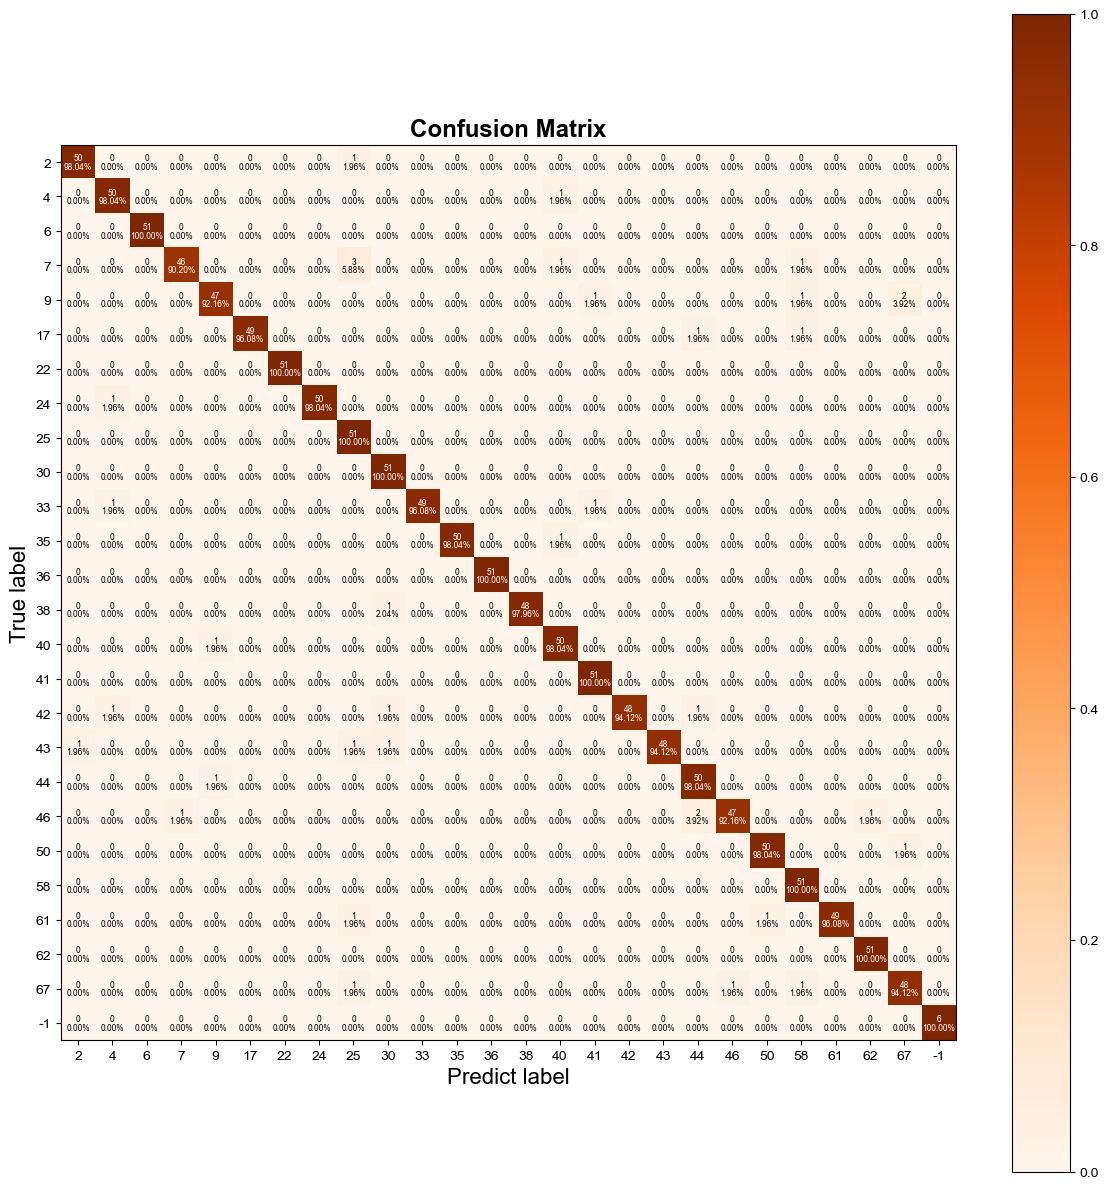

The accuracy of the model is 97.19%
The recall of the model is 98.57%
The precision of the model is 98.57%
The F1 of the model is 98.57%


In [36]:
p_label, p_acc, p_val = svm_predict(test_label, test_set, model,'-b 1')

prelabel(test,p_label)

confusion_matrix(test)

_,_,_,_ = score(test)

## Set C = 0.01

In [37]:
options = '-t 0 -c 0.01 -b 1' 
model = svm_train(train_label,train_set,options)

*
optimization finished, #iter = 41
nu = 0.205607
obj = -0.206068, rho = 0.987330
nSV = 30, nBSV = 15
Total nSV = 30
*
optimization finished, #iter = 36
nu = 0.226415
obj = -0.223323, rho = 0.985820
nSV = 31, nBSV = 19
Total nSV = 31
*
optimization finished, #iter = 37
nu = 0.205607
obj = -0.206284, rho = 0.987190
nSV = 29, nBSV = 17
Total nSV = 29
*
optimization finished, #iter = 29
nu = 0.169811
obj = -0.170033, rho = 0.989714
nSV = 26, nBSV = 13
Total nSV = 26
*
optimization finished, #iter = 32
nu = 0.245283
obj = -0.241697, rho = 0.986695
nSV = 32, nBSV = 21
Total nSV = 32
*
optimization finished, #iter = 42
nu = 0.210526
obj = -0.259091, rho = 0.984311
nSV = 36, nBSV = 23
*
optimization finished, #iter = 54
nu = 0.205607
obj = -0.205477, rho = 0.987522
nSV = 35, nBSV = 12
Total nSV = 35
*
optimization finished, #iter = 50
nu = 0.207547
obj = -0.206427, rho = 0.985412
nSV = 33, nBSV = 15
Total nSV = 33
*
optimization finished, #iter = 48
nu = 0.205607
obj = -0.205252, rho = 0.9851

*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.061546, rho = -0.036603
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 0.984293
obj = -1.698900, rho = -0.631849
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 99
nu = 0.957895
obj = -1.656282, rho = -0.738531
nSV = 183, nBSV = 180
Total nSV = 183
*
optimization finished, #iter = 99
nu = 0.984293
obj = -1.701704, rho = 0.644968
nSV = 190, nBSV = 187
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.989474
obj = -1.688042, rho = 0.607231
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 94
nu = 0.968421
obj = -1.668320, rho = 0.699880
nSV = 184, nBSV = 184
Total nSV = 184
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.082138, rho = 0.030713
nSV = 238, nBSV = 238
*
optimization finished, #iter = 102
nu = 0.952880
obj = -1.692965, rho = 0.776543
nSV = 184, nBSV = 181
Total nSV = 184
*
optimization finished, #iter = 93
nu = 0.936842
obj = -1.654405,

*
optimization finished, #iter = 97
nu = 0.968421
obj = -1.650617, rho = 0.608143
nSV = 186, nBSV = 183
Total nSV = 186
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.057858, rho = -0.036412
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.708610, rho = 0.559080
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.989474
obj = -1.692823, rho = 0.576018
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 96
nu = 0.984293
obj = -1.691071, rho = 0.582863
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 92
nu = 0.968421
obj = -1.659704, rho = -0.722174
nSV = 184, nBSV = 184
Total nSV = 184
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.697885, rho = -0.013776
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.072867, rho = -0.022098
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 0.973822
obj = -1.673606,

*
optimization finished, #iter = 96
nu = 0.957895
obj = -1.638700, rho = -0.703274
nSV = 184, nBSV = 180
Total nSV = 184
*
optimization finished, #iter = 102
nu = 0.952880
obj = -1.637834, rho = 0.745568
nSV = 184, nBSV = 179
Total nSV = 184
*
optimization finished, #iter = 96
nu = 0.978947
obj = -1.666704, rho = -0.655288
nSV = 188, nBSV = 185
Total nSV = 188
*
optimization finished, #iter = 94
nu = 0.978947
obj = -1.664193, rho = 0.696393
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.058697, rho = 0.017604
nSV = 238, nBSV = 238
*
optimization finished, #iter = 99
nu = 0.984293
obj = -1.645003, rho = 0.603252
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 101
nu = 0.989474
obj = -1.642686, rho = 0.592113
nSV = 190, nBSV = 185
Total nSV = 190
*
optimization finished, #iter = 105
nu = 0.973822
obj = -1.625328, rho = 0.645629
nSV = 189, nBSV = 182
Total nSV = 189
*
optimization finished, #iter = 95
nu = 1.000000


*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.682256, rho = 0.001940
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.978947
obj = -1.653614, rho = 0.640055
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.035945, rho = -0.050058
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.691254, rho = -0.618604
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.667101, rho = 0.617561
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 98
nu = 0.994764
obj = -1.677658, rho = 0.595420
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.678889, rho = -0.003398
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 98
nu = 0.989474
obj = -1.672331, rho = -0.594564
nSV = 190, nBSV = 187
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000


*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.713535, rho = -0.675692
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.093307, rho = 0.013902
nSV = 238, nBSV = 238
*
optimization finished, #iter = 101
nu = 0.984293
obj = -1.683051, rho = 0.587301
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.683681, rho = -0.610116
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 95
nu = 0.984293
obj = -1.682437, rho = -0.642756
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 98
nu = 0.978947
obj = -1.664310, rho = 0.619535
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.693196, rho = -0.672004
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.062194, rho = -0.013112
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 0.984293
obj = -1.66115

*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.651737, rho = -0.048397
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 105
nu = 0.984293
obj = -1.644040, rho = 0.561912
nSV = 190, nBSV = 184
Total nSV = 190
*
optimization finished, #iter = 94
nu = 0.978947
obj = -1.628372, rho = -0.670858
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 96
nu = 0.978947
obj = -1.641051, rho = -0.709759
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.000194, rho = -0.043295
nSV = 238, nBSV = 238
*
optimization finished, #iter = 103
nu = 0.963351
obj = -1.657842, rho = 0.650900
nSV = 186, nBSV = 182
Total nSV = 186
*
optimization finished, #iter = 96
nu = 0.957895
obj = -1.640393, rho = -0.695608
nSV = 185, nBSV = 180
Total nSV = 185
*
optimization finished, #iter = 101
nu = 0.952880
obj = -1.630117, rho = 0.653013
nSV = 185, nBSV = 180
Total nSV = 185
*
optimization finished, #iter = 97
nu = 0.9684

*
optimization finished, #iter = 97
nu = 0.978947
obj = -1.686459, rho = 0.682255
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 95
nu = 0.968421
obj = -1.678835, rho = -0.729661
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.101389, rho = -0.000121
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.711879, rho = -0.651385
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 96
nu = 0.968421
obj = -1.656121, rho = -0.703982
nSV = 187, nBSV = 181
Total nSV = 187
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.703213, rho = 0.581813
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 101
nu = 0.957895
obj = -1.654089, rho = 0.689102
nSV = 185, nBSV = 180
Total nSV = 185
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.696990, rho = -0.622037
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.00000

*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.050104, rho = -0.063822
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.973822
obj = -1.687948, rho = -0.694048
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.709025, rho = 0.005760
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 99
nu = 0.963351
obj = -1.674090, rho = 0.708397
nSV = 186, nBSV = 180
Total nSV = 186
*
optimization finished, #iter = 94
nu = 0.978947
obj = -1.683574, rho = 0.648168
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 93
nu = 0.968421
obj = -1.679224, rho = -0.714798
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.089554, rho = 0.012561
nSV = 238, nBSV = 238
*
optimization finished, #iter = 97
nu = 0.963351
obj = -1.662085, rho = -0.741931
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 104
nu = 0.978947
obj = -1.691686

*
optimization finished, #iter = 97
nu = 0.957895
obj = -1.648765, rho = -0.739190
nSV = 185, nBSV = 179
Total nSV = 185
*
optimization finished, #iter = 97
nu = 0.957895
obj = -1.639456, rho = 0.681704
nSV = 183, nBSV = 181
Total nSV = 183
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.066485, rho = -0.033708
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.670972, rho = 0.526485
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.978947
obj = -1.644952, rho = -0.680608
nSV = 187, nBSV = 183
Total nSV = 187
*
optimization finished, #iter = 100
nu = 0.963351
obj = -1.637755, rho = -0.690412
nSV = 188, nBSV = 180
Total nSV = 188
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.678818, rho = -0.008666
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 99
nu = 0.947368
obj = -1.623448, rho = 0.699555
nSV = 183, nBSV = 178
Total nSV = 183
*
optimization finished, #iter = 119
nu = 1.00000

*
optimization finished, #iter = 97
nu = 0.973822
obj = -1.635670, rho = -0.583442
nSV = 188, nBSV = 184
Total nSV = 188
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.651189, rho = 0.025545
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 102
nu = 0.973822
obj = -1.641374, rho = 0.645676
nSV = 188, nBSV = 184
Total nSV = 188
*
optimization finished, #iter = 96
nu = 0.978947
obj = -1.629744, rho = 0.643800
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 95
nu = 0.978947
obj = -1.638525, rho = -0.602852
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.007269, rho = 0.027999
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.669013, rho = -0.563763
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 101
nu = 0.968421
obj = -1.618344, rho = 0.661720
nSV = 187, nBSV = 182
Total nSV = 187
*
optimization finished, #iter = 99
nu = 0.994764


*
optimization finished, #iter = 98
nu = 0.968421
obj = -1.654223, rho = 0.700635
nSV = 186, nBSV = 183
Total nSV = 186
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.671854, rho = -0.551517
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 103
nu = 0.968421
obj = -1.643652, rho = -0.661002
nSV = 187, nBSV = 181
Total nSV = 187
*
optimization finished, #iter = 101
nu = 0.968421
obj = -1.631039, rho = 0.677954
nSV = 186, nBSV = 180
Total nSV = 186
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.036812, rho = -0.050514
nSV = 238, nBSV = 238
*
optimization finished, #iter = 99
nu = 0.984293
obj = -1.644823, rho = 0.611755
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 98
nu = 0.978947
obj = -1.635024, rho = -0.636000
nSV = 188, nBSV = 182
Total nSV = 188
*
optimization finished, #iter = 100
nu = 0.963351
obj = -1.601513, rho = 0.630073
nSV = 186, nBSV = 183
Total nSV = 186
*
optimization finished, #iter = 94
nu = 0.98947

*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.687971, rho = -0.657086
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 94
nu = 0.973822
obj = -1.669577, rho = -0.691935
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 101
nu = 0.978947
obj = -1.679121, rho = 0.604587
nSV = 188, nBSV = 185
Total nSV = 188
*
optimization finished, #iter = 98
nu = 0.957895
obj = -1.653588, rho = -0.738859
nSV = 185, nBSV = 181
Total nSV = 185
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.068724, rho = -0.083685
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.984293
obj = -1.660420, rho = 0.573639
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 97
nu = 0.989474
obj = -1.664501, rho = -0.671991
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 95
nu = 0.963351
obj = -1.635041, rho = -0.703061
nSV = 185, nBSV = 182
Total nSV = 185
*
optimization finished, #iter = 95
nu = 1.00000

*
optimization finished, #iter = 98
nu = 0.978947
obj = -1.652488, rho = -0.633252
nSV = 188, nBSV = 185
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.031178, rho = 0.028521
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 0.984293
obj = -1.646273, rho = -0.579044
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.654568, rho = -0.594924
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 108
nu = 0.921466
obj = -1.570719, rho = 0.741254
nSV = 180, nBSV = 171
Total nSV = 180
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.661121, rho = 0.047436
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 95
nu = 0.947368
obj = -1.598877, rho = -0.670344
nSV = 181, nBSV = 177
Total nSV = 181
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.011828, rho = 0.076011
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.952880
obj = -1.615271

*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.013422, rho = -0.018537
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.681632, rho = -0.536938
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.672632, rho = 0.008768
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 95
nu = 0.952880
obj = -1.640080, rho = -0.697713
nSV = 184, nBSV = 180
Total nSV = 184
*
optimization finished, #iter = 96
nu = 0.936842
obj = -1.600151, rho = 0.751514
nSV = 181, nBSV = 176
Total nSV = 181
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.662415, rho = -0.586077
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.038282, rho = 0.044474
nSV = 238, nBSV = 238
*
optimization finished, #iter = 102
nu = 0.963351
obj = -1.637558, rho = 0.684681
nSV = 186, nBSV = 182
Total nSV = 186
*
optimization finished, #iter = 102
nu = 0.947368
obj = -1.61177

*
optimization finished, #iter = 99
nu = 0.973822
obj = -1.639009, rho = -0.682759
nSV = 188, nBSV = 182
Total nSV = 188
*
optimization finished, #iter = 98
nu = 0.968421
obj = -1.624576, rho = -0.708508
nSV = 187, nBSV = 182
Total nSV = 187
*
optimization finished, #iter = 102
nu = 0.963351
obj = -1.635509, rho = 0.636072
nSV = 187, nBSV = 182
Total nSV = 187
*
optimization finished, #iter = 96
nu = 0.989474
obj = -1.650824, rho = 0.561414
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 100
nu = 0.989474
obj = -1.644043, rho = 0.582000
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.016038, rho = -0.058844
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.984293
obj = -1.665235, rho = -0.653288
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 98
nu = 0.989474
obj = -1.667207, rho = -0.608191
nSV = 190, nBSV = 186
Total nSV = 190
*
optimization finished, #iter = 100
nu = 0.9947

*
optimization finished, #iter = 105
nu = 0.957895
obj = -1.638323, rho = 0.699737
nSV = 185, nBSV = 176
Total nSV = 185
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.692876, rho = 0.583658
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 105
nu = 0.947368
obj = -1.621323, rho = 0.721969
nSV = 183, nBSV = 176
Total nSV = 183
*
optimization finished, #iter = 101
nu = 0.936842
obj = -1.594331, rho = -0.743064
nSV = 180, nBSV = 173
Total nSV = 180
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.050421, rho = -0.026706
nSV = 238, nBSV = 238
*
optimization finished, #iter = 97
nu = 0.963351
obj = -1.667887, rho = 0.732802
nSV = 186, nBSV = 182
Total nSV = 186
*
optimization finished, #iter = 92
nu = 0.915789
obj = -1.599749, rho = -0.760594
nSV = 176, nBSV = 170
Total nSV = 176
*
optimization finished, #iter = 97
nu = 0.963351
obj = -1.659442, rho = 0.664295
nSV = 185, nBSV = 182
Total nSV = 185
*
optimization finished, #iter = 95
nu = 1.000000

*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.680768, rho = 0.529945
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.061810, rho = -0.070004
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.963351
obj = -1.658118, rho = 0.636683
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 101
nu = 0.978947
obj = -1.675600, rho = -0.688423
nSV = 189, nBSV = 183
Total nSV = 189
*
optimization finished, #iter = 96
nu = 0.984293
obj = -1.684696, rho = 0.642076
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 99
nu = 0.989474
obj = -1.669115, rho = -0.661562
nSV = 190, nBSV = 185
Total nSV = 190
*
optimization finished, #iter = 102
nu = 0.978947
obj = -1.664671, rho = -0.675924
nSV = 190, nBSV = 184
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.059137, rho = -0.087168
nSV = 238, nBSV = 238
*
optimization finished, #iter = 99
nu = 0.952880
obj = -1.6494

*
optimization finished, #iter = 98
nu = 0.973822
obj = -1.646085, rho = -0.642385
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 92
nu = 0.947368
obj = -1.622101, rho = 0.692329
nSV = 181, nBSV = 179
Total nSV = 181
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.694750, rho = -0.602237
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 97
nu = 0.978947
obj = -1.656826, rho = -0.674042
nSV = 187, nBSV = 183
Total nSV = 187
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.688871, rho = -0.008024
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.046661, rho = -0.064049
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.673940, rho = -0.599276
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 98
nu = 0.989474
obj = -1.665844, rho = -0.640681
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 101
nu = 0.9738

*
optimization finished, #iter = 95
nu = 0.989474
obj = -1.660529, rho = -0.624356
nSV = 189, nBSV = 187
Total nSV = 189
*
optimization finished, #iter = 95
nu = 0.942408
obj = -1.612673, rho = 0.693750
nSV = 181, nBSV = 178
Total nSV = 181
*
optimization finished, #iter = 98
nu = 0.978947
obj = -1.652345, rho = -0.669753
nSV = 188, nBSV = 184
Total nSV = 188
*
optimization finished, #iter = 97
nu = 0.978947
obj = -1.651065, rho = -0.646910
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.029609, rho = -0.034138
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.688476, rho = -0.649024
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.683281, rho = -0.008274
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.689539, rho = 0.512966
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 97
nu = 0.978947

*
optimization finished, #iter = 94
nu = 1.000000
obj = -1.653744, rho = 0.026718
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 98
nu = 0.983957
obj = -1.633125, rho = 0.624305
nSV = 186, nBSV = 183
Total nSV = 186
*
optimization finished, #iter = 95
nu = 0.983957
obj = -1.636103, rho = 0.588352
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 95
nu = 0.983957
obj = -1.647489, rho = 0.630249
nSV = 185, nBSV = 183
Total nSV = 185
*
optimization finished, #iter = 98
nu = 0.962567
obj = -1.590425, rho = 0.650027
nSV = 182, nBSV = 178
Total nSV = 182
*
optimization finished, #iter = 117
nu = 0.982906
obj = -1.981349, rho = 0.519158
nSV = 230, nBSV = 230
*
optimization finished, #iter = 100
nu = 0.978723
obj = -1.642636, rho = 0.674387
nSV = 186, nBSV = 181
Total nSV = 186
*
optimization finished, #iter = 92
nu = 0.983957
obj = -1.634059, rho = -0.661648
nSV = 184, nBSV = 184
Total nSV = 184
*
optimization finished, #iter = 98
nu = 0.962567
obj

*
optimization finished, #iter = 98
nu = 0.968421
obj = -1.652060, rho = 0.665885
nSV = 187, nBSV = 183
Total nSV = 187
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.029639, rho = 0.013232
nSV = 238, nBSV = 238
*
optimization finished, #iter = 100
nu = 0.984293
obj = -1.680495, rho = 0.590569
nSV = 190, nBSV = 185
Total nSV = 190
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.694744, rho = -0.044449
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 94
nu = 0.973822
obj = -1.659629, rho = -0.694928
nSV = 187, nBSV = 185
Total nSV = 187
*
optimization finished, #iter = 97
nu = 0.978947
obj = -1.662147, rho = 0.610827
nSV = 186, nBSV = 186
Total nSV = 186
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.670753, rho = -0.622404
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.051914, rho = -0.049405
nSV = 238, nBSV = 238
*
optimization finished, #iter = 94
nu = 0.931937
obj = -1.576062

*
optimization finished, #iter = 94
nu = 0.957895
obj = -1.657223, rho = -0.708435
nSV = 184, nBSV = 181
Total nSV = 184
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.079528, rho = 0.040477
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.984293
obj = -1.686366, rho = 0.654281
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 94
nu = 0.947368
obj = -1.622202, rho = -0.713300
nSV = 183, nBSV = 178
Total nSV = 183
*
optimization finished, #iter = 95
nu = 0.994764
obj = -1.704590, rho = 0.616028
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.694042, rho = 0.615256
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 99
nu = 0.978947
obj = -1.663916, rho = 0.643787
nSV = 188, nBSV = 184
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.065896, rho = -0.047299
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.680329, 

*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.688763, rho = -0.036168
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.068978, rho = -0.005555
nSV = 238, nBSV = 238
*
optimization finished, #iter = 91
nu = 0.942408
obj = -1.602593, rho = -0.731276
nSV = 181, nBSV = 179
Total nSV = 181
*
optimization finished, #iter = 96
nu = 0.957895
obj = -1.612956, rho = 0.618305
nSV = 183, nBSV = 180
Total nSV = 183
*
optimization finished, #iter = 103
nu = 0.942408
obj = -1.619400, rho = 0.687231
nSV = 182, nBSV = 175
Total nSV = 182
*
optimization finished, #iter = 93
nu = 0.926316
obj = -1.581380, rho = -0.744223
nSV = 178, nBSV = 174
Total nSV = 178
*
optimization finished, #iter = 100
nu = 0.968421
obj = -1.637054, rho = 0.606267
nSV = 186, nBSV = 181
Total nSV = 186
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.025180, rho = -0.057846
nSV = 238, nBSV = 238
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.6560

*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.022618, rho = 0.072976
nSV = 238, nBSV = 238
*
optimization finished, #iter = 95
nu = 0.963351
obj = -1.648760, rho = -0.638356
nSV = 187, nBSV = 183
Total nSV = 187
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.668666, rho = -0.034694
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 95
nu = 0.952880
obj = -1.631454, rho = -0.672390
nSV = 185, nBSV = 180
Total nSV = 185
*
optimization finished, #iter = 103
nu = 0.926316
obj = -1.600801, rho = 0.758906
nSV = 180, nBSV = 171
Total nSV = 180
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.658981, rho = 0.572066
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.041830, rho = -0.025374
nSV = 238, nBSV = 238
*
optimization finished, #iter = 104
nu = 0.984293
obj = -1.627783, rho = 0.631154
nSV = 190, nBSV = 185
Total nSV = 190
*
optimization finished, #iter = 97
nu = 0.978947
obj = -1.61681

*
optimization finished, #iter = 97
nu = 0.984293
obj = -1.694819, rho = -0.675403
nSV = 189, nBSV = 186
Total nSV = 189
*
optimization finished, #iter = 94
nu = 0.989474
obj = -1.705097, rho = 0.602620
nSV = 188, nBSV = 188
Total nSV = 188
*
optimization finished, #iter = 105
nu = 0.926316
obj = -1.620665, rho = -0.773056
nSV = 181, nBSV = 171
Total nSV = 181
*
optimization finished, #iter = 119
nu = 1.000000
obj = -2.097948, rho = -0.015787
nSV = 238, nBSV = 238
*
optimization finished, #iter = 99
nu = 0.973822
obj = -1.631577, rho = -0.595069
nSV = 187, nBSV = 184
Total nSV = 187
*
optimization finished, #iter = 95
nu = 1.000000
obj = -1.652690, rho = 0.015030
nSV = 190, nBSV = 190
Total nSV = 190
*
optimization finished, #iter = 96
nu = 0.994764
obj = -1.646582, rho = 0.570571
nSV = 191, nBSV = 189
Total nSV = 191
*
optimization finished, #iter = 100
nu = 0.957895
obj = -1.603300, rho = 0.672751
nSV = 183, nBSV = 180
Total nSV = 183
*
optimization finished, #iter = 94
nu = 0.978947

Accuracy = 86.7866% (1110/1279) (classification)


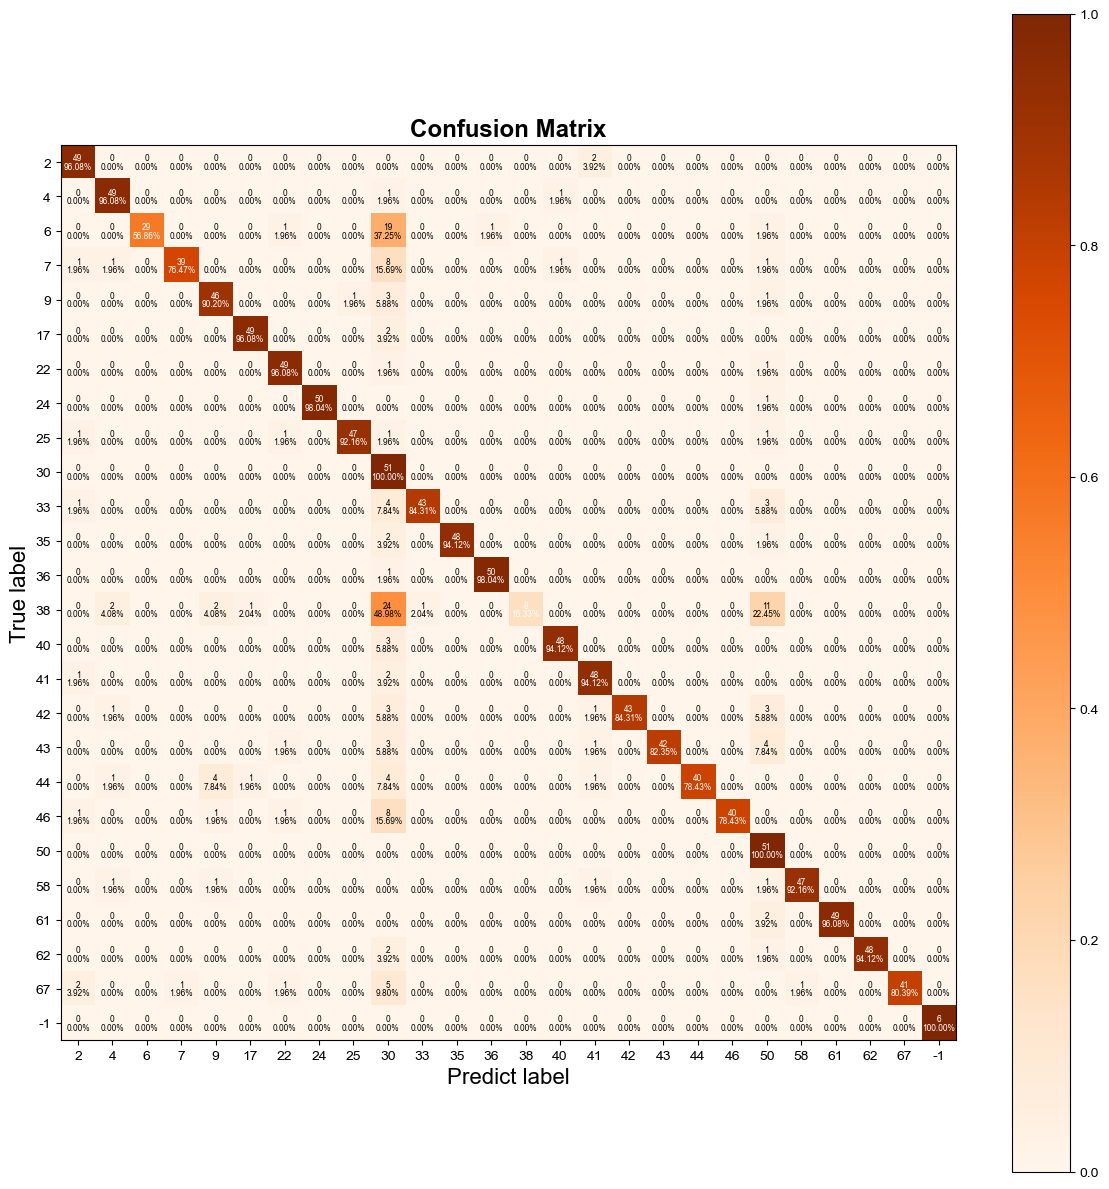

The accuracy of the model is 86.79%
The recall of the model is 94.07%
The precision of the model is 91.81%
The F1 of the model is 92.93%


In [38]:
p_label, p_acc, p_val = svm_predict(test_label, test_set, model,'-b 1')

prelabel(test,p_label)

confusion_matrix(test)

_,_,_,_ = score(test)

# But the input feature is not normalized

### fitting_nor is the function that adds normalization step to transform the format of the input

In [24]:
train_set,test_set,train_label,test_label = fitting_nor(train,test,200)

In [25]:
options = '-t 0 -c 1 -b 1'  
model = svm_train(train_label,train_set,options)

*
optimization finished, #iter = 91
nu = 0.016185
obj = -0.865823, rho = 0.913875
nSV = 28, nBSV = 0
Total nSV = 28
*
optimization finished, #iter = 105
nu = 0.017818
obj = -0.944246, rho = 0.905729
nSV = 29, nBSV = 0
Total nSV = 29
*
optimization finished, #iter = 93
nu = 0.016745
obj = -0.895730, rho = 0.897529
nSV = 31, nBSV = 0
Total nSV = 31
*
optimization finished, #iter = 102
nu = 0.017157
obj = -0.909292, rho = 0.898824
nSV = 30, nBSV = 0
Total nSV = 30
*
optimization finished, #iter = 80
nu = 0.015121
obj = -0.801277, rho = 0.935946
nSV = 26, nBSV = 0
Total nSV = 26
*
optimization finished, #iter = 103
nu = 0.014409
obj = -0.958131, rho = 0.902925
nSV = 31, nBSV = 0
*
optimization finished, #iter = 94
nu = 0.015962
obj = -0.853882, rho = 0.886872
nSV = 29, nBSV = 0
Total nSV = 29
*.*
optimization finished, #iter = 115
nu = 0.017444
obj = -0.924443, rho = 0.896859
nSV = 34, nBSV = 0
Total nSV = 34
*.*
optimization finished, #iter = 134
nu = 0.016387
obj = -0.876574, rho = 0.906

*
optimization finished, #iter = 148
nu = 0.139425
obj = -13.979335, rho = 0.036992
nSV = 44, nBSV = 10
Total nSV = 44
*
optimization finished, #iter = 179
nu = 0.120088
obj = -15.063784, rho = 0.027133
nSV = 47, nBSV = 9
*.*
optimization finished, #iter = 202
nu = 0.118855
obj = -11.711288, rho = -0.155218
nSV = 48, nBSV = 7
Total nSV = 48
*
optimization finished, #iter = 187
nu = 0.114367
obj = -11.336592, rho = -0.134687
nSV = 49, nBSV = 6
Total nSV = 49
*.*
optimization finished, #iter = 209
nu = 0.107107
obj = -10.475521, rho = -0.119468
nSV = 48, nBSV = 5
Total nSV = 48
*.*
optimization finished, #iter = 306
nu = 0.117395
obj = -11.475967, rho = -0.144989
nSV = 53, nBSV = 6
Total nSV = 53
*.*
optimization finished, #iter = 234
nu = 0.111581
obj = -10.935216, rho = -0.171080
nSV = 48, nBSV = 6
Total nSV = 48
*.*
optimization finished, #iter = 264
nu = 0.098762
obj = -12.026045, rho = -0.142389
nSV = 56, nBSV = 6
*.*
optimization finished, #iter = 254
nu = 0.164601
obj = -16.760359

*.*
optimization finished, #iter = 370
nu = 0.097171
obj = -11.893986, rho = -0.042338
nSV = 57, nBSV = 7
*
optimization finished, #iter = 179
nu = 0.146175
obj = -14.967078, rho = -0.089814
nSV = 51, nBSV = 13
Total nSV = 51
*.*
optimization finished, #iter = 196
nu = 0.146530
obj = -15.023817, rho = -0.051676
nSV = 53, nBSV = 12
Total nSV = 53
*.*
optimization finished, #iter = 249
nu = 0.155697
obj = -15.711193, rho = -0.110897
nSV = 57, nBSV = 11
Total nSV = 57
*
optimization finished, #iter = 174
nu = 0.152119
obj = -15.572468, rho = -0.138697
nSV = 51, nBSV = 14
Total nSV = 51
*.*
optimization finished, #iter = 231
nu = 0.154606
obj = -15.708854, rho = -0.079193
nSV = 56, nBSV = 11
Total nSV = 56
*
optimization finished, #iter = 183
nu = 0.130931
obj = -16.535035, rho = -0.082726
nSV = 55, nBSV = 12
*
optimization finished, #iter = 167
nu = 0.130164
obj = -12.825185, rho = 0.079902
nSV = 48, nBSV = 8
Total nSV = 48
*.*
optimization finished, #iter = 269
nu = 0.116744
obj = -11.60

*
optimization finished, #iter = 208
nu = 0.098096
obj = -11.978941, rho = -0.142865
nSV = 52, nBSV = 8
*.*
optimization finished, #iter = 235
nu = 0.140060
obj = -14.264965, rho = -0.022482
nSV = 54, nBSV = 11
Total nSV = 54
*.*
optimization finished, #iter = 257
nu = 0.136622
obj = -13.502028, rho = -0.034586
nSV = 51, nBSV = 9
Total nSV = 51
*
optimization finished, #iter = 162
nu = 0.127722
obj = -13.223095, rho = 0.079176
nSV = 47, nBSV = 11
Total nSV = 47
*.*
optimization finished, #iter = 224
nu = 0.133873
obj = -13.538035, rho = -0.051622
nSV = 51, nBSV = 13
Total nSV = 51
*.*
optimization finished, #iter = 228
nu = 0.130925
obj = -13.211145, rho = 0.053619
nSV = 50, nBSV = 10
Total nSV = 50
*
optimization finished, #iter = 207
nu = 0.119740
obj = -14.813748, rho = -0.016074
nSV = 51, nBSV = 14
*.*
optimization finished, #iter = 231
nu = 0.089764
obj = -8.852425, rho = -0.004323
nSV = 51, nBSV = 4
Total nSV = 51
*.*
optimization finished, #iter = 210
nu = 0.096434
obj = -9.3364

*.*
optimization finished, #iter = 204
nu = 0.119725
obj = -12.125668, rho = 0.038157
nSV = 44, nBSV = 8
Total nSV = 44
*
optimization finished, #iter = 170
nu = 0.129387
obj = -13.128005, rho = -0.034648
nSV = 50, nBSV = 11
Total nSV = 50
*
optimization finished, #iter = 190
nu = 0.114689
obj = -11.680128, rho = -0.038564
nSV = 46, nBSV = 7
Total nSV = 46
*.*
optimization finished, #iter = 191
nu = 0.116069
obj = -11.493311, rho = -0.087601
nSV = 44, nBSV = 7
Total nSV = 44
*.*
optimization finished, #iter = 216
nu = 0.124935
obj = -12.692808, rho = -0.005761
nSV = 51, nBSV = 11
Total nSV = 51
*
optimization finished, #iter = 165
nu = 0.105164
obj = -13.269487, rho = -0.025757
nSV = 55, nBSV = 12
*.*
optimization finished, #iter = 303
nu = 0.136832
obj = -13.524056, rho = 0.049210
nSV = 59, nBSV = 7
Total nSV = 59
*.*
optimization finished, #iter = 304
nu = 0.136652
obj = -13.203066, rho = 0.042102
nSV = 56, nBSV = 6
Total nSV = 56
.*
optimization finished, #iter = 330
nu = 0.133453
o

*.*
optimization finished, #iter = 335
nu = 0.137131
obj = -17.038636, rho = 0.103045
nSV = 67, nBSV = 10
*.*
optimization finished, #iter = 239
nu = 0.122470
obj = -11.880136, rho = 0.065913
nSV = 52, nBSV = 4
Total nSV = 52
.*
optimization finished, #iter = 365
nu = 0.121828
obj = -11.724663, rho = 0.052144
nSV = 62, nBSV = 5
Total nSV = 62
*.*
optimization finished, #iter = 237
nu = 0.121000
obj = -11.798522, rho = 0.044483
nSV = 52, nBSV = 5
Total nSV = 52
*.*
optimization finished, #iter = 254
nu = 0.124200
obj = -12.029941, rho = 0.036097
nSV = 56, nBSV = 4
Total nSV = 56
*.*
optimization finished, #iter = 232
nu = 0.127740
obj = -12.310605, rho = 0.083991
nSV = 53, nBSV = 6
Total nSV = 53
*.*
optimization finished, #iter = 245
nu = 0.107193
obj = -12.930120, rho = 0.084907
nSV = 60, nBSV = 6
*.*
optimization finished, #iter = 265
nu = 0.147392
obj = -15.011947, rho = -0.158878
nSV = 56, nBSV = 10
Total nSV = 56
*
optimization finished, #iter = 180
nu = 0.146293
obj = -14.934076,

*.*
optimization finished, #iter = 248
nu = 0.123992
obj = -12.258676, rho = 0.007813
nSV = 53, nBSV = 6
Total nSV = 53
*.*
optimization finished, #iter = 285
nu = 0.114179
obj = -13.960834, rho = 0.031887
nSV = 58, nBSV = 7
*.*
optimization finished, #iter = 230
nu = 0.122279
obj = -12.181737, rho = -0.090183
nSV = 52, nBSV = 7
Total nSV = 52
*.*
optimization finished, #iter = 198
nu = 0.117496
obj = -11.860647, rho = -0.061341
nSV = 51, nBSV = 8
Total nSV = 51
*.*
optimization finished, #iter = 196
nu = 0.113437
obj = -11.287764, rho = -0.063174
nSV = 50, nBSV = 7
Total nSV = 50
*.*
optimization finished, #iter = 255
nu = 0.121036
obj = -12.195605, rho = -0.088976
nSV = 52, nBSV = 8
Total nSV = 52
*
optimization finished, #iter = 188
nu = 0.121770
obj = -12.112135, rho = -0.063143
nSV = 47, nBSV = 8
Total nSV = 47
*.*
optimization finished, #iter = 288
nu = 0.102729
obj = -12.801762, rho = -0.065357
nSV = 56, nBSV = 9
*.*
optimization finished, #iter = 246
nu = 0.133093
obj = -13.365

*.*
optimization finished, #iter = 292
nu = 0.112182
obj = -10.903915, rho = -0.143214
nSV = 55, nBSV = 6
Total nSV = 55
*.*
optimization finished, #iter = 196
nu = 0.103968
obj = -9.840910, rho = -0.163295
nSV = 46, nBSV = 4
Total nSV = 46
*.*
optimization finished, #iter = 204
nu = 0.111930
obj = -10.857730, rho = -0.161237
nSV = 47, nBSV = 4
Total nSV = 47
*.*
optimization finished, #iter = 297
nu = 0.114451
obj = -10.951599, rho = -0.181011
nSV = 53, nBSV = 4
Total nSV = 53
*
optimization finished, #iter = 185
nu = 0.111605
obj = -10.786862, rho = -0.173043
nSV = 44, nBSV = 5
Total nSV = 44
*.*
optimization finished, #iter = 327
nu = 0.093884
obj = -11.261642, rho = -0.175425
nSV = 55, nBSV = 4
*
optimization finished, #iter = 145
nu = 0.155873
obj = -16.044309, rho = -0.086901
nSV = 48, nBSV = 17
Total nSV = 48
*.*
optimization finished, #iter = 191
nu = 0.146780
obj = -14.675967, rho = -0.076332
nSV = 53, nBSV = 11
Total nSV = 53
*
optimization finished, #iter = 163
nu = 0.147818

*.*
optimization finished, #iter = 271
nu = 0.125310
obj = -12.397345, rho = -0.181164
nSV = 50, nBSV = 8
Total nSV = 50
*
optimization finished, #iter = 147
nu = 0.123242
obj = -12.121087, rho = -0.181599
nSV = 44, nBSV = 9
Total nSV = 44
*
optimization finished, #iter = 185
nu = 0.103703
obj = -12.827195, rho = -0.178351
nSV = 48, nBSV = 9
*
optimization finished, #iter = 188
nu = 0.128589
obj = -13.242054, rho = -0.270444
nSV = 51, nBSV = 12
Total nSV = 51
*
optimization finished, #iter = 166
nu = 0.133118
obj = -13.486294, rho = -0.249022
nSV = 48, nBSV = 11
Total nSV = 48
*
optimization finished, #iter = 164
nu = 0.134855
obj = -13.883064, rho = -0.253271
nSV = 46, nBSV = 12
Total nSV = 46
*
optimization finished, #iter = 131
nu = 0.120184
obj = -12.272753, rho = -0.147736
nSV = 41, nBSV = 11
Total nSV = 41
*
optimization finished, #iter = 161
nu = 0.127535
obj = -12.847964, rho = -0.228691
nSV = 47, nBSV = 11
Total nSV = 47
*
optimization finished, #iter = 167
nu = 0.111058
obj =

*.*
optimization finished, #iter = 210
nu = 0.166507
obj = -16.964448, rho = -0.035846
nSV = 54, nBSV = 14
Total nSV = 54
*
optimization finished, #iter = 159
nu = 0.158723
obj = -15.934896, rho = -0.045558
nSV = 52, nBSV = 14
Total nSV = 52
*.*
optimization finished, #iter = 275
nu = 0.143961
obj = -18.143930, rho = -0.009065
nSV = 56, nBSV = 13
*.*
optimization finished, #iter = 238
nu = 0.097958
obj = -9.656686, rho = -0.184617
nSV = 52, nBSV = 4
Total nSV = 52
*.*
optimization finished, #iter = 232
nu = 0.106714
obj = -10.488881, rho = -0.096792
nSV = 51, nBSV = 4
Total nSV = 51
*.*
optimization finished, #iter = 227
nu = 0.111497
obj = -11.094746, rho = -0.122299
nSV = 50, nBSV = 4
Total nSV = 50
*.*
optimization finished, #iter = 294
nu = 0.099174
obj = -9.788125, rho = -0.168571
nSV = 56, nBSV = 5
Total nSV = 56
*.*
optimization finished, #iter = 243
nu = 0.111581
obj = -10.922428, rho = -0.097372
nSV = 52, nBSV = 5
Total nSV = 52
*
optimization finished, #iter = 218
nu = 0.0904

*.*
optimization finished, #iter = 258
nu = 0.089244
obj = -11.077550, rho = -0.011326
nSV = 57, nBSV = 7
*.*
optimization finished, #iter = 212
nu = 0.098305
obj = -9.666647, rho = -0.049889
nSV = 48, nBSV = 4
Total nSV = 48
*.*
optimization finished, #iter = 273
nu = 0.098572
obj = -9.754562, rho = -0.071077
nSV = 50, nBSV = 5
Total nSV = 50
*.*
optimization finished, #iter = 228
nu = 0.097779
obj = -9.751791, rho = -0.079875
nSV = 47, nBSV = 7
Total nSV = 47
*.*
optimization finished, #iter = 202
nu = 0.098792
obj = -9.822685, rho = -0.100237
nSV = 48, nBSV = 5
Total nSV = 48
*.*
optimization finished, #iter = 246
nu = 0.099277
obj = -9.754635, rho = -0.059622
nSV = 51, nBSV = 4
Total nSV = 51
*.*
optimization finished, #iter = 245
nu = 0.084396
obj = -10.461264, rho = -0.090663
nSV = 54, nBSV = 5
*.*
optimization finished, #iter = 233
nu = 0.107683
obj = -10.523573, rho = 0.012000
nSV = 52, nBSV = 4
Total nSV = 52
.*.*
optimization finished, #iter = 407
nu = 0.101584
obj = -9.97000

*.*
optimization finished, #iter = 233
nu = 0.135351
obj = -13.623163, rho = 0.148647
nSV = 55, nBSV = 8
Total nSV = 55
*.*
optimization finished, #iter = 198
nu = 0.130652
obj = -13.152046, rho = 0.194410
nSV = 54, nBSV = 10
Total nSV = 54
*.*
optimization finished, #iter = 275
nu = 0.125374
obj = -12.510459, rho = 0.118120
nSV = 55, nBSV = 8
Total nSV = 55
*.*
optimization finished, #iter = 317
nu = 0.115798
obj = -14.544068, rho = 0.187807
nSV = 62, nBSV = 8
*.*
optimization finished, #iter = 193
nu = 0.120430
obj = -11.879806, rho = 0.080595
nSV = 48, nBSV = 11
Total nSV = 48
*
optimization finished, #iter = 177
nu = 0.116213
obj = -11.313661, rho = 0.054537
nSV = 48, nBSV = 8
Total nSV = 48
*
optimization finished, #iter = 190
nu = 0.120990
obj = -11.853312, rho = 0.127470
nSV = 46, nBSV = 10
Total nSV = 46
*.*
optimization finished, #iter = 197
nu = 0.121481
obj = -11.763236, rho = 0.125316
nSV = 48, nBSV = 7
Total nSV = 48
*
optimization finished, #iter = 172
nu = 0.107987
obj =

*.*
optimization finished, #iter = 207
nu = 0.103887
obj = -10.877470, rho = 0.025264
nSV = 52, nBSV = 10
Total nSV = 52
*
optimization finished, #iter = 176
nu = 0.093503
obj = -9.451633, rho = -0.037711
nSV = 45, nBSV = 6
Total nSV = 45
*
optimization finished, #iter = 182
nu = 0.107265
obj = -11.109666, rho = 0.013304
nSV = 47, nBSV = 9
Total nSV = 47
*.*
optimization finished, #iter = 230
nu = 0.101706
obj = -10.310960, rho = -0.000842
nSV = 50, nBSV = 6
Total nSV = 50
*
optimization finished, #iter = 196
nu = 0.086836
obj = -11.217588, rho = 0.025843
nSV = 53, nBSV = 8
*
optimization finished, #iter = 168
nu = 0.171408
obj = -18.252613, rho = 0.160633
nSV = 51, nBSV = 18
Total nSV = 51
*.*
optimization finished, #iter = 206
nu = 0.173257
obj = -18.411886, rho = 0.089061
nSV = 52, nBSV = 17
Total nSV = 52
*
optimization finished, #iter = 177
nu = 0.173001
obj = -18.043768, rho = 0.055149
nSV = 52, nBSV = 17
Total nSV = 52
*
optimization finished, #iter = 179
nu = 0.174687
obj = -18

*.*
optimization finished, #iter = 250
nu = 0.108744
obj = -10.644134, rho = 0.066566
nSV = 50, nBSV = 5
Total nSV = 50
*
optimization finished, #iter = 169
nu = 0.116681
obj = -11.754624, rho = 0.104260
nSV = 48, nBSV = 8
Total nSV = 48
*.*
optimization finished, #iter = 271
nu = 0.101267
obj = -12.644465, rho = 0.099753
nSV = 53, nBSV = 8
*.*
optimization finished, #iter = 226
nu = 0.096447
obj = -9.315362, rho = 0.090555
nSV = 50, nBSV = 5
Total nSV = 50
*.*
optimization finished, #iter = 237
nu = 0.093380
obj = -9.039398, rho = -0.023498
nSV = 48, nBSV = 2
Total nSV = 48
*.*
optimization finished, #iter = 247
nu = 0.102120
obj = -9.863833, rho = 0.059883
nSV = 45, nBSV = 3
Total nSV = 45
*.*
optimization finished, #iter = 218
nu = 0.098681
obj = -9.442317, rho = 0.017687
nSV = 52, nBSV = 4
Total nSV = 52
*.*
optimization finished, #iter = 226
nu = 0.094643
obj = -9.151885, rho = 0.010386
nSV = 46, nBSV = 3
Total nSV = 46
*.*
optimization finished, #iter = 303
nu = 0.082664
obj = -9

*.*
optimization finished, #iter = 243
nu = 0.111895
obj = -10.972426, rho = -0.125400
nSV = 50, nBSV = 5
Total nSV = 50
*.*
optimization finished, #iter = 249
nu = 0.098824
obj = -9.759163, rho = -0.061948
nSV = 56, nBSV = 5
Total nSV = 56
*.*
optimization finished, #iter = 240
nu = 0.108961
obj = -10.717485, rho = -0.121514
nSV = 52, nBSV = 8
Total nSV = 52
*.*
optimization finished, #iter = 233
nu = 0.103250
obj = -10.354419, rho = -0.148595
nSV = 51, nBSV = 6
Total nSV = 51
*.*
optimization finished, #iter = 231
nu = 0.105331
obj = -10.170694, rho = -0.144635
nSV = 50, nBSV = 5
Total nSV = 50
*
optimization finished, #iter = 213
nu = 0.092319
obj = -11.250588, rho = -0.159394
nSV = 55, nBSV = 5
*.*
optimization finished, #iter = 262
nu = 0.098652
obj = -9.515072, rho = -0.046631
nSV = 53, nBSV = 4
Total nSV = 53
*.*
optimization finished, #iter = 316
nu = 0.097639
obj = -9.161779, rho = -0.035544
nSV = 53, nBSV = 3
Total nSV = 53
*.*
optimization finished, #iter = 289
nu = 0.098144

*.*
optimization finished, #iter = 206
nu = 0.116550
obj = -11.368615, rho = 0.122743
nSV = 53, nBSV = 7
Total nSV = 53
.*
optimization finished, #iter = 317
nu = 0.120619
obj = -11.734917, rho = 0.139037
nSV = 58, nBSV = 5
Total nSV = 58
.*
optimization finished, #iter = 345
nu = 0.115731
obj = -11.436504, rho = 0.167171
nSV = 62, nBSV = 7
Total nSV = 62
*.*
optimization finished, #iter = 244
nu = 0.120569
obj = -11.705684, rho = 0.129240
nSV = 57, nBSV = 7
Total nSV = 57
*.*
optimization finished, #iter = 242
nu = 0.124020
obj = -12.128016, rho = 0.161219
nSV = 53, nBSV = 6
Total nSV = 53
*.*
optimization finished, #iter = 309
nu = 0.104982
obj = -12.758616, rho = 0.140731
nSV = 59, nBSV = 8
*.*
optimization finished, #iter = 285
nu = 0.140992
obj = -14.026867, rho = 0.015795
nSV = 59, nBSV = 8
Total nSV = 59
*.*
optimization finished, #iter = 243
nu = 0.130666
obj = -12.715197, rho = -0.055452
nSV = 55, nBSV = 6
Total nSV = 55
*.*
optimization finished, #iter = 265
nu = 0.130107
obj

*.*
optimization finished, #iter = 264
nu = 0.121627
obj = -12.159491, rho = -0.054611
nSV = 51, nBSV = 7
Total nSV = 51
*.*
optimization finished, #iter = 271
nu = 0.134580
obj = -13.006070, rho = -0.025831
nSV = 52, nBSV = 4
Total nSV = 52
.*.*
optimization finished, #iter = 488
nu = 0.124163
obj = -11.954901, rho = 0.032874
nSV = 62, nBSV = 4
Total nSV = 62
*.*
optimization finished, #iter = 381
nu = 0.113593
obj = -13.764351, rho = -0.021712
nSV = 66, nBSV = 8
*.*
optimization finished, #iter = 209
nu = 0.091461
obj = -9.277832, rho = -0.132755
nSV = 50, nBSV = 5
Total nSV = 50
*.*
optimization finished, #iter = 317
nu = 0.100939
obj = -10.033881, rho = -0.094358
nSV = 57, nBSV = 6
Total nSV = 57
*.*
optimization finished, #iter = 274
nu = 0.103934
obj = -10.291314, rho = -0.058848
nSV = 52, nBSV = 6
Total nSV = 52
*.*
optimization finished, #iter = 302
nu = 0.103371
obj = -10.320862, rho = -0.091547
nSV = 59, nBSV = 5
Total nSV = 59
*
optimization finished, #iter = 167
nu = 0.1013

*
optimization finished, #iter = 186
nu = 0.136158
obj = -14.451419, rho = 0.202708
nSV = 49, nBSV = 13
Total nSV = 49
*
optimization finished, #iter = 147
nu = 0.150451
obj = -16.414658, rho = 0.146987
nSV = 50, nBSV = 19
Total nSV = 50
*
optimization finished, #iter = 160
nu = 0.144296
obj = -15.423247, rho = 0.182012
nSV = 49, nBSV = 17
Total nSV = 49
*.*
optimization finished, #iter = 223
nu = 0.129378
obj = -13.262188, rho = -0.034010
nSV = 46, nBSV = 7
Total nSV = 46
*
optimization finished, #iter = 157
nu = 0.128585
obj = -17.120709, rho = 0.113662
nSV = 53, nBSV = 18
*.*
optimization finished, #iter = 263
nu = 0.123982
obj = -12.286642, rho = 0.148113
nSV = 60, nBSV = 8
Total nSV = 60
.*
optimization finished, #iter = 324
nu = 0.123996
obj = -12.331506, rho = 0.166942
nSV = 59, nBSV = 6
Total nSV = 59
*.*
optimization finished, #iter = 254
nu = 0.115194
obj = -11.482828, rho = 0.112323
nSV = 55, nBSV = 7
Total nSV = 55
*.*
optimization finished, #iter = 262
nu = 0.118991
obj = 

*.*
optimization finished, #iter = 243
nu = 0.114643
obj = -11.625965, rho = 0.131460
nSV = 53, nBSV = 7
Total nSV = 53
*.*
optimization finished, #iter = 277
nu = 0.103840
obj = -13.074735, rho = 0.192647
nSV = 55, nBSV = 9
*.*
optimization finished, #iter = 214
nu = 0.116028
obj = -11.513175, rho = 0.218395
nSV = 49, nBSV = 7
Total nSV = 49
.*
optimization finished, #iter = 338
nu = 0.114418
obj = -11.172125, rho = 0.219706
nSV = 55, nBSV = 5
Total nSV = 55
*.*
optimization finished, #iter = 210
nu = 0.121664
obj = -11.982580, rho = 0.213223
nSV = 51, nBSV = 8
Total nSV = 51
*.*
optimization finished, #iter = 199
nu = 0.118539
obj = -11.634109, rho = 0.185756
nSV = 48, nBSV = 11
Total nSV = 48
*.*
optimization finished, #iter = 282
nu = 0.112796
obj = -11.020935, rho = 0.284723
nSV = 51, nBSV = 4
Total nSV = 51
*.*
optimization finished, #iter = 385
nu = 0.099550
obj = -12.147514, rho = 0.235125
nSV = 57, nBSV = 7
*
optimization finished, #iter = 183
nu = 0.095876
obj = -9.635777, rh

*.*
optimization finished, #iter = 197
nu = 0.103540
obj = -10.309184, rho = 0.036239
nSV = 55, nBSV = 7
Total nSV = 55
*.*
optimization finished, #iter = 295
nu = 0.103081
obj = -10.117285, rho = -0.037164
nSV = 56, nBSV = 6
Total nSV = 56
*.*
optimization finished, #iter = 320
nu = 0.091130
obj = -11.314322, rho = 0.007961
nSV = 58, nBSV = 8
*.*
optimization finished, #iter = 247
nu = 0.118303
obj = -11.530793, rho = 0.042533
nSV = 49, nBSV = 6
Total nSV = 49
*.*
optimization finished, #iter = 199
nu = 0.122606
obj = -12.069217, rho = 0.079060
nSV = 50, nBSV = 7
Total nSV = 50
.*
optimization finished, #iter = 327
nu = 0.123029
obj = -12.040642, rho = 0.020801
nSV = 54, nBSV = 6
Total nSV = 54
*.*
optimization finished, #iter = 205
nu = 0.121528
obj = -11.992098, rho = 0.034492
nSV = 52, nBSV = 7
Total nSV = 52
.*
optimization finished, #iter = 285
nu = 0.115516
obj = -10.969458, rho = -0.023960
nSV = 52, nBSV = 3
Total nSV = 52
*.*
optimization finished, #iter = 346
nu = 0.102786
ob

*.*
optimization finished, #iter = 224
nu = 0.136015
obj = -13.511562, rho = 0.027038
nSV = 55, nBSV = 7
Total nSV = 55
*.*
optimization finished, #iter = 247
nu = 0.118716
obj = -14.952419, rho = -0.002569
nSV = 60, nBSV = 11
*
optimization finished, #iter = 171
nu = 0.113734
obj = -11.236732, rho = -0.173926
nSV = 44, nBSV = 5
Total nSV = 44
*
optimization finished, #iter = 184
nu = 0.117359
obj = -11.562301, rho = -0.081976
nSV = 45, nBSV = 6
Total nSV = 45
*
optimization finished, #iter = 163
nu = 0.112297
obj = -11.105265, rho = -0.081777
nSV = 45, nBSV = 7
Total nSV = 45
*.*
optimization finished, #iter = 237
nu = 0.114728
obj = -11.358796, rho = -0.097687
nSV = 49, nBSV = 5
Total nSV = 49
*
optimization finished, #iter = 145
nu = 0.115486
obj = -11.425937, rho = -0.102533
nSV = 46, nBSV = 7
Total nSV = 46
*
optimization finished, #iter = 164
nu = 0.098790
obj = -12.127209, rho = -0.089302
nSV = 49, nBSV = 7
*
optimization finished, #iter = 125
nu = 0.133298
obj = -13.534836, rho

*.*
optimization finished, #iter = 238
nu = 0.113003
obj = -11.180875, rho = 0.012347
nSV = 51, nBSV = 6
Total nSV = 51
*.*
optimization finished, #iter = 341
nu = 0.099226
obj = -12.467000, rho = 0.004492
nSV = 60, nBSV = 9
*.*
optimization finished, #iter = 322
nu = 0.119106
obj = -12.181327, rho = 0.096815
nSV = 61, nBSV = 8
Total nSV = 61
*.*
optimization finished, #iter = 266
nu = 0.120511
obj = -12.238544, rho = 0.058111
nSV = 54, nBSV = 8
Total nSV = 54
*
optimization finished, #iter = 190
nu = 0.110145
obj = -10.954574, rho = 0.100986
nSV = 46, nBSV = 6
Total nSV = 46
*.*
optimization finished, #iter = 268
nu = 0.115449
obj = -11.592388, rho = 0.113973
nSV = 50, nBSV = 7
Total nSV = 50
*
optimization finished, #iter = 185
nu = 0.115623
obj = -11.581392, rho = 0.150835
nSV = 46, nBSV = 6
Total nSV = 46
*.*
optimization finished, #iter = 306
nu = 0.100952
obj = -12.694411, rho = 0.105387
nSV = 56, nBSV = 8
.*
optimization finished, #iter = 301
nu = 0.106927
obj = -10.677406, rho 

*.*
optimization finished, #iter = 226
nu = 0.145893
obj = -15.434900, rho = 0.065317
nSV = 53, nBSV = 10
Total nSV = 53
*.*
optimization finished, #iter = 191
nu = 0.160733
obj = -16.690043, rho = -0.083571
nSV = 51, nBSV = 13
Total nSV = 51
*
optimization finished, #iter = 234
nu = 0.135264
obj = -17.704832, rho = -0.029837
nSV = 58, nBSV = 14
*.*
optimization finished, #iter = 289
nu = 0.138589
obj = -14.158278, rho = 0.109503
nSV = 57, nBSV = 10
Total nSV = 57
*.*
optimization finished, #iter = 215
nu = 0.136991
obj = -14.003907, rho = 0.103954
nSV = 56, nBSV = 12
Total nSV = 56
*.*
optimization finished, #iter = 293
nu = 0.126693
obj = -12.729835, rho = 0.088938
nSV = 55, nBSV = 8
Total nSV = 55
*.*
optimization finished, #iter = 227
nu = 0.142320
obj = -14.458310, rho = 0.106913
nSV = 55, nBSV = 11
Total nSV = 55
*.*
optimization finished, #iter = 223
nu = 0.127724
obj = -12.959665, rho = 0.159512
nSV = 52, nBSV = 9
Total nSV = 52
*.*
optimization finished, #iter = 250
nu = 0.116

*.*
optimization finished, #iter = 307
nu = 0.120092
obj = -15.137589, rho = 0.219148
nSV = 58, nBSV = 10
*.*
optimization finished, #iter = 262
nu = 0.124450
obj = -12.316424, rho = -0.020150
nSV = 51, nBSV = 7
Total nSV = 51
*.*
optimization finished, #iter = 290
nu = 0.129051
obj = -12.695418, rho = 0.036242
nSV = 55, nBSV = 4
Total nSV = 55
*.*
optimization finished, #iter = 261
nu = 0.131007
obj = -13.026243, rho = 0.072422
nSV = 56, nBSV = 6
Total nSV = 56
*.*
optimization finished, #iter = 238
nu = 0.130858
obj = -12.808690, rho = 0.045575
nSV = 55, nBSV = 9
Total nSV = 55
*.*
optimization finished, #iter = 237
nu = 0.135498
obj = -13.534717, rho = -0.008876
nSV = 57, nBSV = 9
Total nSV = 57
*.*
optimization finished, #iter = 259
nu = 0.116707
obj = -14.339922, rho = 0.033228
nSV = 58, nBSV = 7
*
optimization finished, #iter = 183
nu = 0.104065
obj = -10.356169, rho = 0.072393
nSV = 48, nBSV = 9
Total nSV = 48
*.*
optimization finished, #iter = 215
nu = 0.118463
obj = -11.823147

In [26]:
p_label, p_acc, p_val = svm_predict(test_label, test_set, model,'-b 1')

Accuracy = 98.3581% (1258/1279) (classification)


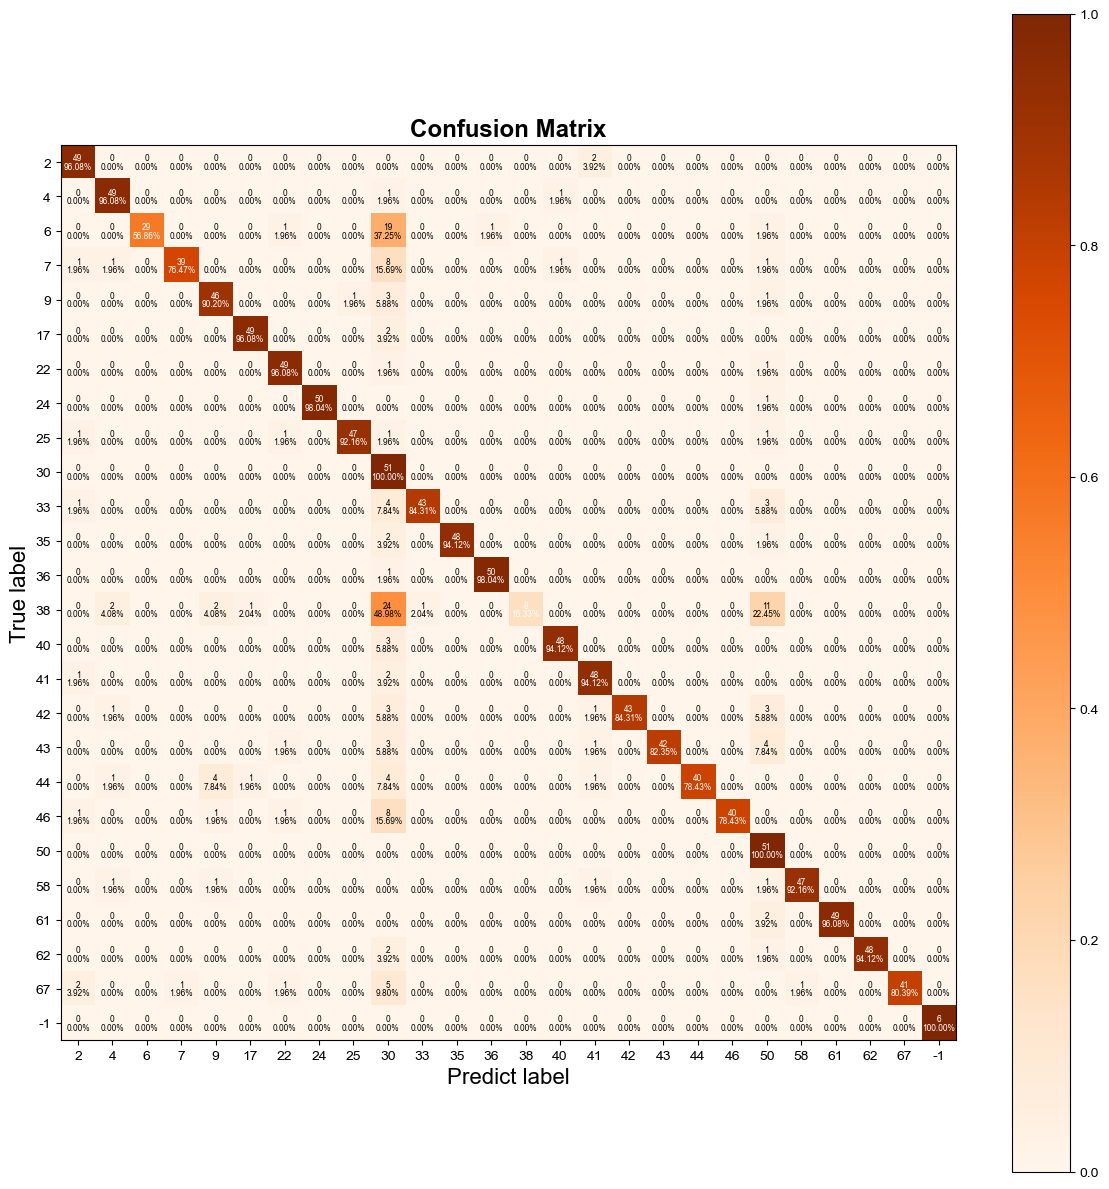

The accuracy of the model is 86.79%
The recall of the model is 94.07%
The precision of the model is 91.81%
The F1 of the model is 92.93%


In [39]:
prelabel(test,p_label)

confusion_matrix(test)

_,_,_,_ = score(test)

## The accuracy is lower than not normalized one. In my oppion, both accuracy are very close to 100% and the right predicted label difference is just 5. So it can not show the importance and influnce of normalization 